# RL-controlled adaptive time stepping (user-defined)

This notebook evaluates reinforcement-learning controllers built on top of

`Solve_IVP_NS`. The reward shaping, observation mapping, and policy choices

are defined in the notebook itself and are **not** part of the package API.

Treat them as example user code that you can adapt or replace. Running this

evaluation is optional and not required for installing, testing, or using

the core solver library.


In [1]:
from plants.faults import strikeslip
import os

import Solve_IVP_NS  # Ensure that this module is in your PYTHONPATH
import numpy as np
import matplotlib.pyplot as plt
import time



In [2]:
import autograd.numpy as anp
from scipy.optimize import root
from abc import ABC, abstractmethod
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from tqdm import tqdm
import time 

import torch as th
from torch import nn
from stable_baselines3.td3.policies import TD3Policy
from stable_baselines3.sac.policies import SACPolicy  
from stable_baselines3.common.vec_env import VecNormalize
import gymnasium as gym
from gymnasium import spaces

from sb3_contrib import TQC
from stable_baselines3 import TD3, DDPG, SAC
from stable_baselines3.common.env_util import make_vec_env, DummyVecEnv
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.noise import NormalActionNoise, OrnsteinUhlenbeckActionNoise

from Solve_IVP_NS.rl.env import AdaptiveStepperEnv
from Solve_IVP_NS.rl.callbacks import RewardCallback, CustomMetricsCallback

sizes = 30
plt.rcParams.update({
    'font.size': sizes,
    'axes.titlesize': sizes,
    'axes.labelsize': sizes,
    'xtick.labelsize': sizes,
    'ytick.labelsize': sizes,
    'legend.fontsize': sizes,
    'figure.titlesize': sizes,
    'text.usetex': True,
    'font.family': 'Times',
    # Embed fonts in vector outputs so text is editable
    'pdf.fonttype': 42,
    'ps.fonttype': 42,
    # Keep LaTeX preamble minimal to prevent bloat and ensure Times math
    'text.latex.preamble': r'\usepackage{amsmath}\usepackage{mathptmx}',
    # Cleaner default look; we'll style axes explicitly in plotting code
    'axes.grid': False,
})


import Solve_IVP_NS  # Ensure that this module is in your PYTHONPATH
th.set_default_dtype(th.float32)

In [3]:
from pathlib import Path
DATA_DIR = str((Path.cwd() / "Data").resolve())

# Initialize fault model
fault = strikeslip.qs_strikeslip_fault(
    zdepth=3, xlength=3, Nz=1, Nx=1,  
    G=30000., rho=2.5e-3, zeta=0.8/3, 
    Ks_path="./Data/", gamma_s=25., gamma_w=10., 
    sigma_ref=100., depth_ini=0., vinf=3.171e-10, 
    Dmu_estimate=.5,
)

# Get plant parameters
MA, KS, ES, SIGMA_N, VINF_raw = fault.get_plant()

# Print diagnostic information
print(f"Theoretical value of total stiffness assuming a patch of dimensions Lx x Lz: {KS.sum()}")
print(f"Approximate value of total stiffness assuming a patch of length Lx: {3.333333333333333e-07}")
print(f"Calculated value: {3.962559156372552e-07}")
print(f"Units are in: mm,N,ms,MPa,gr")

Loading: ./Data/kijs_1x1elem-3x3length.npy
Theoretical value of total stiffness assuming a patch of dimensions Lx x Lz:  3.501230118388745e-07
Approximate value of total stiffness assuming a patch of length Lx:  3.333333333333333e-07
Calculated value:  2.680356930289319e-07
Units are in: mm,N,ms,MPa,gr
Theoretical value of total stiffness assuming a patch of dimensions Lx x Lz: 1.0000000000000002
Approximate value of total stiffness assuming a patch of length Lx: 3.333333333333333e-07
Calculated value: 3.962559156372552e-07
Units are in: mm,N,ms,MPa,gr


In [4]:
import scipy.sparse as sp

N_DOFS = fault.N                                # int
VINF = VINF_raw * np.ones(N_DOFS)*0               # scalar vinf

# Sparse block matrix for the solver (CSR)
# A = block_diag([MA, I, I]) with zeros off the block-diagonals
I_N = sp.eye(N_DOFS, format='csr')
A = sp.block_diag([sp.csr_matrix(MA), I_N, I_N], format='csr')

# Component slice layout
component_slices = [
    slice(0, N_DOFS),
    slice(N_DOFS, 2 * N_DOFS),
    slice(2 * N_DOFS, 3 * N_DOFS)
]

print(f')

In [5]:
import math
from numba import njit

KS_dense = np.ascontiguousarray(KS, dtype=np.float64)
ES_dense = np.ascontiguousarray(ES, dtype=np.float64)
VINF_vec = np.ascontiguousarray(VINF, dtype=np.float64)

_rhs_buffer = np.empty(3 * N_DOFS, dtype=np.float64)
_rhs_jac_buffer = np.zeros((3 * N_DOFS, 3 * N_DOFS), dtype=np.float64)

@njit(cache=True)
def _rhs_kernel(y, KS, ES, VINF, out):
    n = VINF.shape[0]
    for i in range(n):
        sum_ku = 0.0
        sum_ev = 0.0
        yi = y[i]
        for j in range(n):
            sum_ku += KS[i, j] * y[n + j]
            sum_ev += ES[i, j] * (y[j] - VINF[j])
        out[i] = -(sum_ku + sum_ev)
        out[n + i] = yi - VINF[i]
        out[2 * n + i] = yi if yi >= 0.0 else -yi

def rhs(t, y):
    _rhs_kernel(y, KS_dense, ES_dense, VINF_vec, _rhs_buffer)
    return _rhs_buffer.copy()

def rhs_jac(t, y, Fk_val=None):
    n = N_DOFS
    jac = _rhs_jac_buffer
    jac.fill(0.0)
    jac[:n, :n] = -ES_dense
    jac[:n, n:2 * n] = -KS_dense
    rows_primary = n + np.arange(n)
    jac[rows_primary, np.arange(n)] = 1.0
    slip_signs = np.sign(y[:n]).astype(np.float64)
    jac[2 * n + np.arange(n), np.arange(n)] = slip_signs
    return jac.copy()

In [6]:
DMU = -0.1   # Friction drop amount (adjust based on your problem)
DC = 100.0 / fault.Dscale    # Characteristic slip distance (adjust based on your problem)
MU_RES = 0.5

SIGMA_N_vec = np.ascontiguousarray(SIGMA_N, dtype=np.float64)

_con_force_buffer = np.zeros(3 * N_DOFS, dtype=np.float64)
_con_force_jac_buffer = np.zeros((3 * N_DOFS, 3 * N_DOFS), dtype=np.float64)

@njit(cache=True)
def _con_force_kernel(state, sigma_n, mu_res, dmu, dc, out):
    n = sigma_n.shape[0]
    for i in range(n):
        slip_i = state[2 * n + i]
        mu_val = mu_res * (1.0 - (dmu / mu_res) * math.exp(-slip_i / dc))
        out[i] = mu_val * sigma_n[i]

@njit(cache=True)
def _con_force_jac_kernel(state, sigma_n, dmu, dc, out):
    n = sigma_n.shape[0]
    for i in range(n):
        slip_i = state[2 * n + i]
        dmu_dslip = (dmu / dc) * math.exp(-slip_i / dc)
        out[i, 2 * n + i] = sigma_n[i] * dmu_dslip

def con_force(state, fk=None):
    _con_force_buffer.fill(0.0)
    _con_force_kernel(state, SIGMA_N_vec, MU_RES, DMU, DC, _con_force_buffer)
    return _con_force_buffer.copy()


def con_force_jacobian(state, t=None, Fk_val=None):
    _con_force_jac_buffer.fill(0.0)
    _con_force_jac_kernel(state, SIGMA_N_vec, DMU, DC, _con_force_jac_buffer)
    return _con_force_jac_buffer.copy()


In [7]:
# projection and solver options
projection_opts = {
    'con_force_func': con_force,
    'rhok': np.ones(N_DOFS, dtype=float),
    'component_slices': component_slices,
    'constraint_indices': np.arange(N_DOFS, dtype=np.int32),
    # 'jac_func': con_force_jacobian,  # analytical Jacobian for CoulombProjection

}

# Tuned nonlinear-solver options shared by VI and SSN
solver_opts_common = dict(
    tol=1e-6,
    max_iter=100,
    rhs_jac=rhs_jac,      # enables exact residual Jacobian in integrators
    # linear_solver='dense',
    # use_broyden=True,
    # adaptive_lam = False
 )

# Adaptive controller tuned for nonsmooth dynamics
adaptive_opts = dict(
    h0=5e-2,
    h_min=1e-7,
    h_down=0.6,
    h_up=1.8,
    method_order=1,           # conservative order for nonsmooth dynamics
    skip_error_indices=[],
    controller='h211b',              # smoother steps with PI control
    b_param=4.0,         # only if controller == "H211b"
    mode = 'ratio'

 )

# SSN-specific tweaks for robustness and speed
solver_opts_ssn = dict(solver_opts_common)
solver_opts_ssn.update({
    "vi_strict_block_lipschitz": False,   # was True by default
    "vi_max_block_adjust_iters": 10,       # smaller safety cap
    "globalization": 'line_search',    # more robust globalization
})


In [8]:
y0 = np.zeros(3 * N_DOFS)
friction_force = con_force(y0)
uc = -np.linalg.solve(KS,friction_force[:N_DOFS]) #displacement at frictional instability

u0 = uc * (1 + 1e-5) # peturb uc displacement slighty

y0[ N_DOFS : 2 * N_DOFS] = u0
Uint =  0.5 * np.dot(u0, KS @ u0) #initial internal energy
Uintc =  0.5 * np.dot(uc, KS @ uc) # internal energy at frictional instability used to normalize energy


# print(f"Initial slip values (s0): {u0}")
# print(f"Initial state (y0): {y0}")

In [9]:
# === Full semismooth Newton solves: pure Python vs Numba, plus BDF reference ===
# We run the full integrator twice, once forcing pure Python (use_numba=False)
# and once forcing Numba acceleration (use_numba=True). Then we also solve
# the regularized smooth problem with SciPy's BDF for comparison.
tmax=  30 * fault.second / fault.Tscale

t_span = (0.0, tmax)
# # Make a copy of base solver opts for semismooth Newton
# solver_opts_ssn = solver_opts.copy()
# solver_opts_ssn['max_iter'] = 100


projection_opts_nb = dict(projection_opts)
projection_opts_nb['use_numba'] = True   # force Numba path



# --- Semismooth Newton (Numba) ---
start_nb = time.time()
(t_vals_ssn_nb,
 y_vals_ssn_nb,
 h_vals_ssn_nb,
 fk_vals_ssn_nb,
 solver_info_ssn_nb) = Solve_IVP_NS.solve_ivp_ns(
    fun=rhs,
    t_span=t_span,
    y0=y0,
    method='composite',
    projection='coulomb',
    solver='VI',
    projection_opts=projection_opts_nb,
    solver_opts=solver_opts_ssn,
    adaptive=True,
    adaptive_opts=adaptive_opts,
    # atol=1e-8,
    # rtol=1e-6,
    h0=30/4 * fault.second / fault.Tscale,
    component_slices=component_slices,
    verbose=True,
    A=A
)
rt_nb = time.time() - start_nb
print(f"Semismooth (Numba)  solve complete in {rt_nb:.3f} s")

# Keep backward-compatible variable nams for downstream post-processing.
# We choose the Numba result as the primary (you can swap to *_py if you prefer).
t_vals_ssn = t_vals_ssn_nb
y_vals_ssn = y_vals_ssn_nb
h_vals_ssn = h_vals_ssn_nb
y_fk_vals_placeholder = fk_vals_ssn_nb  # not used directly, keep for clarity
fk_vals_ssn = fk_vals_ssn_nb



coulomb
[adaptive] ACCEPT @ t=0: r=0.982, E=1.158e+00
[adaptive] ACCEPT @ t=0.05: r=1.157, E=2.784e-01
[adaptive] ACCEPT(clamp) @ t=0.0990921: r=1.306 -> 1.200, E=3.170e-01
[adaptive] ACCEPT(clamp) @ t=0.155907: r=1.219 -> 1.200, E=4.494e-01
[adaptive] ACCEPT @ t=0.224084: r=1.118, E=6.332e-01
[adaptive] ACCEPT @ t=0.305898: r=1.060, E=7.935e-01
[adaptive] ACCEPT @ t=0.397363: r=1.020, E=9.597e-01
[adaptive] ACCEPT @ t=0.494306: r=1.010, E=9.283e-01
[adaptive] ACCEPT @ t=0.593159: r=1.011, E=9.683e-01
[adaptive] ACCEPT @ t=0.692962: r=1.001, E=1.002e+00
[adaptive] ACCEPT @ t=0.793864: r=1.000, E=9.995e-01
[adaptive] ACCEPT @ t=0.894865: r=1.000, E=9.978e-01
[adaptive] ACCEPT @ t=0.995819: r=1.000, E=9.981e-01
[adaptive] ACCEPT @ t=1.09682: r=1.000, E=1.005e+00
[adaptive] ACCEPT @ t=1.19786: r=0.999, E=1.007e+00
[adaptive] ACCEPT @ t=1.29885: r=0.998, E=1.010e+00
[adaptive] ACCEPT @ t=1.39972: r=0.998, E=1.007e+00
[adaptive] ACCEPT @ t=1.5004: r=0.999, E=1.002e+00
[adaptive] ACCEPT @ t=

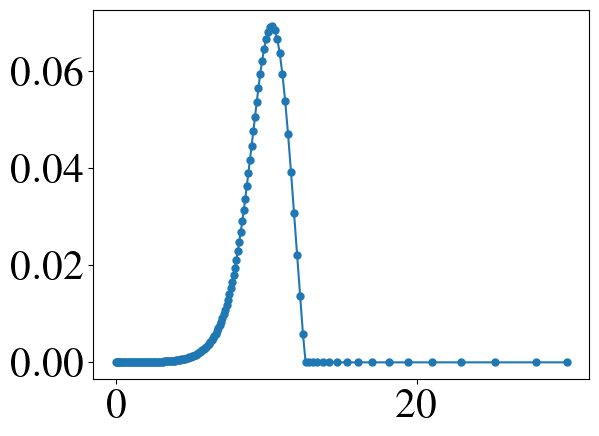

In [10]:
# plt.plot(t_vals_ssn * fault.Tscale / fault.second, np.mean(y_vals_ssn[:,:N_DOFS],axis=1) * fault.Vscale, label='Velocity (ssn)')
# plt.xlabel('Time (s)')
# plt.ylabel('Velocity (m/s)')
# plt.title('Velocity vs Time (SSN)')
# # plt.legend()
# plt.grid()
# plt.show()

# plt.plot(t_vals_ssn * fault.Tscale / fault.second,y_vals_ssn[:,:N_DOFS] * fault.Vscale, label='Velocity (ssn)')
# plt.xlabel('Timemarkert# .ylabel('Velocity (m/s)')
plt# .title('Velocity vs Time (SSN)')
# p# lt.legend()
plt# .grid()
plt# .show()
t_scaled = t_vals_ssn * fault.Tscale / fault.second
mean_vel = np.mean(y_vals_ssn[:, :N_DOFS], axis=1) * fault.Vscale

plt.plot(t_scaled, mean_vel, linestyle='-', color='C0', label='Velocity (ssn)')
plt.scatter(t_scaled, mean_vel, color='C0', s=25)  # one marker per time point

In [12]:
t_vals_ssn[-1] * fault.Tscale / fault.second

np.float64(30.0)

In [13]:
# results = estimate_v_max_range(y0, KS, ES, SIGMA_N, MU_RES, DMU, DC, VINF)
# v_max = results['kb_estimate']
# print(v_max)
# # print(0.07/fault.Vscale)

In [14]:
import numpy as np
# # alpha_reference = 2.0  # legacy default retained for reference
# results = estimate_v_max_range(y0, KS, ES, SIGMA_N, MU_RES, DMU, DC, VINF)
# v_max = results['kb_estimate']
# # print(v_max)


import numpy as np

def build_reward_fn(alpha_value: float):
    """
    Build a reward function parameterized by alpha_value.

    alpha_value controls how harshly we punish numerical error via A = exp(-alpha*E).
    Larger alpha_value => more accuracy-obsessed agent.
    """

    alpha_value = float(alpha_value)

    def my_reward_fn(solver_perf, dt_attempt, xk, env):
        # solver_perf layout from env.increment_env:
        # [ runtime_inc,
        #   dts,
        #   error_LO,
        #   error_lil1,
        #   error_HI,
        #   E,                # global RMS scaled error
        #   success_LO,
        #   success_lil1,
        #   success_HI,
        #   kiter_LO,
        #   iter_lil1,
        #   kiter_HI ]
        (
            runtime_inc,
            dts,
            error_LO,
            error_lil1,
            error_HI,
            E,
            success_LO,
            success_lil1,
            success_HI,
            kiter_LO,
            iter_lil1,
            kiter_HI,
        ) = solver_perf

        # We'll need this a few times
        dt_range = env.dt_max - env.dt_min

        # If the integrator did not advance time (reject / failure path):
        # dts will be 0.0, success flags likely False.
        if dts == 0.0:
            # Penalize requesting a too-large step that got rejected.
            # Normalize dt_attempt to [0,1] and assign negative reward.
            dt_norm_attempt = (dt_attempt - env.dt_min) / dt_range
            # Clip to be safe
            # dt_norm_attempt = float(np.clip(dt_norm_attempt, 0.0, 1.0))
            # print(f" Step rejected. dt_attempt: {dt_attempt}, dt_norm_attempt: {dt_norm_attempt}")
            return -dt_norm_attempt  # more aggressive ask that failed => more negative

        # Otherwise: this step was accepted and advanced time by dts.

        # -----------------
        # S1: step size score
        # -----------------
        # We reward taking a large *accepted* step.
        dt_norm = (dts - env.dt_min) / dt_range
        S1 = float(np.clip(dt_norm, 0.0, 1.0))

        # -----------------
        # S2: runtime score
        # -----------------
        # Track per-step runtime and update the running maximum to normalize S2 dynamically
        if not hasattr(env, 'runtime_history'):
            env.runtime_history = []
        env.runtime_history.append(float(runtime_inc))

        # Maintain a running max runtime seen so far
        if not hasattr(env, 'max_runtime_seen'):
            env.max_runtime_seen = float(runtime_inc)
        else:
            if runtime_inc > env.max_runtime_seen:
                env.max_runtime_seen = float(runtime_inc)
        # track min as well as max
        if not hasattr(env, 'min_runtime_seen'):
            env.min_runtime_seen = float(runtime_inc)
        else:
            if runtime_inc < env.min_runtime_seen:
                env.min_runtime_seen = float(runtime_inc)
        # Compute S2 using the dynamic max; clamp denominator to avoid division by zero
        rt_min =  float(env.min_runtime_seen)
        rt_max = max(rt_min, float(env.max_runtime_seen))
        denom = max(1e-8, rt_max - rt_min)
        S2 = 1 - (float(runtime_inc) - rt_min) / denom

        A = float(np.exp(-alpha_value * E))
        # print(f" S1: {S1}, S2: {S2},  A: {A}")
        # Final reward
        reward = S1 * S2 * A
        return reward

    return my_reward_fn



def build_obs_fn(alpha_value: float):
    """
    Factory that returns an observation function using the SAME alpha as the reward.
    This keeps reward shaping and observation aligned.

    The returned function will be called as:
        obs_fn(dt_attempt, converged, xk, solver_perf, fk, env)

    Where:
      - dt_attempt: the candidate step the agent just asked for (float or None at reset)
      - converged: 1 if the accepted high-accuracy solve succeeded, else 0 (None at reset)
      - xk: current state vector after the env step (or initial state at reset)
      - solver_perf: list of solver diagnostics from env.increment_env(...) (None at reset)
      - fk: current residual (not used here, but passed in by env)
      - env: the AdaptiveStepperEnv instance
    """
    alpha_value = float(alpha_value)

    def my_obs_fn(dt_attempt, converged, xk, solver_perf, fk=None, env=None):
        assert env is not None, "env must be provided by AdaptiveStepperEnv"

        # ------------------------------------------------------------------
        # 1. Extract physics state features from xk
        # ------------------------------------------------------------------
        n = N_DOFS  # assuming N_DOFS is defined in outer scope
        v = xk[:n]          # velocities / slip rates
        u = xk[n:2*n]       # displacements / slips

        avg_v = float(np.mean(v))

        # Internal elastic energy 0.5 * u^T K u
        ks_u = KS @ u       # KS must be defined in outer scope
        E_int = 0.5 * float(np.dot(u, ks_u))

        # Normalize internal energy by Uintc (critical energy), if available and >0
        try:
            if Uintc > 0.0:
                E_norm = float(E_int / Uintc)
            else:
                E_norm = float(E_int)
        except NameError:
            # Fallback if Uintc isn't in scope
            E_norm = float(E_int)

        if solver_perf is not None:
            dts = solver_perf[1]
            conv_flag_bipolar = 1.0 if dts > 0.0 else -1.0
        else:
            conv_flag_bipolar = -1.0
        # ------------------------------------------------------------------
        # 2. Reset branch (env.reset calls us with dt_attempt=None, solver_perf=None)
        # ------------------------------------------------------------------
        if dt_attempt is None or solver_perf is None:
            # We still return a valid 6-D observation vector.
            # Fill in placeholders for solver-derived quantities.
            dt_norm_default = 0.5  # neutral midpoint in [0,1]
            conv_flag = 0.0 if converged is None else float(converged)

            return np.array([
                E_norm,                # elastic energy normalized
                avg_v / (0.07/fault.Vscale),         # avg slip rate normalized (v_max provided externally)
                (env.iter_error / 4.0) if hasattr(env, 'iter_error') else 0.0,
                conv_flag,             # "converged" flag at reset (0 or None -> 0)
                0.0,                   # exp(-alpha * 0) = 1.0 as a neutral accuracy proxy
                conv_flag_bipolar * dt_norm_default,       # normalized dt ~ mid
            ], dtype=np.float64)

        # ------------------------------------------------------------------
        # 3. Normal step branch: unpack solver_perf
        # ------------------------------------------------------------------
        (
            runtime_inc,
            dts,
            error_LO,
            error_lil1,
            error_HI,
            E_global,        # global RMS scaled error (Richardson)
            success_LO,
            success_lil1,
            success_HI,
            kiter_LO,
            iter_lil1,
            kiter_HI,
        ) = solver_perf

        # ------------------------------------------------------------------
        # 4. Normalize dt_attempt into [0,1]
        # ------------------------------------------------------------------
        dt_range = env.dt_max - env.dt_min
        if dt_range <= 0.0:
            dt_norm = 0.0
        else:
            dt_norm = (dt_attempt - env.dt_min) / dt_range
            dt_norm = float(np.clip(dt_norm, 0.0, 1.0))

        # ------------------------------------------------------------------
        # 5. Accuracy proxy, aligned with reward shaping
        # ------------------------------------------------------------------
        # 6. Convergence flag
        # ------------------------------------------------------------------
        # env.step sets converged = 1 if dts > 0 else 0 before calling obs_fn.
        conv_flag = float(converged) if converged is not None else 0.0
        if conv_flag:
            acc = 1/(1 + E_global)
        else:
            # print(f"Not converged step detected in obs_fn.")
            acc = 0.0

        # print(f"E_norm: {E_norm}, avg_v/v_max: {avg_v / v_max}, iter_error: {(env.iter_error / 4.0) if hasattr(env, 'iter_error') else 0.0}, conv_flag: {conv_flag}, acc: {acc}, dt_norm: {dt_norm}")
        # ------------------------------------------------------------------
        # 7. Assemble observation vector
        # ------------------------------------------------------------------
        print(f"observed step {conv_flag_bipolar*dt_norm}")
        return np.array([
            E_norm,                        # normalized elastic energy
            avg_v / (0.07/fault.Vscale),                 # normalized average slip rate
            (env.iter_error / 4.0) if hasattr(env, 'iter_error') else 0.0,
            conv_flag,                     # 1 if high-accuracy solve accepted, else 0
            acc,                   # exp(-alpha * error), same shaping as reward
            conv_flag_bipolar *dt_norm,                       # normalized proposed dt in [0,1]
        ], dtype=np.float64)

    return my_obs_fn


In [15]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
from stable_baselines3.common.callbacks import BaseCallback

class RewardCallback(BaseCallback):
    def __init__(
        self,
        Vscale=1.0,
        Dscale=1.0,
        Tscale=1.0,
        update_freq=50,
        offset_increment=10.0,
        num_envs=1,
        verbose=0,
    ):
        """
        Live training monitor for SB3 in Jupyter.

        Panels per env:
          (0) step-by-step reward trace, with green vertical lines at episode ends
          (1) per-episode return
          (2) avg_v (green, left y) and avg_u (blue, right y) vs physical time t_k1,
              zoomed to last ~2-3 episodes
          (3) steps_per_episode (here we record Sim_time at episode end)

        Vscale, Dscale, Tscale are just multiplicative scalars in case your units
        are nondimensional internally and you want to rescale for plotting.
        """
        super().__init__(verbose)
        self.update_freq = int(update_freq)
        self.offset_increment = float(offset_increment)

        self.Vscale = float(Vscale)  # scales avg_v
        self.Dscale = float(Dscale)  # scales avg_u
        self.Tscale = float(Tscale)  # not currently used in plot, reserved

        # will get overwritten in _init_callback
        self.num_envs = int(num_envs)

        # buffers (will be resized in _init_callback)
        self.rewards = None
        self.episode_rewards = None
        self.current_episode_rewards = None

        self.avg_v_values = None
        self.avg_u_values = None
        self.t_k1_values = None

        self.steps = None
        self.episodes = None
        self.episode_end_steps = None
        self.episode_end_indices = None
        self.current_offsets = None
        self.steps_per_episode = None

        self.fig = None
        self.axs = None     # shape [num_envs][4]
        self.axs2 = None    # list of twin y-axes, len = num_envs

    def _init_callback(self) -> None:
        """Called by SB3 at the beginning of .learn()."""
        # detect actual number of envs from VecEnv
        self.num_envs = getattr(self.training_env, "num_envs", 1)

        # allocate buffers for each env
        self.rewards = [[] for _ in range(self.num_envs)]               # step-wise reward
        self.episode_rewards = [[] for _ in range(self.num_envs)]       # per-episode return
        self.current_episode_rewards = [0.0] * self.num_envs            # running sum this ep

        self.avg_v_values = [[] for _ in range(self.num_envs)]          # avg_v trace
        self.avg_u_values = [[] for _ in range(self.num_envs)]          # avg_u trace
        self.t_k1_values  = [[] for _ in range(self.num_envs)]          # physical time trace (offset per ep)

        self.steps = [0] * self.num_envs
        self.episodes = [0] * self.num_envs

        self.episode_end_steps   = [[] for _ in range(self.num_envs)]   # x-locations of ep ends in panel 0
        self.episode_end_indices = [[] for _ in range(self.num_envs)]   # indices for trimming panel 2
        self.current_offsets     = [0.0] * self.num_envs                # time offset added after each ep
        self.steps_per_episode   = [[] for _ in range(self.num_envs)]   # store Sim_time snapshot at ep end

        # set up figure
        self.fig, self.axs = plt.subplots(self.num_envs, 4, figsize=(25, 5 * self.num_envs))
        if self.num_envs == 1:
            # normalize shape so we can always index axs[i][col]
            self.axs = [self.axs]

        # make twin y-axes for avg_u in panel (2)
        self.axs2 = []
        for i in range(self.num_envs):
            # panel 0: reward vs steps
            self.axs[i][0].set_xlabel("Steps")
            self.axs[i][0].set_ylabel("Reward")
            self.axs[i][0].axhline(y=0, color="r", linestyle="--")

            # panel 1: per-episode return
            self.axs[i][1].set_xlabel("Episodes")
            self.axs[i][1].set_ylabel("Total Reward")

            # panel 2: avg_v / avg_u vs t_k1
            self.axs[i][2].set_xlabel("t_k1")
            self.axs[i][2].set_ylabel("avg_v", color="g")
            self.axs[i][2].tick_params(axis="y", labelcolor="g")
            self.axs[i][2].grid(True)

            # panel 3: steps_per_episode
            self.axs[i][3].set_xlabel("Episodes")
            self.axs[i][3].set_ylabel("Steps per Episode / Sim_time")

            ax2 = self.axs[i][2].twinx()
            ax2.set_ylabel("avg_u", color="b")
            ax2.tick_params(axis="y", labelcolor="b")
            self.axs2.append(ax2)

        display(self.fig)

    def _on_step(self) -> bool:
        """
        Called by SB3 every environment step (actually every rollout collection step).

        We read self.locals["rewards"], self.locals["dones"], self.locals["infos"].
        With VecEnv:
            rewards -> np.array shape (n_envs,)
            dones   -> np.array shape (n_envs,)
            infos   -> list[dict] length n_envs
        With single env:
            they can be scalars/dicts; we wrap them to lists.
        """
        rewards = self.locals["rewards"]
        dones   = self.locals["dones"]
        infos   = self.locals["infos"]

        # unify shape for num_envs==1
        if self.num_envs == 1 and not isinstance(rewards, (list, tuple, np.ndarray)):
            rewards = [rewards]
            dones   = [dones]
            infos   = [infos]

        for i in range(self.num_envs):
            r_i = float(rewards[i])
            self.rewards[i].append(r_i)
            self.current_episode_rewards[i] += r_i
            self.steps[i] += 1

            info_i = infos[i]


            xk = info_i.get("xk", None)
            if xk is not None:
                n = N_DOFS
                v = xk[:n]* self.Vscale
                u = xk[n:2*n]* self.Dscale
            #     mean_vel.append(float(np.mean(v)))
            # mean_slip.append(float(np.mean(u)))

            # # pull diagnostics from env.info
            # # we scaled in env.step(), now we optionally rescale for plotting
            # avg_v_i  = float(info_i.get("avg_v", 0.0)) * self.Vscale
            # avg_u_i  = float(info_i.get("avg_u", 0.0)) * self.Dscale
            t_k1_i   = float(info_i.get("t_k1", 0.0))
            sim_time = float(info_i.get("Sim_time", 0.0))

            # append traces
            self.avg_v_values[i].append(float(np.mean(v)))
            self.avg_u_values[i].append(float(np.mean(u)))
            # add offset to make t_k1 increase monotonically across episodes
            self.t_k1_values[i].append(t_k1_i + self.current_offsets[i])

            # handle episode boundary
            if dones[i]:
                # store episode return
                self.episode_rewards[i].append(self.current_episode_rewards[i])
                # mark step index where this episode ended
                self.episode_end_steps[i].append(len(self.rewards[i]))
                # mark index in avg_v_values so we can "zoom to last 2-3 episodes"
                self.episode_end_indices[i].append(len(self.avg_v_values[i]))

                # snapshot "steps per episode" panel: we're using sim_time here
                self.steps_per_episode[i].append(sim_time)

                # reset accumulators for next ep
                self.current_episode_rewards[i] = 0.0
                self.episodes[i] += 1
                self.steps[i] = 0

                # bump offset so next episode's t_k1 timeline is shifted forward
                if self.t_k1_values[i]:
                    last_t = self.t_k1_values[i][-1]
                    self.current_offsets[i] = last_t + self.offset_increment

        # redraw occasionally
        total_steps_all_envs = sum(self.steps)
        if (total_steps_all_envs % self.update_freq) == 0:
            self._update_plot()

        return True

    def _update_plot(self):
        """Refresh the 4-panel figure for each env."""
        for i in range(self.num_envs):
            # clear each panel
            self.axs[i][0].cla()
            self.axs[i][1].cla()
            self.axs[i][2].cla()
            self.axs2[i].cla()
            self.axs[i][3].cla()

            # (0) reward per step, with episode boundaries
            self.axs[i][0].plot(self.rewards[i], "b-")
            self.axs[i][0].set_xlabel("Steps")
            self.axs[i][0].set_ylabel("Reward")
            self.axs[i][0].axhline(y=0, color="r", linestyle="--")
            for step_idx in self.episode_end_steps[i]:
                self.axs[i][0].axvline(x=step_idx, color="g", linestyle="--")

            # (1) episode return
            if len(self.episode_rewards[i]) > 1:
                self.axs[i][1].plot(
                    self.episode_rewards[i][1:],
                    color="r",
                    marker="o",
                    linestyle="-",
                )
            self.axs[i][1].set_xlabel("Episodes")
            self.axs[i][1].set_ylabel("Total Reward")

            # choose window for panel (2): last ~2-3 episodes
            if len(self.episode_end_indices[i]) >= 3:
                start_index = self.episode_end_indices[i][-3]
            elif len(self.episode_end_indices[i]) == 2:
                start_index = self.episode_end_indices[i][-2]
            else:
                start_index = 0
            end_index = len(self.avg_v_values[i])

            # (2) avg_v vs physical time
            self.axs[i][2].plot(
                self.t_k1_values[i][start_index:end_index],
                self.avg_v_values[i][start_index:end_index],
                color="g",
                marker="o",
                linestyle="-",
                label="avg_v",
            )
            self.axs[i][2].set_xlabel("t_k1")
            self.axs[i][2].set_ylabel("avg_v", color="g")
            self.axs[i][2].tick_params(axis="y", labelcolor="g")
            self.axs[i][2].grid(True)

            # (2 twin) avg_u vs physical time
            self.axs2[i].plot(
                self.t_k1_values[i][start_index:end_index],
                self.avg_u_values[i][start_index:end_index],
                color="b",
                marker="x",
                linestyle="--",
                label="avg_u",
            )
            self.axs2[i].set_ylabel("avg_u", color="b")
            self.axs2[i].tick_params(axis="y", labelcolor="b")

            # combined legend
            lines_1, labels_1 = self.axs[i][2].get_legend_handles_labels()
            lines_2, labels_2 = self.axs2[i].get_legend_handles_labels()
            self.axs[i][2].legend(
                lines_1 + lines_2,
                labels_1 + labels_2,
                loc="upper left",
            )

            # (3) steps_per_episode (we're storing Sim_time snapshots)
            if len(self.steps_per_episode[i]) > 1:
                self.axs[i][3].plot(self.steps_per_episode[i][1:], "b-")
            self.axs[i][3].set_xlabel("Episodes")
            self.axs[i][3].set_ylabel("Steps per Episode / Sim_time")

        clear_output(wait=True)
        display(self.fig)


In [16]:
from Solve_IVP_NS.projections import CoulombProjection
from Solve_IVP_NS.nonlinear_solvers import ImplicitEquationSolver
from Solve_IVP_NS.integrations import CompositeMethod, Trapezoidal
from Solve_IVP_NS.ODESystem import ODESystem
from Solve_IVP_NS.ODESolver import ODESolver
from Solve_IVP_NS.rl.callbacks import CustomMetricsCallback
from gymnasium import spaces
from pathlib import Path
import json
from copy import deepcopy

from stable_baselines3.common.noise import NormalActionNoise, OrnsteinUhlenbeckActionNoise


# Component slices (each DOF separately) and constraint indices (only DOF 0 is constrained)
# Component slice layout
component_slices = [
    slice(0, N_DOFS),
    slice(N_DOFS, 2 * N_DOFS),
    slice(2 * N_DOFS, 3 * N_DOFS)
]
component_slices_solver = [slice(0, 3 * N_DOFS)]  # solver works on full state vector
# For constrained DOF 0 we set rhok=1.0; unconstrained DOF 1 gets 0.
rhok = np.ones(N_DOFS, dtype=float)

# Create the projection operator
projection = CoulombProjection(
    con_force_func=con_force,
    rhok=rhok,
    component_slices=component_slices,
    constraint_indices=np.arange(N_DOFS, dtype=np.int32),
    use_numba=True,  # use Numba acceleration
    jac_func=con_force_jacobian,  # analytical Jacobian for CoulombProjection
)

# Configure the implicit solver
solver_mp = ImplicitEquationSolver(
    method='VI',
    proj=projection,
    component_slices=component_slices,
    tol=solver_opts_ssn.get('tol', 1e-6),
    max_iter=solver_opts_ssn.get('max_iter', 50),
    vi_strict_block_lipschitz=solver_opts_ssn.get("vi_strict_block_lipschitz", False),
    vi_max_block_adjust_iters=solver_opts_ssn.get("vi_max_block_adjust_iters", 10),
)
solver_mp.rhs_jacobian = rhs_jac  # expose analytical RHS Jacobian to integrators

# Use the composite method (which calls the solver internally)
method_mp = CompositeMethod(solver=solver_mp, A=A)



# --- Adaptive RL training over an alpha sweep ---
# Here we iterate over a list of alpha values, train a policy for each,
# and persist the resulting models, normalization stats, and metadata
# into per-alpha subdirectories for easy organization.
dt0 = 1e-3
t0 = t_span[0]
tnmax = t_span[1]
dt_min = 1e-6  # * fault.second / fault.Tscale
dt_max = 30 / 5 * fault.second / fault.Tscale
nparams = (1e-6, 100)

# Define the observation space (here we use the 3 state variables plus 3 extra features regarding solver performance)
obs_dim = 6
obs_space = spaces.Box(low=-np.inf, high=np.inf, shape=(obs_dim,), dtype=np.float64)

# alpha_grid = [0.5, 1.0, 2.0, 4.0, 16.0, 32.0, 128.0]  # customize as desired
alpha_grid = [8.0]  # customize as desired

total_timesteps = 20_000
RUN_ROOT = Path("rl_runs")
RUN_ROOT.mkdir(parents=True, exist_ok=True)

def _alpha_label(alpha_value: float) -> str:
    sign = "m" if alpha_value < 0 else ""
    magnitude = str(abs(alpha_value)).replace(".", "p")
    return f"{sign}{magnitude}"

_base_policy_kwargs = dict(
    activation_fn=th.nn.ReLU,
    net_arch=dict(pi=[64, 64], qf=[64, 64, 64], n_critics=5)
)



In [17]:
reward_callback = RewardCallback(num_envs=1,Vscale = fault.Vscale, Dscale = fault.Dscale, Tscale = fault.Tscale/fault.second, update_freq=100)




## Evaluation: roll out each trained alpha and compare to adaptive integrator

This section loads each trained RL policy from `rl_runs/alpha_*`, runs a rollout on the same fault setup, and plots:
- Average velocity over DOFs vs. time
- Average slip over DOFs vs. time
It also adds the adaptive integrator baseline computed earlier and builds a small runtime table.

Notes:
- No training happens here; we only load saved artifacts.
- We assume models were saved by the training cell into `rl_runs/alpha_<label>/model(.zip)` with optional `vec_norm.pkl`.
- Observation normalization is the same as training (your `my_obs_fn`) and uses per-discretization scalars already defined above.

In [18]:
# from pathlib import Path
# import json
# import numpy as np
# import matplotlib.pyplot as plt
# from sb3_contrib import TQC
# from stable_baselines3 import TD3
# from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize
# import time
# try:
#     import pandas as pd
#     from IPython.display import display
#     _HAVE_PANDAS = True
# except Exception:
#     _HAVE_PANDAS = False

# adaptive_opts = dict(
#     h0=5e-3,
#     h_min=1e-7,
#     h_down=0.6,
#     h_up=1.8,
#     method_order=1,        # p = 1 → nonsmooth first-order scheme, so k = p+1 = 2
#     controller="H211b",   # <--- THIS picks the PI digital filter variant to test
#     b_param=4.0,         # only if controller == "H211b"
#     skip_error_indices=[],
# )

# # Utility: format alpha subfolder names identical to training
# def _alpha_label(alpha_value: float) -> str:
#     sign = "m" if alpha_value < 0 else ""
#     magnitude = str(abs(alpha_value)).replace(".", "p")
#     return f"{sign}{magnitude}"

# RUN_ROOT = Path("TEST_RL_ALPHA_SWEEP").resolve()

# ALGO_REGISTRY = {
#     "TQC": TQC,
#     # "TD3": TD3,
# }

# # Number of 1 for averaging runtime
# N_EVAL_RUNS = 1  # Set to 1 for quick testing, 10 for proper averaging

# # Discover trained runs from disk (alpha_* folders)
# alpha_dirs = sorted([p for p in RUN_ROOT.glob("alpha_*") if p.is_dir()])
# if not alpha_dirs:
#     raise FileNotFoundError(f"No trained runs found under {RUN_ROOT}. Expected folders like alpha_1p0/TQC, alpha_10p0/TD3, ...")
# dt0 = 1e-3

# # Helper to rebuild the same environment used for training
# def make_eval_env(reward_fn, obs_fn, alpha_value: float):
#     return AdaptiveStepperEnv(
#         system=rhs,
#         dt0=dt0,
#         t0=0.0,
#         x0=y0,
#         tnmax=tnmax,
#         dt_min=dt_min,
#         dt_max=dt_max,
#         nparams=nparams,
#         integrator=method_mp,
#         component_slices=component_slices,
#         reward_fn=reward_fn,  # not used in deterministic rollout, but env expects it
#         obs_fn=obs_fn,
#         obs_space=obs_space,
#         verbose=False,
#         # atol=1e-8,
#         # rtol=1e-6,
#         alpha=alpha_value,   # ensure env.alpha is set (for completeness)
# )

# def rollout_policy_on_env(model, vec_env, run_name="(unnamed)"):
#     """
#     Rollout policy using the vec_env (which may have VecNormalize wrapper).
#     """
#     obs = vec_env.reset()
#     times = []
#     mean_vel = []
#     mean_slip = []
#     start = time.time()
    
#     # Repeated-time guard
#     last_t = None
#     repeat_count = 0
#     broke_stuck = False
#     last_converged = None
    
#     # Check if we're dealing with a vectorized env or not
#     is_vectorized = hasattr(vec_env, 'num_envs')
    
#     while True:
#         action, _ = model.predict(obs, deterministic=True)
#         obs, reward, done, info = vec_env.step(action)
        
#         # Handle both vectorized and non-vectorized environments
#         if is_vectorized:
#             # Extract from vec_env wrapper (arrays/lists)
#             done_val = done[0] if isinstance(done, (list, np.ndarray)) else done
#             info_dict = info[0] if isinstance(info, list) else info
#         else:
#             done_val = done
#             info_dict = info
        
#         if done_val:
#             break
            
#         t_now = info_dict.get("t_k1", np.nan)
        
#         # Track last converged flag if provided by env
#         if isinstance(info_dict, dict) and ("converged" in info_dict):
#             last_converged = info_dict.get("converged")
        
#         # Check for repeated time values to avoid infinite loops
#         current_t = None if t_now is None or np.isnan(t_now) else float(t_now)
#         if current_t is not None:
#             if last_t is not None and np.isclose(current_t, last_t, rtol=0.0, atol=1e-12):
#                 repeat_count += 1
#                 if repeat_count >= 20:
#                     print(f"[{run_name}] WARNING: Time stuck at {current_t} for 10 iterations, breaking loop")
#                     broke_stuck = True
#                     break
#             else:
#                 repeat_count = 0  # Reset counter if time advances
#             last_t = current_t
        
#         xk = info_dict.get("xk", None)
#         if xk is not None:
#             n = N_DOFS
#             v = xk[:n]
#             u = xk[n:2*n]
#             times.append(float(t_now))
#             mean_vel.append(float(np.mean(v)))
#             mean_slip.append(float(np.mean(u)))
    
#     wall = time.time() - start
    
#     # Determine success: prefer env-provided converged, else reach tnmax and not stuck
#     # Access the underlying env to get tnmax
#     if hasattr(vec_env, 'venv'):
#         base_env = vec_env.venv.envs[0]
#     elif hasattr(vec_env, 'envs'):
#         base_env = vec_env.envs[0]
#     else:
#         base_env = vec_env
#     tnmax_val = getattr(base_env, 'tnmax', None)
    
#     if last_converged is not None:
#         success = bool(last_converged)
#     else:
#         if len(times) > 0 and tnmax_val is not None:
#             success = (times[-1] >= 0.999 * float(tnmax_val)) and not broke_stuck
#         else:
#             success = not broke_stuck
    
#     # Convert to arrays
#     return np.asarray(times), np.asarray(mean_vel), np.asarray(mean_slip), wall, success

# # Storage for plotting and table
# series = {}  # key -> dict(times, mean_v, mean_u, runtime)

# for alpha_dir in alpha_dirs:
#     algo_dirs = sorted([p for p in alpha_dir.iterdir() if p.is_dir()])
#     if not algo_dirs:
#         print(f"Skipping {alpha_dir.name}: no algorithm runs found")
#         continue
    
#     for algo_dir in algo_dirs:
#         algo_name = algo_dir.name
#         ModelClass = ALGO_REGISTRY.get(algo_name)
#         if ModelClass is None:
#             print(f"Skipping {algo_dir}: unknown algorithm '{algo_name}'")
#             continue
        
#         meta_path = algo_dir / "metadata.json"
#         model_path_zip = algo_dir / "model.zip"
#         model_path_plain = algo_dir / "model"
#         vecnorm_path = algo_dir / "vec_norm.pkl"
        
#         if not meta_path.exists():
#             print(f"Skipping {algo_dir}: missing metadata.json")
#             continue
        
#         with open(meta_path, "r", encoding="utf-8") as fh:
#             meta = json.load(fh)
        
#         alpha_value = float(meta.get("alpha", np.nan))
#         if np.isnan(alpha_value):
#             # Try to parse from parent folder name: alpha_1p0 -> 1.0
#             try:
#                 alabel = alpha_dir.name.split("alpha_")[-1]
#                 alpha_value = float(alabel.replace("p", ".").replace("m", "-"))
#             except Exception:
#                 print(f"Could not infer alpha from {alpha_dir.name}; skipping {algo_dir}")
#                 continue
        
#         key = f"{algo_name} alpha={alpha_value:g}"
#         print(f"Evaluating {key} from {(algo_dir.relative_to(RUN_ROOT))}...")
        
#         # Build reward/obs EXACTLY as training for this alpha
#         reward_fn = build_reward_fn(alpha_value)
#         obs_fn = build_obs_fn(alpha_value)
        
#         # Create env factory with proper closure
#         def make_env_fn(reward_fn=reward_fn, obs_fn=obs_fn, alpha_value=alpha_value):
#             return make_eval_env(reward_fn, obs_fn, alpha_value)
        
#         # Create vec_env with the same structure as training
#         vec_env = DummyVecEnv([make_env_fn])
        
#         # Load VecNormalize if it exists
#         if vecnorm_path.exists():
#             try:
#                 vec_env = VecNormalize.load(str(vecnorm_path), vec_env)
#                 vec_env.training = False  # Ensure we're in eval mode
#                 vec_env.norm_reward = False  # Don't normalize rewards during eval
#                 vec_env.norm_obs = False  # Don't normalize rewards during eval

#             except Exception as e:
#                 print(f"Warning: Failed to load VecNormalize from {vecnorm_path}: {e}")
#                 print("Proceeding without normalization")
#         else:
#             print(f"Warning: No VecNormalize found at {vecnorm_path}, proceeding without normalization")
        
#         # Load model with the vec_env
#         mdl_path = str(model_path_zip) if model_path_zip.exists() else str(model_path_plain)
#         if not Path(mdl_path).exists():
#             print(f"Skipping {algo_dir}: no model found at {model_path_zip} or {model_path_plain}")
#             vec_env.close()
#             continue
        
#         try:
#             model = ModelClass.load(mdl_path, env=vec_env, device="cpu")
#         except Exception as e:
#             print(f"Error loading model from {mdl_path}: {e}")
#             vec_env.close()
#             continue
        
#         # Rollout - average over N_EVAL_RUNS runs for robust runtime measurement
#         try:
#             runtimes = []
#             success_runs = []
#             t_arr_store = None
#             v_mean_store = None
#             u_mean_store = None
            
#             for run_idx in range(N_EVAL_RUNS):
#                 # Reset the environment for each run
#                 vec_env.reset()
#                 t_arr, v_mean, u_mean, wall, success = rollout_policy_on_env(model, vec_env, run_name=f"{key}_run{run_idx}")
#                 runtimes.append(wall)
#                 success_runs.append(bool(success))
#                 if run_idx == 0:
#                     # Store trajectory data from first run only
#                     t_arr_store = t_arr
#                     v_mean_store = v_mean
#                     u_mean_store = u_mean
            
#             avg_runtime = np.mean(runtimes)
#             std_runtime = np.std(runtimes) if len(runtimes) > 1 else 0.0
#             any_success = any(success_runs)
#             success_rate = sum(success_runs) / len(success_runs)
            
#             print(f"Finished {key}: avg_wall={avg_runtime:.3f}s ± {std_runtime:.3f}s, "
#                   f"steps={len(t_arr_store) if t_arr_store is not None else 0}, "
#                   f"t_end={(t_arr_store[-1] if t_arr_store is not None and len(t_arr_store)>0 else 'NA')}, "
#                   f"success_rate={success_rate:.1%} ({sum(success_runs)}/{len(success_runs)})")
            
#             series[key] = {
#                 "times": t_arr_store if t_arr_store is not None else np.array([]),
#                 "mean_v": v_mean_store if v_mean_store is not None else np.array([]),
#                 "mean_u": u_mean_store if u_mean_store is not None else np.array([]),
#                 "runtime_s": float(avg_runtime),
#                 "runtime_std": float(std_runtime),
#                 "converged": bool(any_success),
#                 "success_rate": float(success_rate),
#             }
#         except Exception as e:
#             print(f"FAILED {key}: {e}")
#             import traceback
#             traceback.print_exc()
#         finally:
#             vec_env.close()
#             del vec_env, model

# # Baseline: adaptive integrator
# def adaptive_integrator_baseline():
#     """Run the baseline adaptive integrator N_EVAL_RUNS times for consistent comparison."""
#     runtimes_b = []
#     t_store = None
#     y_store = None
#     success_runs = []
    
#     for run_idx in range(N_EVAL_RUNS):
#         try:
#             start_b = time.time()
#             projection_opts_nb = dict(projection_opts)
#             projection_opts_nb['use_numba'] = True
#             (t_vals_b, y_vals_b, h_vals_b, fk_vals_b, solver_info_b) = Solve_IVP_NS.solve_ivp_ns(
#                 fun=rhs,
#                 t_span=t_span,
#                 y0=y0,
#                 method='composite',
#                 projection='coulomb',
#                 solver='VI',
#                 projection_opts=projection_opts_nb,
#                 solver_opts=solver_opts_ssn,
#                 adaptive=True,
#                 adaptive_opts=adaptive_opts,
#                 # atol=1e-8,
#                 # rtol=1e-6,
#                 h0=adaptive_opts['h0'],
#                 component_slices=component_slices,
#                 verbose=False,
#                 A=A,
#             )
#             wall_b = time.time() - start_b
#             runtimes_b.append(wall_b)
            
#             # Check success
#             success_b = (len(t_vals_b) > 0 and t_vals_b[-1] >= 0.999 * t_span[1])
#             success_runs.append(success_b)
            
#             if run_idx == 0:
#                 # Store trajectory from first run
#                 t_store = t_vals_b
#                 y_store = y_vals_b
#         except Exception as e:
#             print(f"Baseline run {run_idx} failed: {e}")
#             runtimes_b.append(np.nan)
#             success_runs.append(False)
    
#     # Remove failed runs from timing
#     runtimes_b = [r for r in runtimes_b if not np.isnan(r)]
    
#     if len(runtimes_b) == 0:
#         print("WARNING: All baseline runs failed!")
#         return None, None, None, np.nan, np.nan, False
    
#     n = N_DOFS
#     v_b = np.mean(y_store[:, :n], axis=1)
#     u_b = np.mean(y_store[:, n:2*n], axis=1)
#     avg_runtime_b = np.mean(runtimes_b)
#     std_runtime_b = np.std(runtimes_b) if len(runtimes_b) > 1 else 0.0
#     success_rate_b = sum(success_runs) / len(success_runs)
#     any_success_b = any(success_runs)
    
#     print(f"Adaptive integrator: avg_wall={avg_runtime_b:.3f}s ± {std_runtime_b:.3f}s, "
#           f"success_rate={success_rate_b:.1%} ({sum(success_runs)}/{len(success_runs)})")
    
#     return t_store, v_b, u_b, avg_runtime_b, std_runtime_b, any_success_b

# # Run baseline
# try:
#     t_b, v_b, u_b, wall_b, wall_b_std, succ_b = adaptive_integrator_baseline()
#     if t_b is not None:
#         series["adaptive_integrator"] = {
#             "times": np.asarray(t_b),
#             "mean_v": np.asarray(v_b),
#             "mean_u": np.asarray(u_b),
#             "runtime_s": float(wall_b),
#             "runtime_std": float(wall_b_std),
#             "converged": bool(succ_b),
#         }
# except Exception as e:
#     print(f"Baseline evaluation failed: {e}")
#     import traceback
#     traceback.print_exc()

# # Only plot if we have data
# if series:
#     # Plot velocity
#     plt.figure(figsize=(10,6))
#     for name, data in series.items():
#         if len(data["times"]) > 0:
#             t_plot = data["times"] * fault.Tscale / fault.second
#             v_plot = data["mean_v"] * fault.Vscale
#             plt.plot(t_plot, v_plot, label=name)
#     plt.xlabel("Time (s)")
#     plt.ylabel("Average velocity (m/s)")
#     plt.title("Average velocity vs time: RL policies and adaptive integrator")
#     plt.grid(True)
#     plt.legend()
#     plt.show()
    
#     # Plot slip
#     plt.figure(figsize=(10,6))
#     for name, data in series.items():
#         if len(data["times"]) > 0:
#             t_plot = data["times"] * fault.Tscale / fault.second
#             u_plot = data["mean_u"] * fault.Dscale
#             plt.plot(t_plot, u_plot, label=name)
#     plt.xlabel("Time (s)")
#     plt.ylabel("Average slip (m)")
#     plt.title("Average slip vs time: RL policies and adaptive integrator")
#     plt.grid(True)
#     plt.legend()
#     plt.show()
    
#     # Plot runtime vs log10(alpha) — skip non-converged entries
#     from collections import defaultdict
#     runtime_by_algo = defaultdict(list)
#     baseline_runtime = None
    
#     for name, data in series.items():
#         # Extract alpha from the key name (e.g., "TQC alpha=1.0")
#         if "alpha=" in name:
#             parts = name.split("alpha=")
#             algo = parts[0].strip()
#             alpha = float(parts[1])
#             if data.get("converged", True):  # only include converged runs
#                 runtime = data["runtime_s"]
#                 runtime_by_algo[algo].append((alpha, runtime))
#         elif "adaptive_integrator" in name:
#             if data.get("converged", True):
#                 baseline_runtime = data["runtime_s"]
    
#     if runtime_by_algo:
#         plt.figure(figsize=(10, 6))
#         for algo_name, pairs in runtime_by_algo.items():
#             if not pairs:
#                 continue
#             pairs_sorted = sorted(pairs, key=lambda x: x[0])
#             alphas = [p[0] for p in pairs_sorted]
#             runtimes = [p[1] for p in pairs_sorted]
#             plt.plot(np.log10(alphas), runtimes, marker='o', label=algo_name, linewidth=2, markersize=8)
        
#         if baseline_runtime is not None:
#             plt.axhline(baseline_runtime, color='k', linestyle='--', linewidth=2, label='adaptive integrator baseline')
        
#         plt.xlabel("log10(alpha)")
#         plt.ylabel("Runtime (s)")
#         plt.title("Runtime vs log10(alpha): RL policies and adaptive integrator (converged only)")
#         plt.grid(True)
#         plt.legend()
#         plt.show()
    
#     # Runtime table with success rate
#     rows = []
#     for name, data in series.items():
#         row = {
#             "method": name, 
#             "wall_time_s": data["runtime_s"], 
#             "std_s": data.get("runtime_std", 0.0),
#             "converged": data.get("converged", True)
#         }
#         if "success_rate" in data:
#             row["success_rate"] = f"{data['success_rate']:.1%}"
#         rows.append(row)
    
#     if _HAVE_PANDAS:
#         df = pd.DataFrame(rows).sort_values(["converged", "wall_time_s"], ascending=[False, True]).reset_index(drop=True)
#         print("\nRuntime summary (seconds):")
#         display(df)
#     else:
#         print("\nRuntime summary (seconds) — converged first:")
#         for row in sorted(rows, key=lambda r: (not r["converged"], r["wall_time_s"])):
#             tag = " (failed)" if not row["converged"] else ""
#             std_str = f" ± {row['std_s']:.3f}s" if row['std_s'] > 0 else ""
#             success_str = f" (success: {row.get('success_rate', 'N/A')})" if 'success_rate' in row else ""
#             print(f"- {row['method']}: {row['wall_time_s']:.3f}s{std_str}{tag}{success_str}")

In [19]:
# import numpy as np
# import time
# import json
# from pathlib import Path
# import matplotlib.pyplot as plt
# import scipy.sparse as sp

# from gymnasium import spaces
# from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize
# from sb3_contrib import TQC
# # from stable_baselines3 import TD3

# from Solve_IVP_NS.projections import CoulombProjection
# from Solve_IVP_NS.nonlinear_solvers import ImplicitEquationSolver
# from Solve_IVP_NS.integrations import CompositeMethod
# from Solve_IVP_NS.rl.env import AdaptiveStepperEnv
# import Solve_IVP_NS
# from plants.faults import strikeslip

# ###############################################################################
# # Configuration
# ###############################################################################
# ALGO_REGISTRY = {
#     "TQC": TQC,
#     # "TD3": TD3,
# }

# RUN_ROOT = Path("TEST_RL_ALPHA_SWEEP").resolve()
# N_EVAL_RUNS = 5  # Number of evaluation runs for runtime averaging

# # Grid specifications with their specific v_max values
# GRID_SPECS = [
#     # {"Nz": 1, "Nx": 1, "label": "1x1", "v_max": 0.07},  # Training grid
#     {"Nz": 25, "Nx": 25, "label": "25x25", "v_max": 0.07},  # Same v_max as 1x1
#     {"Nz": 50, "Nx": 50, "label": "50x50", "v_max": 0.07},  # Same v_max as 1x1
#     {"Nz": 75, "Nx": 75, "label": "75x75", "v_max": 0.07},  # Same v_max as 1x1
#     {"Nz": 100, "Nx": 100, "label": "100x100", "v_max": 0.07},  # Same v_max as 1x1

#     {"Nz": 50, "Nx": 50, "label": "50x50", "v_max": 0.07},  # Same v_max as 1x1

#     # {"Nz": 5, "Nx": 5, "label": "5x5", "v_max": 0.18},  # Different v_max
# ]

# # Time span (assuming you have this defined globally)
# # t_span = [0.0, your_final_time]

# # Friction parameters (must match training)
# DMU = -0.1
# DC = 100.0  # Will be scaled by fault.Dscale
# MU_RES = 0.5

# ###############################################################################
# # Build fault and solver for a given grid
# ###############################################################################
# def build_fault_and_solver(Nz, Nx):
#     """
#     Build a fault model and solver stack for a given grid size.
#     Returns dict with all necessary components.
#     """

#     # 1. Create fault for this grid
#     fault_local = strikeslip.qs_strikeslip_fault(
#         zdepth=3, xlength=3, Nz=Nz, Nx=Nx,
#         G=30000., rho=2.5e-3, zeta=0.8/3,
#         Ks_path="./Data/", gamma_s=25., gamma_w=10.,
#         sigma_ref=100., depth_ini=0., vinf=3.171e-10,
#         Dmu_estimate=.5,
#     )

#     # 2. Extract plant matrices
#     MA_l, KS_l, ES_l, SIGMA_N_l, VINF_raw_l = fault_local.get_plant()
#     N_DOFS_l = fault_local.N
#     VINF_l = VINF_raw_l * np.ones(N_DOFS_l) * 0  # Set to zero as in your code

#     # 3. Build block diagonal A matrix
#     I_N = sp.eye(N_DOFS_l, format='csr')
#     A_l = sp.block_diag([sp.csr_matrix(MA_l), I_N, I_N], format='csr')

#     # 4. Component slices
#     component_slices_l = [
#         slice(0, N_DOFS_l),              # v
#         slice(N_DOFS_l, 2 * N_DOFS_l),   # u
#         slice(2 * N_DOFS_l, 3 * N_DOFS_l) # s
#     ]

#     # 5. Scaled DC for this grid
#     DC_scaled = DC / fault_local.Dscale

#     # 6. Contact force function
#     def con_force_l(state, fk=None):
#         n = N_DOFS_l
#         slip_hist = state[2*n:3*n]
#         mu_vals = MU_RES * (1 - DMU / MU_RES * np.exp(-slip_hist / DC_scaled))
#         out = np.zeros_like(state)
#         out[:n] = mu_vals * SIGMA_N_l
#         return out

#     # 7. Initial state
#     y0_l = np.zeros(3 * N_DOFS_l)
#     friction_force0 = con_force_l(y0_l)
#     uc = -np.linalg.solve(KS_l, friction_force0[:N_DOFS_l])
#     y0_l[N_DOFS_l:2*N_DOFS_l] = uc * (1.0 + 1e-5)

#     # 8. Critical energy for normalization
#     Uintc_l = 0.5 * float(uc @ (KS_l @ uc))

#     # 9. Projection operator
#     projection_l = CoulombProjection(
#         con_force_func=con_force_l,
#         rhok=np.ones(N_DOFS_l, dtype=float),
#         component_slices=component_slices_l,
#         constraint_indices=list(range(N_DOFS_l)),
#         use_numba=True,
#     )

#     # 10. VI solver

#     # Tuned nonlinear-solver options shared by VI and SSN
#     solver_opts_common = dict(
#         tol=1e-8,
#         max_iter=200,
#     )

#     # Adaptive controller tuned for nonsmooth dynamics
#     adaptive_opts = dict(
#         h0=5e-2,
#         h_min=1e-7,
#         h_down=0.6,
#         h_up=1.8,
#         method_order=1,           # conservative order for nonsmooth dynamics
#         skip_error_indices=[],
#         controller='h211b',              # smoother steps with PI control
#         b_param=4.0,         # only if controller == "H211b"
#         mode = 'ratio'

#     )

#     # SSN-specific tweaks for robustness and speed
#     solver_opts_ssn = dict(solver_opts_common)
#     solver_opts_ssn.update({
#         "vi_strict_block_lipschitz": False,   # was True by default
#         "vi_max_block_adjust_iters": 5,       # smaller safety cap
#         "globalization": 'line_search',    # more robust globalization
#     })
#     solver_mp_l = ImplicitEquationSolver(
#         method='VI',
#         proj=projection_l,
#         component_slices=component_slices_l,
#         tol=solver_opts_ssn.get('tol', 1e-6),
#         max_iter=solver_opts_ssn.get('max_iter', 50),
#         vi_strict_block_lipschitz=solver_opts_ssn.get('vi_strict_block_lipschitz', False),
#         vi_max_block_adjust_iters=solver_opts_ssn.get('vi_max_block_adjust_iters', 10),
#     )

#     # 11. Composite method
#     method_mp_l = CompositeMethod(solver=solver_mp_l, A=A_l)

#     # 12. RHS function
#     def rhs_l(t, y):
#         n = N_DOFS_l
#         v = y[:n]
#         u = y[n:2*n]

#         vdot = -(KS_l @ u) - (ES_l @ (v - VINF_l))
#         udot = v - VINF_l
#         sdot = np.abs(v)
#         return np.concatenate((vdot, udot, sdot))

#     return dict(
#         fault=fault_local,
#         KS=KS_l,
#         ES=ES_l,
#         SIGMA_N=SIGMA_N_l,
#         VINF=VINF_l,
#         N_DOFS=N_DOFS_l,
#         A=A_l,
#         component_slices=component_slices_l,
#         con_force=con_force_l,
#         y0=y0_l,
#         Uintc=Uintc_l,
#         method_mp=method_mp_l,
#         rhs=rhs_l,
#         DC_scaled=DC_scaled,
#         solver_opts_ssn=solver_opts_ssn,
#     )

# ###############################################################################
# # Build observation and reward functions (WITH SIGNED DT_NORM)
# ###############################################################################
# def build_reward_fn(alpha_value: float):
#     """Your existing reward function"""
#     alpha_value = float(alpha_value)

#     def my_reward_fn(solver_perf, dt_attempt, xk, env):
#         (
#             runtime_inc,
#             dts,
#             error_LO,
#             error_lil1,
#             error_HI,
#             E,
#             success_LO,
#             success_lil1,
#             success_HI,
#             kiter_LO,
#             iter_lil1,
#             kiter_HI,
#         ) = solver_perf

#         dt_range = env.dt_max - env.dt_min

#         if dts == 0.0:
#             dt_norm_attempt = (dt_attempt - env.dt_min) / dt_range
#             return -dt_norm_attempt

#         # S1: step size score
#         dt_norm = (dts - env.dt_min) / dt_range
#         S1 = float(np.clip(dt_norm, 0.0, 1.0))

#         # S2: runtime score (simplified version)
#         if not hasattr(env, 'runtime_history'):
#             env.runtime_history = []
#         env.runtime_history.append(float(runtime_inc))

#         if not hasattr(env, 'max_runtime_seen'):
#             env.max_runtime_seen = float(runtime_inc)
#         else:
#             if runtime_inc > env.max_runtime_seen:
#                 env.max_runtime_seen = float(runtime_inc)

#         if not hasattr(env, 'min_runtime_seen'):
#             env.min_runtime_seen = float(runtime_inc)
#         else:
#             if runtime_inc < env.min_runtime_seen:
#                 env.min_runtime_seen = float(runtime_inc)

#         rt_min = float(env.min_runtime_seen)
#         rt_max = max(rt_min, float(env.max_runtime_seen))
#         denom = max(1e-8, rt_max - rt_min)
#         S2 = 1 - (float(runtime_inc) - rt_min) / denom

#         # A: accuracy score
#         A = float(np.exp(-alpha_value * E))

#         reward = S1 * S2 * A
#         return reward

#     return my_reward_fn

# def make_obs_reward(alpha_value, grid, v_max_overr
#         Build observation and reward functions for evaluation.
#     Uses v_max_override for velocity normalization.
#     """
#     reward_fn = build_reward_fn(alpha_value)

#     def obs_fn(dt_attempt, converged, xk, solver_perf, fk=None, env=None):
#         assert env is not None, "env must be provided"

#         # Extract physics state
#         n = grid['N_DOFS']
#         v = xk[:n]
#         u = xk[n:2*n]

#         avg_v = float(np.mean(v))

#         # Elastic energy
#         ks_u = grid['KS'] @ u
#         E_int = 0.5 * float(np.dot(u, ks_u))
#         E_norm = float(E_int / grid['Uintc']) if grid['Uintc'] > 0 else float(E_int)

#         # Bipolar convergence flag for signed dt_norm
#         if solver_perf is not None:
#             dts = solver_perf[1]
#             conv_flag_bipolar = 1.0 if dts > 0.0 else -1.0
#         else:
#             conv_flag_bipolar = -1.0

#         # RESET BRANCH
#         if dt_attempt is None or solver_perf is None:
#             dt_norm_default = 0.5
#             conv_flag = 0.0 if converged is None else float(converged)

#             return np.array([
#                 E_norm,
#                 avg_v / (v_max_override / grid['fault'].Vscale),  # Use override
#                 (env.iter_error / 4.0) if hasattr(env, 'iter_error') else 0.0,
#                 conv_flag,
#                 0.0,  # accuracy proxy neutral
#                 conv_flag_bipolar * dt_norm_default,  # SIGNED!
#             ], dtype=np.float64)

#         # NORMAL STEP BRANCH
#         (
#             runtime_inc,
#             dts,
#             error_LO,
#             error_lil1,
#             error_HI,
#             E_global,
#             success_LO,
#             success_lil1,
#             success_HI,
#             kiter_LO,
#             iter_lil1,
#             kiter_HI,
#         ) = solver_perf

#         # Normalize dt_attempt
#         dt_range = env.dt_max - env.dt_min
#         if dt_range <= 0.0:
#             dt_norm = 0.0
#         else:
#             dt_norm = (dt_attempt - env.dt_min) / dt_range
#             dt_norm = float(np.clip(dt_norm, 0.0, 1.0))

#         # Convergence and accuracy
#         conv_flag = float(converged) if converged is not None else 0.0
#         if conv_flag:
#             acc = 1.0 / (1.0 + E_global)
#         else:
#             acc = 0.0

#         # Return observation with SIGNED dt_norm
#         return np.array([
#             E_norm,
#             avg_v / (v_max_override / grid['fault'].Vscale),  # Use override
#             (env.iter_error / 4.0) if hasattr(env, 'iter_error') else 0.0,
#             conv_flag,
#             acc,
#             conv_flag_bipolar * dt_norm,  # SIGNED!
#         ], dtype=np.float64)

#     return reward_fn, obs_fn

# ###############################################################################
# # Rollout helper
# ###############################################################################
# def rollout_policy_on_vecenv(model, vec_env, run_name="(unnamed)"):
#     """Roll out a policy on a VecEnv and collect trajectory data."""
#     vec_env.training = False
#     vec_env.norm_obs = False
#     vec_env.norm_reward = False

#     base_env = vec_env.venv.envs[0]

#     obs = vec_env.reset()
#     times = []
#     mean_vel = []
#     mean_slip = []

#     last_t = None
#     repeat_count = 0
#     broke_stuck = False
#     last_converged = None
#     last_xk = None

#     start = time.time()
#     done = False

#     while not done:
#         action, _ = model.predict(obs, deterministic=True)
#         obs, rewards, dones, infos = vec_env.step(action)

#         done = bool(dones[0])
#         info = infos[0]

#         t_now = info.get("t_k1", np.nan)
#         xk = info.get("xk", None)
#         if xk is not None:
#             last_xk = xk

#         if "converged" in info:
#             last_converged = info.get("converged")

#         # Check for stuck time
#         current_t = None if t_now is None or np.isnan(t_now) else float(t_now)
#         if current_t is not None:
#             if last_t is not None and current_t == last_t:
#                 repeat_count += 1
#                 if repeat_count >= 10:
#                     print(f"[{run_name}] WARNING: time stuck at {current_t}")
#                     broke_stuck = True
#                     break
#             else:
#                 repeat_count = 0
#             last_t = current_t

#         # Store trajectory data
#         if xk is not None and current_t is not None:
#             n = xk.shape[0] // 3
#             v_block = xk[:n]
#             u_block = xk[n:2*n]
#             times.append(current_t)
#             mean_vel.append(float(np.mean(v_block)))
#             mean_slip.append(float(np.mean(u_block)))

#     wall_time = time.time() - start

#     # Determine success
#     if last_converged is not None:
#         success = bool(last_converged)
#     else:
#         if len(times) > 0 and hasattr(base_env, 'tnmax'):
#             success = (times[-1] >= 0.999 * float(base_env.tnmax)) and not broke_stuck
#         else:
#             success = not broke_stuck

#     # Final slip mean
#     if last_xk is not None:
#         n = last_xk.shape[0] // 3
#         s_block = last_xk[2*n:3*n]
#         s_end_mean = float(np.mean(s_block))
#     else:
#         s_end_mean = np.nan

#     print(f"[{run_name}] Done: wall_time={wall_time:.3f}s, steps={len(times)}, "
#           f"final_t={(times[-1] if len(times)>0 else 'NA'):.3f}, "
#           f"s_end={s_end_mean:.6e}")

#     return (
#         np.asarray(times, dtype=float),
#         np.asarray(mean_vel, dtype=float),
#         np.asarray(mean_slip, dtype=float),
#         float(wall_time),
#         bool(success),
#         s_end_mean,
#     )

# ###############################################################################
# # Evaluate policies on a specific grid
# ###############################################################################
# def evaluate_policies_for_grid(grid, spec, alpha_dirs):
#     """Evaluate all trained policies on a specific grid configuration."""

#     v_max_override = spec['v_max']
#     grid_label = spec['label']

#     # Time step bounds (adjust as needed)
#     local_dt_min = 1e-6
#     local_dt_max = 30 / 5 * grid['fault'].second / grid['fault'].Tscale

#     series = {}

#     for alpha_dir in alpha_dirs:
#         algo_dirs = sorted([p for p in alpha_dir.iterdir() if p.is_dir()])

#         for algo_dir in algo_dirs:
#             algo_name = algo_dir.name
#             ModelClass = ALGO_REGISTRY.get(algo_name)
#             if ModelClass is None:
#                 continue

#             meta_path = algo_dir / "metadata.json"
#             model_path = algo_dir / "model.zip"
#             if not model_path.exists():
#                 model_path = algo_dir / "model"
#             vecnorm_path = algo_dir / "vec_norm.pkl"

#             if not meta_path.exists() or not model_path.exists():
#                 continue

#             with open(meta_path, "r", encoding="utf-8") as fh:
#                 meta = json.load(fh)

#             alpha_value = float(meta.get("alpha", np.nan))
#             if not np.isfinite(alpha_value):
#                 continue

#             # Build reward/obs functions for this grid
#             reward_fn, obs_fn = make_obs_reward(alpha_value, grid, v_max_override)

#             # Environment factory
#             def make_env():
#                 obs_space = spaces.Box(
#                     low=-np.inf,
#                     high=np.inf,
#                     shape=(6,),
#                     dtype=np.float64
#                 )
#                 return AdaptiveStepperEnv(
#                     system=grid['rhs'],
#                     dt0=local_dt_min,
#                     t0=t_span[0],
#                     x0=grid['y0'],
#                     tnmax=t_span[1],
#                     dt_min=local_dt_min,
#                     dt_max=local_dt_max,
#                     nparams=(1e-6, 100),
#                     integrator=grid['method_mp'],
#                     component_slices=grid['component_slices'],
#                     reward_fn=reward_fn,
#                     obs_fn=obs_fn,
#                     obs_space=obs_space,
#                     verbose=False,
#                     alpha=alpha_value,
#                 )

#             # Load model
#             model = ModelClass.load(str(model_path), device="cpu")

#             # Run evaluations
#             runtimes = []
#             success_runs = []
#             slip_end_list = []
#             t_store = None
#             v_store = None
#             u_store = None

#             key = f"{algo_name} alpha={alpha_value:g}"
#             print(f"\nEvaluating {key} on grid {grid_label}...")

#             for run_idx in range(N_EVAL_RUNS):
#                 # Create fresh env for each run
#                 base_vec_env = DummyVecEnv([make_env])

#                 # Load VecNormalize if available
#                 if vecnorm_path.exists():
#                     vec_env = VecNormalize.load(str(vecnorm_path), base_vec_env)
#                     vec_env.training = False
#                     vec_env.norm_obs = False  # Disable since we handle normalization
#                     vec_env.norm_reward = False
#                 else:
#                     vec_env = base_vec_env

#                 # Attach env to model
#                 model.set_env(vec_env)

#                 # Rollout
#                 t_arr, v_mean, u_mean, wall, success, s_end_mean = rollout_policy_on_vecenv(
#                     model, vec_env, run_name=f"{key} run{run_idx}"
#                 )

#                 runtimes.append(wall)
#                 success_runs.append(success)
#                 slip_end_list.append(s_end_mean)

#                 if run_idx == 0:
#                     t_store = t_arr
#                     v_store = v_mean
#                     u_store = u_mean

#                 vec_env.close()

#                 # Stop if first run failed (deterministic policy)
#                 if run_idx == 0 and not success:
#                     break

#             # Record results if any run succeeded
#             if any(success_runs):
#                 times_arr = np.asarray(t_store, dtype=float) if t_store is not None else np.array([], dtype=float)
#                 mean_v_arr = np.asarray(v_store, dtype=float) if v_store is not None else np.array([], dtype=float)
#                 mean_u_arr = np.asarray(u_store, dtype=float) if u_store is not None else np.array([], dtype=float)
#                 finite_slips = [s for s in slip_end_list if np.isfinite(s)]
#                 s_end_mean = float(np.mean(finite_slips)) if finite_slips else float("nan")
#                 series[key] = dict(
#                     times=times_arr,
#                     mean_v=mean_v_arr,
#                     mean_u=mean_u_arr,
#                     runtime_s=float(np.mean(runtimes)),
#                     runtime_std=float(np.std(runtimes)) if len(runtimes) > 1 else 0.0,
#                     converged=True,
#                     success_rate=sum(success_runs) / len(success_runs),
#                     s_end_mean=s_end_mean,
#                 )
#                 print(f"  Success rate: {series[key]['success_rate']:.1%}, "
#                       f"Runtime: {series[key]['runtime_s']:.3f}s ± {series[key]['runtime_std']:.3f}s")

#     return series

# ###############################################################################
# # PI Baseline
# ###############################################################################
# def adaptive_baseline_for_grid(grid, adaptive_opts):
#     """Run classical PI adaptive controller as baseline."""

#     projection_opts_nb = dict(
#         con_force_func=grid['con_force'],
#         rhok=np.ones(grid['N_DOFS'], dtype=float),
#         component_slices=grid['component_slices'],
#         constraint_indices=list(range(grid['N_DOFS'])),
#         use_numba=True,
#     )

#     solver_opts = grid.get('solver_opts_ssn')
#     if solver_opts is None:
#         raise KeyError("Grid dictionary missing 'solver_opts_ssn'. Rebuild grid with build_fault_and_solver().")

#     local_adapt = dict(adaptive_opts)
#     # local_adapt["use_PI"] = True

#     runtimes_b = []
#     success_runs = []
#     slip_end_list = []
#     t_store = None
#     y_store = None

#     for run_idx in range(N_EVAL_RUNS):
#         start_b = time.time()
#         try:
#             (t_vals_b, y_vals_b, h_vals_b, fk_vals_b, solver_info_b) = Solve_IVP_NS.solve_ivp_ns(
#                 fun=grid['rhs'],
#                 t_span=t_span,
#                 y0=grid['y0'],
#                 method='composite',
#                 projection='coulomb',
#                 solver='VI',
#                 projection_opts=projection_opts_nb,
#                 solver_opts=solver_opts,
#                 adaptive=True,
#                 adaptive_opts=local_adapt,
#                 h0=local_adapt.get('h0', 5e-3),
#                 component_slices=grid['component_slices'],
#                 verbose=False,
#                 A=grid['A'],
#             )
#             wall_b = time.time() - start_b

#             success = (len(t_vals_b) > 0 and t_vals_b[-1] >= 0.999 * t_span[1])
#             success_runs.append(success)
#             runtimes_b.append(wall_b)

#             n = grid['N_DOFS']
#             s_final_block = y_vals_b[-1, 2*n:3*n]
#             s_end_mean = float(np.mean(s_final_block))
#             slip_end_list.append(s_end_mean)

#             if run_idx == 0:
#                 t_store = t_vals_b
#                 y_store = y_vals_b

#             print(f"  PI baseline run {run_idx}: {wall_b:.3f}s, success={success}")

#         except Exception as e:
#             print(f"  PI baseline run {run_idx} failed: {e}")
#             success_runs.append(False)

#     if not any(success_runs):
#         print("  WARNING: PI baseline failed all runs")
#         return None

#     runtimes_b = [r for r in runtimes_b if np.isfinite(r)]

#     n = grid['N_DOFS']
#     v_b = np.mean(y_store[:, :n], axis=1)
#     u_b = np.mean(y_store[:, n:2*n], axis=1)

#     return dict(
#         times=np.asarray(t_store, dtype=float) if t_store is not None else np.array([], dtype=float),
#         mean_v=np.asarray(v_b, dtype=float),
#         mean_u=np.asarray(u_b, dtype=float),
#         runtime_s=float(np.mean(runtimes_b)) if runtimes_b else float("nan"),
#         runtime_std=float(np.std(runtimes_b)) if len(runtimes_b) > 1 else 0.0,
#         converged=True,
#         success_rate=sum(success_runs) / len(success_runs),
#         s_end_mean=float(np.mean([s for s in slip_end_list if np.isfinite(s)])) if slip_end_list else float("nan"),
#     )

# ###############################################################################
# # Main Execution
# ###############################################################################
# if __name__ == "__main__":
#     # Discover trained models
#     alpha_dirs = sorted([p for p in RUN_ROOT.glob("alpha_*") if p.is_dir()])
#     if not alpha_dirs:
#         raise FileNotFoundError(f"No trained runs found under {RUN_ROOT}")

#     # PI controller settings
#     adaptive_opts_pi = dict(
#         h0=5e-3,
#         h_min=1e-7,
#         h_down=0.6,
#         h_up=1.8,
#         method_order=1,
#         controller="H211b",
#         b_param=4.0,
#         skip_error_indices=[],
#     )

#     # Results storage
#     all_results = {}

#     # Evaluate on each grid
#     for spec in GRID_SPECS:
#         print(f"\n{'='*60}")
#         print(f"Evaluating on {spec['label']} grid (v_max={spec['v_max']})")
#         print('='*60)

#         # Build grid
#         grid = build_fault_and_solver(spec["Nz"], spec["Nx"])

#         # Evaluate RL policies
#         series = evaluate_policies_for_grid(grid, spec, alpha_dirs)

#         # Evaluate PI baseline
#         print(f"\nRunning PI baseline on {spec['label']}...")
#         baseline = adaptive_baseline_for_grid(grid, adaptive_opts_pi)
#         if baseline is not None:
#             series["PI_baseline"] = baseline

#         all_results[spec['label']] = series

#         # Save results
#         cache_path = Path(f"eval_results_3by3_{spec['label']}.json")

#         scale_t = grid['fault'].Tscale / grid['fault'].second
#         scale_v = grid['fault'].Vscale
#         scale_u = grid['fault'].Dscale

#         # Convert numpy arrays to lists for JSON serialization (scaled to physical units)
#         json_series = {}
#         for key, data in series.items():
#             times = np.asarray(data.get("times", []), dtype=float)
#             mean_v = np.asarray(data.get("mean_v", []), dtype=float)
#             mean_u = np.asarray(data.get("mean_u", []), dtype=float)
#             s_end_mean = data["s_end_mean"] if "s_end_mean" in data else None

#             times_scaled = (times * scale_t).tolist() if times.size > 0 else []
#             mean_v_scaled = (mean_v * scale_v).tolist() if mean_v.size > 0 else []
#             mean_u_scaled = (mean_u * scale_u).tolist() if mean_u.size > 0 else []
#             if s_end_mean is not None and np.isfinite(s_end_mean):
#                 s_end_mean_scaled = float(s_end_mean) * scale_u
#             else:
#                 s_end_mean_scaled = None

#             json_series[key] = {
#                 "times": times_scaled,
#                 "mean_v": mean_v_scaled,
#                 "mean_u": mean_u_scaled,
#                 "runtime_s": data.get("runtime_s", float("nan")),
#                 "runtime_std": data.get("runtime_std", 0.0),
#                 "converged": data.get("converged", False),
#                 "success_rate": data.get("success_rate", 1.0),
#                 "s_end_mean": s_end_mean_scaled,
#             }

#         with open(cache_path, "w") as f:
#             json.dump(json_series, f, indent=2)
#         print(f"Saved results to {cache_path}")

#     # Plot mean velocity trajectories for each grid (scaled to physical units)
#     for spec in GRID_SPECS:
#         series = all_results.get(spec['label'], {})
#         if not series:
#             continue

#         fault_obj = build_fault_and_solver(spec["Nz"], spec["Nx"])['fault']
#         scale_t = fault_obj.Tscale / fault_obj.second
#         scale_v = fault_obj.Vscale

#         plt.figure(figsize=(10, 6))
#         plotted = False
#         for name, data in series.items():
#             times = np.asarray(data.get("times", []), dtype=float)
#             mean_v = np.asarray(data.get("mean_v", []), dtype=float)
#             if times.size == 0 or mean_v.size == 0:
#                 continue

#             plt.plot(times, mean_v, label=name)
#             plotted = True

#         if not plotted:
#             plt.close()
#             continue

#         plt.xlabel("Time")
#         plt.ylabel("Mean velocity")
#         plt.title(f"Mean velocity vs time ({spec['label']} grid)")
#         plt.grid(True, alpha=0.3)
#         plt.legend()
#         plt.tight_layout()

#         out_path = Path(f"mean_velocity_{spec['label']}.png")
#         plt.savefig(out_path, dpi=150, bbox_inches='tight')
#         print(f"Saved velocity plot to {out_path}")
#         plt.show()

#     print("\n" + "="*60)
#     print("EVALUATION COMPLETE")
#     print("="*60)


In [20]:
# import numpy as np
# import time
# import json
# from pathlib import Path
# import matplotlib.pyplot as plt
# import scipy.sparse as sp

# from gymnasium import spaces
# from stable_baselines3 import TD3            # for RL_TD3_ONLY mode
# # from sb3_contrib import TQC               # not used here
# from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize

# from Solve_IVP_NS.projections import CoulombProjection
# from Solve_IVP_NS.nonlinear_solvers import ImplicitEquationSolver
# from Solve_IVP_NS.integrations import CompositeMethod
# from Solve_IVP_NS.rl.env import AdaptiveStepperEnv
# import Solve_IVP_NS
# from plants.faults import strikeslip

# # ============================
# # Select what to run
# # ============================
# MODE = "PI_ONLY"        # options: "PI_ONLY", "RL_TD3_ONLY"
# RUN_ROOT = Path("TEST_RL_ALPHA_SWEEP").resolve()
# N_EVAL_RUNS = 2

# # ----------------------------
# # Required: provide your time span here
# # ----------------------------
# # Example (replace with yours):
# # t_span = [0.0, 40.0]   # nondimensional end time used in your runs
# # t_span = [0.0, 30.0]

# # ============================
# # Grids and model physics
# # ============================
# GRID_SPECS = [
#     {"Nz": 25, "Nx": 25, "label": "25x25", "v_max": 0.07},
#     {"Nz": 50, "Nx": 50, "label": "50x50", "v_max": 0.07},
#     {"Nz": 75, "Nx": 75, "label": "75x75", "v_max": 0.07},
#     # {"Nz": 100, "Nx": 100, "label": "100x100", "v_max": 0.07},
# ]

# DMU = -0.1
# DC = 100.0
# MU_RES = 0.5

# def build_fault_and_solver(Nz, Nx):
#     fault_local = strikeslip.qs_strikeslip_fault(
#         zdepth=5, xlength=5, Nz=Nz, Nx=Nx,
#         G=30000., rho=2.5e-3, zeta=0.8/3,
#         Ks_path="./Data/", gamma_s=25., gamma_w=10.,
#         sigma_ref=100., depth_ini=0., vinf=3.171e-10,
#         Dmu_estimate=.5,
#     )
#     MA_l, KS_l, ES_l, SIGMA_N_l, VINF_raw_l = fault_local.get_plant()
#     N_DOFS_l = fault_local.N
#     VINF_l = VINF_raw_l * np.ones(N_DOFS_l) * 0

#     I_N = sp.eye(N_DOFS_l, format='csr')
#     A_l = sp.block_diag([sp.csr_matrix(MA_l), I_N, I_N], format='csr')

#     component_slices_l = [
#         slice(0, N_DOFS_l),
#         slice(N_DOFS_l, 2 * N_DOFS_l),
#         slice(2 * N_DOFS_l, 3 * N_DOFS_l),
#     ]

#     DC_scaled = DC / fault_local.Dscale

#     def con_force_l(state, fk=None):
#         n = N_DOFS_l
#         slip_hist = state[2*n:3*n]
#         mu_vals = MU_RES * (1 - DMU / MU_RES * np.exp(-slip_hist / DC_scaled))
#         out = np.zeros_like(state)
#         out[:n] = mu_vals * SIGMA_N_l
#         return out

#     y0_l = np.zeros(3 * N_DOFS_l)
#     friction_force0 = con_force_l(y0_l)
#     uc = -np.linalg.solve(KS_l, friction_force0[:N_DOFS_l])
#     y0_l[N_DOFS_l:2*N_DOFS_l] = uc * (1.0 + 1e-5)
#     Uintc_l = 0.5 * float(uc @ (KS_l @ uc))

#     projection_l = CoulombProjection(
#         con_force_func=con_force_l,
#         rhok=np.ones(N_DOFS_l, dtype=float),
#         component_slices=component_slices_l,
#         constraint_indices=list(range(N_DOFS_l)),
#         use_numba=True,
#     )

#     solver_opts_ssn = dict(
#         tol=1e-8,
#         max_iter=200,
#         vi_strict_block_lipschitz=False,
#         vi_max_block_adjust_iters=5,
#         globalization='line_search',
#     )

#     solver_mp_l = ImplicitEquationSolver(
#         method='VI',
#         proj=projection_l,
#         component_slices=component_slices_l,
#         tol=solver_opts_ssn.get('tol', 1e-6),
#         max_iter=solver_opts_ssn.get('max_iter', 50),
#         vi_strict_block_lipschitz=solver_opts_ssn.get('vi_strict_block_lipschitz', False),
#         vi_max_block_adjust_iters=solver_opts_ssn.get('vi_max_block_adjust_iters', 10),
#     )
#     method_mp_l = CompositeMethod(solver=solver_mp_l, A=A_l)

#     def rhs_l(t, y):
#         n = N_DOFS_l
#         v = y[:n]
#         u = y[n:2*n]
#         vdot = -(KS_l @ u) - (ES_l @ (v - VINF_l))
#         udot = v - VINF_l
#         sdot = np.abs(v)
#         return np.concatenate((vdot, udot, sdot))

#     return dict(
#         fault=fault_local, KS=KS_l, ES=ES_l, SIGMA_N=SIGMA_N_l, VINF=VINF_l,
#         N_DOFS=N_DOFS_l, A=A_l, component_slices=component_slices_l,
#         con_force=con_force_l, y0=y0_l, Uintc=Uintc_l, method_mp=method_mp_l,
#         rhs=rhs_l, DC_scaled=DC_scaled, solver_opts_ssn=solver_opts_ssn
#     )

# # ============================
# # PI baseline runner
# # ============================
# def adaptive_baseline_for_grid(grid, adaptive_opts, n_runs=N_EVAL_RUNS):
#     projection_opts_nb = dict(
#         con_force_func=grid['con_force'],
#         rhok=np.ones(grid['N_DOFS'], dtype=float),
#         component_slices=grid['component_slices'],
#         constraint_indices=list(range(grid['N_DOFS'])),
#         use_numba=True,
#     )
#     solver_opts = grid.get('solver_opts_ssn')

#     local_adapt = dict(adaptive_opts)

#     runtimes_b = []
#     success_runs = []
#     slip_end_list = []
#     t_store = None
#     y_store = None

#     for run_idx in range(n_runs):
#         start_b = time.time()
#         try:
#             t_vals_b, y_vals_b, h_vals_b, fk_vals_b, solver_info_b = Solve_IVP_NS.solve_ivp_ns(
#                 fun=grid['rhs'], t_span=t_span, y0=grid['y0'],
#                 method='composite', projection='coulomb', solver='VI',
#                 projection_opts=projection_opts_nb, solver_opts=solver_opts,
#                 adaptive=True, adaptive_opts=local_adapt,
#                 h0=local_adapt.get('h0', 5e-3),
#                 component_slices=grid['component_slices'],
#                 verbose=False, A=grid['A'],
#             )
#             wall_b = time.time() - start_b

#             success = (len(t_vals_b) > 0 and t_vals_b[-1] >= 0.999 * t_span[1])
#             success_runs.append(success)
#             runtimes_b.append(wall_b)

#             n = grid['N_DOFS']
#             s_final_block = y_vals_b[-1, 2*n:3*n]
#             s_end_mean = float(np.mean(s_final_block))
#             slip_end_list.append(s_end_mean)

#             if run_idx == 0:
#                 t_store = t_vals_b
#                 y_store = y_vals_b

#             print(f"  PI baseline run {run_idx}: {wall_b:.3f}s, success={success}")

#         except Exception as e:
#             print(f"  PI baseline run {run_idx} failed: {e}")
#             success_runs.append(False)

#     if not any(success_runs):
#         print("  WARNING: PI baseline failed all runs")
#         return None

#     runtimes_b = [r for r in runtimes_b if np.isfinite(r)]

#     n = grid['N_DOFS']
#     v_b = np.mean(y_store[:, :n], axis=1)
#     u_b = np.mean(y_store[:, n:2*n], axis=1)

#     return dict(
#         times=np.asarray(t_store, dtype=float) if t_store is not None else np.array([], dtype=float),
#         mean_v=np.asarray(v_b, dtype=float),
#         mean_u=np.asarray(u_b, dtype=float),
#         runtime_s=float(np.mean(runtimes_b)) if runtimes_b else float("nan"),
#         runtime_std=float(np.std(runtimes_b)) if len(runtimes_b) > 1 else 0.0,
#         converged=True,
#         success_rate=sum(success_runs) / len(success_runs),
#         s_end_mean=float(np.mean([s for s in slip_end_list if np.isfinite(s)])) if slip_end_list else float("nan"),
#     )

# # ============================
# # RL evaluation (TD3 only)
# # ============================
# def make_obs_reward(alpha_value, grid, v_max_override):
#     def build_reward_fn(alpha_value: float):
#         alpha_value = float(alpha_value)
#         def my_reward_fn(solver_perf, dt_attempt, xk, env):
#             (runtime_inc, dts, err_LO, err_l1, err_HI, E, sLO, sl1, sHI, kLO, kL1, kHI) = solver_perf
#             dt_range = env.dt_max - env.dt_min
#             if dts == 0.0:
#                 dt_norm_attempt = (dt_attempt - env.dt_min) / dt_range
#                 return -dt_norm_attempt
#             dt_norm = (dts - env.dt_min) / dt_range
#             S1 = float(np.clip(dt_norm, 0.0, 1.0))
#             if not hasattr(env, 'runtime_history'): env.runtime_history = []
#             env.runtime_history.append(float(runtime_inc))
#             if not hasattr(env, 'max_runtime_seen'): env.max_runtime_seen = float(runtime_inc)
#             else: env.max_runtime_seen = max(env.max_runtime_seen, float(runtime_inc))
#             if not hasattr(env, 'min_runtime_seen'): env.min_runtime_seen = float(runtime_inc)
#             else: env.min_runtime_seen = min(env.min_runtime_seen, float(runtime_inc))
#             rt_min = float(env.min_runtime_seen); rt_max = max(rt_min, float(env.max_runtime_seen))
#             denom = max(1e-8, rt_max - rt_min)
#             S2 = 1 - (float(runtime_inc) - rt_min) / denom
#             A = float(np.exp(-alpha_value * E))
#             return S1 * S2 * A
#         return my_reward_fn

#     reward_fn = build_reward_fn(alpha_value)

#     def obs_fn(dt_attempt, converged, xk, solver_perf, fk=None, env=None):
#         assert env is not None
#         n = grid['N_DOFS']
#         v = xk[:n]
#         u = xk[n:2*n]
#         avg_v = float(np.mean(v))
#         ks_u = grid['KS'] @ u
#         E_int = 0.5 * float(np.dot(u, ks_u))
#         E_norm = float(E_int / grid['Uintc']) if grid['Uintc'] > 0 else float(E_int)
#         if solver_perf is not None:
#             dts = solver_perf[1]
#             conv_flag_bipolar = 1.0 if dts > 0.0 else -1.0
#         else:
#             conv_flag_bipolar = -1.0

#         if dt_attempt is None or solver_perf is None:
#             dt_norm_default = 0.5
#             conv_flag = 0.0 if converged is None else float(converged)
#             return np.array([
#                 E_norm,
#                 avg_v / (v_max_override / grid['fault'].Vscale),
#                 (env.iter_error / 4.0) if hasattr(env, 'iter_error') else 0.0,
#                 conv_flag, 0.0,
#                 conv_flag_bipolar * dt_norm_default,
#             ], dtype=np.float64)

#         (runtime_inc, dts, err_LO, err_l1, err_HI, E_global, sLO, sl1, sHI, kLO, kL1, kHI) = solver_perf
#         dt_range = env.dt_max - env.dt_min
#         dt_norm = (dt_attempt - env.dt_min) / dt_range if dt_range > 0 else 0.0
#         dt_norm = float(np.clip(dt_norm, 0.0, 1.0))
#         conv_flag = float(converged) if converged is not None else 0.0
#         acc = 1.0 / (1.0 + E_global) if conv_flag else 0.0

#         return np.array([
#             E_norm,
#             avg_v / (v_max_override / grid['fault'].Vscale),
#             (env.iter_error / 4.0) if hasattr(env, 'iter_error') else 0.0,
#             conv_flag, acc,
#             conv_flag_bipolar * dt_norm,
#         ], dtype=np.float64)

#     return reward_fn, obs_fn

# def rollout_policy_on_vecenv(model, vec_env, run_name="(unnamed)"):
#     vec_env.training = False
#     vec_env.norm_obs = False
#     vec_env.norm_reward = False
#     base_env = vec_env.venv.envs[0] if hasattr(vec_env, "venv") else vec_env.envs[0]

#     obs = vec_env.reset()
#     times, mean_vel, mean_slip = [], [], []
#     last_t, repeat_count, broke_stuck = None, 0, False
#     last_converged, last_xk = None, None
#     start = time.time(); done = False

#     while not done:
#         action, _ = model.predict(obs, deterministic=True)
#         obs, rewards, dones, infos = vec_env.step(action)
#         done = bool(dones[0]); info = infos[0]
#         t_now = info.get("t_k1", np.nan)
#         xk = info.get("xk", None)
#         if xk is not None: last_xk = xk
#         if "converged" in info: last_converged = info.get("converged")

#         current_t = None if t_now is None or np.isnan(t_now) else float(t_now)
#         if current_t is not None:
#             if last_t is not None and np.isclose(current_t, last_t, rtol=0.0, atol=1e-12):
#                 repeat_count += 1
#                 if repeat_count >= 10:
#                     print(f"[{run_name}] WARNING: time stuck at {current_t}")
#                     broke_stuck = True; break
#             else:
#                 repeat_count = 0
#             last_t = current_t

#         if xk is not None and current_t is not None:
#             n = xk.shape[0] // 3
#             v_block = xk[:n]; u_block = xk[n:2*n]
#             times.append(current_t)
#             mean_vel.append(float(np.mean(v_block)))
#             mean_slip.append(float(np.mean(u_block)))

#     wall_time = time.time() - start
#     if last_converged is not None:
#         success = bool(last_converged)
#     else:
#         success = (len(times) > 0 and hasattr(base_env, 'tnmax') and times[-1] >= 0.999 * float(base_env.tnmax)) and not broke_stuck

#     if last_xk is not None:
#         n = last_xk.shape[0] // 3
#         s_block = last_xk[2*n:3*n]
#         s_end_mean = float(np.mean(s_block))
#     else:
#         s_end_mean = np.nan

#     print(f"[{run_name}] Done: wall_time={wall_time:.3f}s, steps={len(times)}, final_t={(times[-1] if len(times)>0 else float('nan')):.3f}, s_end={s_end_mean:.6e}")
#     return (np.asarray(times, float), np.asarray(mean_vel, float), np.asarray(mean_slip, float),
#             float(wall_time), bool(success), s_end_mean)

# def evaluate_td3_for_grid(grid, spec, alpha_dirs):
#     v_max_override = spec['v_max']; grid_label = spec['label']
#     local_dt_min = 1e-6
#     local_dt_max = 30 / 5 * grid['fault'].second / grid['fault'].Tscale
#     series = {}

#     for alpha_dir in alpha_dirs:
#         algo_dirs = sorted([p for p in alpha_dir.iterdir() if p.is_dir()])
#         for algo_dir in algo_dirs:
#             algo_name = algo_dir.name
#             if algo_name != "TD3":
#                 continue  # skip everything except TD3

#             meta_path = algo_dir / "metadata.json"
#             model_path = algo_dir / "model.zip"
#             if not model_path.exists():
#                 model_path = algo_dir / "model"
#             vecnorm_path = algo_dir / "vec_norm.pkl"
#             if not meta_path.exists() or not model_path.exists():
#                 continue

#             with open(meta_path, "r", encoding="utf-8") as fh:
#                 meta = json.load(fh)
#             alpha_value = float(meta.get("alpha", np.nan))
#             if not np.isfinite(alpha_value):
#                 continue

#             reward_fn, obs_fn = make_obs_reward(alpha_value, grid, v_max_override)

#             def make_env():
#                 obs_space = spaces.Box(low=-np.inf, high=np.inf, shape=(6,), dtype=np.float64)
#                 return AdaptiveStepperEnv(
#                     system=grid['rhs'], dt0=local_dt_min, t0=t_span[0], x0=grid['y0'], tnmax=t_span[1],
#                     dt_min=local_dt_min, dt_max=local_dt_max, nparams=(1e-6, 100),
#                     integrator=grid['method_mp'], component_slices=grid['component_slices'],
#                     reward_fn=reward_fn, obs_fn=obs_fn, obs_space=obs_space, verbose=False, alpha=alpha_value,
#                 )

#             model = TD3.load(str(model_path), device="cpu")

#             runtimes, success_runs, slip_end_list = [], [], []
#             t_store = v_store = u_store = None
#             key = f"{algo_name} alpha={alpha_value:g}"
#             print(f"\nEvaluating {key} on grid {grid_label}...")

#             for run_idx in range(N_EVAL_RUNS):
#                 base_vec_env = DummyVecEnv([make_env])
#                 if vecnorm_path.exists():
#                     vec_env = VecNormalize.load(str(vecnorm_path), base_vec_env)
#                     vec_env.training = False; vec_env.norm_obs = False; vec_env.norm_reward = False
#                 else:
#                     vec_env = base_vec_env
#                 model.set_env(vec_env)

#                 t_arr, v_mean, u_mean, wall, success, s_end_mean = rollout_policy_on_vecenv(
#                     model, vec_env, run_name=f"{key} run{run_idx}"
#                 )
#                 runtimes.append(wall); success_runs.append(success); slip_end_list.append(s_end_mean)
#                 if run_idx == 0: t_store, v_store, u_store = t_arr, v_mean, u_mean
#                 vec_env.close()
#                 if run_idx == 0 and not success: break

#             if any(success_runs):
#                 times_arr = np.asarray(t_store, float) if t_store is not None else np.array([], float)
#                 mean_v_arr = np.asarray(v_store, float) if v_store is not None else np.array([], float)
#                 mean_u_arr = np.asarray(u_store, float) if u_store is not None else np.array([], float)
#                 finite_slips = [s for s in slip_end_list if np.isfinite(s)]
#                 s_end_mean = float(np.mean(finite_slips)) if finite_slips else float("nan")
#                 series[key] = dict(
#                     times=times_arr, mean_v=mean_v_arr, mean_u=mean_u_arr,
#                     runtime_s=float(np.mean(runtimes)), runtime_std=float(np.std(runtimes)) if len(runtimes) > 1 else 0.0,
#                     converged=True, success_rate=sum(success_runs)/len(success_runs), s_end_mean=s_end_mean,
#                 )
#                 print(f"  Success rate: {series[key]['success_rate']:.1%}, Runtime: {series[key]['runtime_s']:.3f}s ± {series[key]['runtime_std']:.3f}s")
#     return series

# # ============================
# # Serialization helper (scales to physical units like your original)
# # ============================
# def save_series_json(series: dict, grid: dict, out_path: Path):
#     scale_t = grid['fault'].Tscale / grid['fault'].second
#     scale_v = grid['fault'].Vscale
#     scale_u = grid['fault'].Dscale

#     json_series = {}
#     for key, data in series.items():
#         times = np.asarray(data.get("times", []), float)
#         mean_v = np.asarray(data.get("mean_v", []), float)
#         mean_u = np.asarray(data.get("mean_u", []), float)
#         s_end_mean = data.get("s_end_mean", None)

#         json_series[key] = {
#             "times": (times * scale_t).tolist() if times.size else [],
#             "mean_v": (mean_v * scale_v).tolist() if mean_v.size else [],
#             "mean_u": (mean_u * scale_u).tolist() if mean_u.size else [],
#             "runtime_s": data.get("runtime_s", float("nan")),
#             "runtime_std": data.get("runtime_std", 0.0),
#             "converged": data.get("converged", False),
#             "success_rate": data.get("success_rate", 1.0),
#             "s_end_mean": (float(s_end_mean) * scale_u) if (s_end_mean is not None and np.isfinite(s_end_mean)) else None,
#         }

#     with open(out_path, "w") as f:
#         json.dump(json_series, f, indent=2)
#     print(f"Saved results to {out_path}")

# # ============================
# # Main
# # ============================
# if __name__ == "__main__":
#     assert MODE in {"PI_ONLY", "RL_TD3_ONLY"}, "MODE must be 'PI_ONLY' or 'RL_TD3_ONLY'"

#     # PI controller settings (unchanged)
#     adaptive_opts_pi = dict(
#         h0=5e-3, h_min=1e-7, h_down=0.6, h_up=1.8, method_order=1,mode="ratio",
#         controller="H211b", b_param=4.0, skip_error_indices=[],
#     )

#     # If RL mode: find alpha_* dirs
#     alpha_dirs = []
#     if MODE == "RL_TD3_ONLY":
#         alpha_dirs = sorted([p for p in RUN_ROOT.glob("alpha_*") if p.is_dir()])
#         if not alpha_dirs:
#             raise FileNotFoundError(f"No trained runs found under {RUN_ROOT}")

#     # Per-grid evaluation
#     for spec in GRID_SPECS:
#         print(f"\n{'='*60}\nEvaluating on {spec['label']} grid (v_max={spec['v_max']})\n{'='*60}")
#         grid = build_fault_and_solver(spec["Nz"], spec["Nx"])

#         series = {}

#         if MODE == "PI_ONLY":
#             print(f"\nRunning PI baseline on {spec['label']}...")
#             baseline = adaptive_baseline_for_grid(grid, adaptive_opts_pi)
#             if baseline is not None:
#                 # save only PI under PI_baseline key so downstream code remains compatible
#                 series["PI_baseline"] = baseline
#             out_file = Path(f"eval_results_PI_{spec['label']}.json")
#             save_series_json(series, grid, out_file)

#         elif MODE == "RL_TD3_ONLY":
#             # Evaluate TD3 only (no PI)
#             series = evaluate_td3_for_grid(grid, spec, alpha_dirs)
#             out_file = Path(f"eval_results_TD3_{spec['label']}.json")
#             save_series_json(series, grid, out_file)

#     print("\n" + "="*60 + f"\nEVALUATION COMPLETE ({MODE})\n" + "="*60)


In [21]:
# import numpy as np
# import time
# import json
# from pathlib import Path
# import matplotlib.pyplot as plt
# import scipy.sparse as sp

# from gymnasium import spaces
# from stable_baselines3 import TD3
# from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize
# from sb3_contrib import TQC

# from Solve_IVP_NS.projections import CoulombProjection
# from Solve_IVP_NS.nonlinear_solvers import ImplicitEquationSolver
# from Solve_IVP_NS.integrations import CompositeMethod
# from Solve_IVP_NS.rl.env import AdaptiveStepperEnv
# import Solve_IVP_NS
# from plants.faults import strikeslip

# # ============================
# # Select what to run
# # ============================
# MODE = "RESUMED_ONLY"   # options: "PI_ONLY", "RL_TD3_ONLY", "RESUMED_ONLY"
# RUN_ROOT = Path("TEST_RL_ALPHA_SWEEP").resolve()
# N_EVAL_RUNS = 5

# # ----------------------------
# # Time span for simulations
# # ----------------------------
# # t_span = [0.0, 30.0]

# # ============================
# # Grids and model physics
# # ============================
# GRID_SPECS = [
#     {"Nz": 25, "Nx": 25, "label": "25x25", "v_max": 0.07},
#     {"Nz": 50, "Nx": 50, "label": "50x50", "v_max": 0.07},
#     {"Nz": 75, "Nx": 75, "label": "75x75", "v_max": 0.07},
#     # {"Nz": 100, "Nx": 100, "label": "100x100", "v_max": 0.07},
# ]

# DMU = -0.1
# DC = 100.0
# MU_RES = 0.5

# MODEL_CLASS_MAP = {
#     "TQC": TQC,
#     "TD3": TD3,
# }

# # ============================
# # Build fault and solver per grid
# # ============================
# def build_fault_and_solver(Nz, Nx):
#     fault_local = strikeslip.qs_strikeslip_fault(
#         zdepth=3, xlength=3, Nz=Nz, Nx=Nx,
#         G=30000., rho=2.5e-3, zeta=0.8/3,
#         Ks_path="./Data/", gamma_s=25., gamma_w=10.,
#         sigma_ref=100., depth_ini=0., vinf=3.171e-10,
#         Dmu_estimate=.5,
#     )
#     MA_l, KS_l, ES_l, SIGMA_N_l, VINF_raw_l = fault_local.get_plant()
#     N_DOFS_l = fault_local.N
#     VINF_l = VINF_raw_l * np.ones(N_DOFS_l) * 0

#     I_N = sp.eye(N_DOFS_l, format='csr')
#     A_l = sp.block_diag([sp.csr_matrix(MA_l), I_N, I_N], format='csr')

#     component_slices_l = [
#         slice(0, N_DOFS_l),
#         slice(N_DOFS_l, 2 * N_DOFS_l),
#         slice(2 * N_DOFS_l, 3 * N_DOFS_l),
#     ]

#     DC_scaled = DC / fault_local.Dscale

#     def con_force_l(state, fk=None):
#         n = N_DOFS_l
#         slip_hist = state[2*n:3*n]
#         mu_vals = MU_RES * (1 - DMU / MU_RES * np.exp(-slip_hist / DC_scaled))
#         out = np.zeros_like(state)
#         out[:n] = mu_vals * SIGMA_N_l
#         return out

#     y0_l = np.zeros(3 * N_DOFS_l)
#     friction_force0 = con_force_l(y0_l)
#     uc = -np.linalg.solve(KS_l, friction_force0[:N_DOFS_l])
#     y0_l[N_DOFS_l:2*N_DOFS_l] = uc * (1.0 + 1e-5)
#     Uintc_l = 0.5 * float(uc @ (KS_l @ uc))

#     projection_l = CoulombProjection(
#         con_force_func=con_force_l,
#         rhok=np.ones(N_DOFS_l, dtype=float),
#         component_slices=component_slices_l,
#         constraint_indices=list(range(N_DOFS_l)),
#         use_numba=True,
#     )

#     solver_opts_ssn = dict(
#         tol=1e-8,
#         max_iter=200,
#         vi_strict_block_lipschitz=False,
#         vi_max_block_adjust_iters=5,
#         globalization='line_search',
#     )

#     solver_mp_l = ImplicitEquationSolver(
#         method='VI',
#         proj=projection_l,
#         component_slices=component_slices_l,
#         tol=solver_opts_ssn.get('tol', 1e-6),
#         max_iter=solver_opts_ssn.get('max_iter', 50),
#         vi_strict_block_lipschitz=solver_opts_ssn.get('vi_strict_block_lipschitz', False),
#         vi_max_block_adjust_iters=solver_opts_ssn.get('vi_max_block_adjust_iters', 10),
#     )
#     method_mp_l = CompositeMethod(solver=solver_mp_l, A=A_l)

#     def rhs_l(t, y):
#         n = N_DOFS_l
#         v = y[:n]
#         u = y[n:2*n]
#         vdot = -(KS_l @ u) - (ES_l @ (v - VINF_l))
#         udot = v - VINF_l
#         sdot = np.abs(v)
#         return np.concatenate((vdot, udot, sdot))

#     return dict(
#         fault=fault_local, KS=KS_l, ES=ES_l, SIGMA_N=SIGMA_N_l, VINF=VINF_l,
#         N_DOFS=N_DOFS_l, A=A_l, component_slices=component_slices_l,
#         con_force=con_force_l, y0=y0_l, Uintc=Uintc_l, method_mp=method_mp_l,
#         rhs=rhs_l, DC_scaled=DC_scaled, solver_opts_ssn=solver_opts_ssn
#     )

# # ============================
# # PI baseline runner
# # ============================
# def adaptive_baseline_for_grid(grid, adaptive_opts, n_runs=N_EVAL_RUNS):
#     projection_opts_nb = dict(
#         con_force_func=grid['con_force'],
#         rhok=np.ones(grid['N_DOFS'], dtype=float),
#         component_slices=grid['component_slices'],
#         constraint_indices=list(range(grid['N_DOFS'])),
#         use_numba=True,
#     )
#     solver_opts = grid.get('solver_opts_ssn')

#     local_adapt = dict(adaptive_opts)

#     runtimes_b = []
#     success_runs = []
#     slip_end_list = []
#     t_store = None
#     y_store = None

#     for run_idx in range(n_runs):
#         start_b = time.time()
#         try:
#             t_vals_b, y_vals_b, h_vals_b, fk_vals_b, solver_info_b = Solve_IVP_NS.solve_ivp_ns(
#                 fun=grid['rhs'], t_span=t_span, y0=grid['y0'],
#                 method='composite', projection='coulomb', solver='VI',
#                 projection_opts=projection_opts_nb, solver_opts=solver_opts,
#                 adaptive=True, adaptive_opts=local_adapt,
#                 h0=local_adapt.get('h0', 5e-3),
#                 component_slices=grid['component_slices'],
#                 verbose=False, A=grid['A'],
#             )
#             wall_b = time.time() - start_b

#             success = (len(t_vals_b) > 0 and t_vals_b[-1] >= 0.999 * t_span[1])
#             success_runs.append(success)
#             runtimes_b.append(wall_b)

#             n = grid['N_DOFS']
#             s_final_block = y_vals_b[-1, 2*n:3*n]
#             s_end_mean = float(np.mean(s_final_block))
#             slip_end_list.append(s_end_mean)

#             if run_idx == 0:
#                 t_store = t_vals_b
#                 y_store = y_vals_b

#             print(f"  PI baseline run {run_idx}: {wall_b:.3f}s, success={success}")

#         except Exception as e:
#             print(f"  PI baseline run {run_idx} failed: {e}")
#             success_runs.append(False)

#     if not any(success_runs):
#         print("  WARNING: PI baseline failed all runs")
#         return None

#     runtimes_b = [r for r in runtimes_b if np.isfinite(r)]

#     n = grid['N_DOFS']
#     v_b = np.mean(y_store[:, :n], axis=1)
#     u_b = np.mean(y_store[:, n:2*n], axis=1)

#     return dict(
#         times=np.asarray(t_store, dtype=float) if t_store is not None else np.array([], dtype=float),
#         mean_v=np.asarray(v_b, dtype=float),
#         mean_u=np.asarray(u_b, dtype=float),
#         runtime_s=float(np.mean(runtimes_b)) if runtimes_b else float("nan"),
#         runtime_std=float(np.std(runtimes_b)) if len(runtimes_b) > 1 else 0.0,
#         converged=True,
#         success_rate=sum(success_runs) / len(success_runs),
#         s_end_mean=float(np.mean([s for s in slip_end_list if np.isfinite(s)])) if slip_end_list else float("nan"),
#     )

# # ============================
# # RL obs + reward builders
# # ============================
# def make_obs_reward(alpha_value, grid, v_max_override):
#     def build_reward_fn(alpha_value: float):
#         alpha_value = float(alpha_value)
#         def my_reward_fn(solver_perf, dt_attempt, xk, env):
#             (runtime_inc, dts, err_LO, err_l1, err_HI, E, sLO, sl1, sHI, kLO, kL1, kHI) = solver_perf
#             dt_range = env.dt_max - env.dt_min
#             if dts == 0.0:
#                 dt_norm_attempt = (dt_attempt - env.dt_min) / dt_range
#                 return -dt_norm_attempt
#             dt_norm = (dts - env.dt_min) / dt_range
#             S1 = float(np.clip(dt_norm, 0.0, 1.0))
#             if not hasattr(env, 'runtime_history'):
#                 env.runtime_history = []
#             env.runtime_history.append(float(runtime_inc))
#             if not hasattr(env, 'max_runtime_seen'):
#                 env.max_runtime_seen = float(runtime_inc)
#             else:
#                 env.max_runtime_seen = max(env.max_runtime_seen, float(runtime_inc))
#             if not hasattr(env, 'min_runtime_seen'):
#                 env.min_runtime_seen = float(runtime_inc)
#             else:
#                 env.min_runtime_seen = min(env.min_runtime_seen, float(runtime_inc))
#             rt_min = float(env.min_runtime_seen)
#             rt_max = max(rt_min, float(env.max_runtime_seen))
#             denom = max(1e-8, rt_max - rt_min)
#             S2 = 1 - (float(runtime_inc) - rt_min) / denom
#             A = float(np.exp(-alpha_value * E))
#             return S1 * S2 * A
#         return my_reward_fn

#     reward_fn = build_reward_fn(alpha_value)

#     def obs_fn(dt_attempt, converged, xk, solver_perf, fk=None, env=None):
#         assert env is not None
#         n = grid['N_DOFS']
#         v = xk[:n]
#         u = xk[n:2*n]
#         avg_v = float(np.mean(v))
#         ks_u = grid['KS'] @ u
#         E_int = 0.5 * float(np.dot(u, ks_u))
#         E_norm = float(E_int / grid['Uintc']) if grid['Uintc'] > 0 else float(E_int)
#         if solver_perf is not None:
#             dts = solver_perf[1]
#             conv_flag_bipolar = 1.0 if dts > 0.0 else -1.0
#         else:
#             conv_flag_bipolar = -1.0

#         if dt_attempt is None or solver_perf is None:
#             dt_norm_default = 0.5
#             conv_flag = 0.0 if converged is None else float(converged)
#             return np.array([
#                 E_norm,
#                 avg_v / (v_max_override / grid['fault'].Vscale),
#                 (env.iter_error / 4.0) if hasattr(env, 'iter_error') else 0.0,
#                 conv_flag, 0.0,
#                 conv_flag_bipolar * dt_norm_default,
#             ], dtype=np.float64)

#         (runtime_inc, dts, err_LO, err_l1, err_HI, E_global, sLO, sl1, sHI, kLO, kL1, kHI) = solver_perf
#         dt_range = env.dt_max - env.dt_min
#         dt_norm = (dt_attempt - env.dt_min) / dt_range if dt_range > 0 else 0.0
#         dt_norm = float(np.clip(dt_norm, 0.0, 1.0))
#         conv_flag = float(converged) if converged is not None else 0.0
#         acc = 1.0 / (1.0 + E_global) if conv_flag else 0.0

#         return np.array([
#             E_norm,
#             avg_v / (v_max_override / grid['fault'].Vscale),
#             (env.iter_error / 4.0) if hasattr(env, 'iter_error') else 0.0,
#             conv_flag, acc,
#             conv_flag_bipolar * dt_norm,
#         ], dtype=np.float64)

#     return reward_fn, obs_fn

# # ============================
# # Rollout helper
# # ============================
# def rollout_policy_on_vecenv(model, vec_env, run_name="(unnamed)"):
#     vec_env.training = False
#     vec_env.norm_obs = False
#     vec_env.norm_reward = False
#     base_env = vec_env.venv.envs[0] if hasattr(vec_env, "venv") else vec_env.envs[0]

#     obs = vec_env.reset()
#     times, mean_vel, mean_slip = [], [], []
#     last_t, repeat_count, broke_stuck = None, 0, False
#     last_converged, last_xk = None, None
#     start = time.time()
#     done = False

#     while not done:
#         action, _ = model.predict(obs, deterministic=True)
#         obs, rewards, dones, infos = vec_env.step(action)
#         done = bool(dones[0])
#         info = infos[0]
#         t_now = info.get("t_k1", np.nan)
#         xk = info.get("xk", None)
#         if xk is not None:
#             last_xk = xk
#         if "converged" in info:
#             last_converged = info.get("converged")

#         current_t = None if t_now is None or np.isnan(t_now) else float(t_now)
#         if current_t is not None:
#             if last_t is not None and np.isclose(current_t, last_t, rtol=0.0, atol=1e-12):
#                 repeat_count += 1
#                 if repeat_count >= 10:
#                     print(f"[{run_name}] WARNING: time stuck at {current_t}")
#                     broke_stuck = True
#                     break
#             else:
#                 repeat_count = 0
#             last_t = current_t

#         if xk is not None and current_t is not None:
#             n = xk.shape[0] // 3
#             v_block = xk[:n]
#             u_block = xk[n:2*n]
#             times.append(current_t)
#             mean_vel.append(float(np.mean(v_block)))
#             mean_slip.append(float(np.mean(u_block)))

#     wall_time = time.time() - start
#     if last_converged is not None:
#         success = bool(last_converged)
#     else:
#         success = (len(times) > 0 and hasattr(base_env, 'tnmax') and
#                    times[-1] >= 0.999 * float(base_env.tnmax)) and not broke_stuck

#     if last_xk is not None:
#         n = last_xk.shape[0] // 3
#         s_block = last_xk[2*n:3*n]
#         s_end_mean = float(np.mean(s_block))
#     else:
#         s_end_mean = np.nan

#     print(f"[{run_name}] Done: wall_time={wall_time:.3f}s, steps={len(times)}, "
#           f"final_t={(times[-1] if len(times)>0 else float('nan')):.3f}, s_end={s_end_mean:.6e}")
#     return (np.asarray(times, float), np.asarray(mean_vel, float), np.asarray(mean_slip, float),
#             float(wall_time), bool(success), s_end_mean)

# # ============================
# # TD3 evaluation (original model.zip)
# # ============================
# def evaluate_td3_for_grid(grid, spec, alpha_dirs):
#     v_max_override = spec['v_max']
#     grid_label = spec['label']
#     local_dt_min = 1e-6
#     local_dt_max = 30 / 5 * grid['fault'].second / grid['fault'].Tscale
#     series = {}

#     for alpha_dir in alpha_dirs:
#         algo_dirs = sorted([p for p in alpha_dir.iterdir() if p.is_dir()])
#         for algo_dir in algo_dirs:
#             algo_name = algo_dir.name
#             if algo_name != "TD3":
#                 continue  # skip everything except TD3

#             meta_path = algo_dir / "metadata.json"
#             model_path = algo_dir / "model.zip"
#             if not model_path.exists():
#                 model_path = algo_dir / "model"
#             vecnorm_path = algo_dir / "vec_norm.pkl"
#             if not meta_path.exists() or not model_path.exists():
#                 continue

#             with open(meta_path, "r", encoding="utf-8") as fh:
#                 meta = json.load(fh)
#             alpha_value = float(meta.get("alpha", np.nan))
#             if not np.isfinite(alpha_value):
#                 continue

#             reward_fn, obs_fn = make_obs_reward(alpha_value, grid, v_max_override)

#             def make_env():
#                 obs_space = spaces.Box(low=-np.inf, high=np.inf, shape=(6,), dtype=np.float64)
#                 return AdaptiveStepperEnv(
#                     system=grid['rhs'], dt0=local_dt_min, t0=t_span[0], x0=grid['y0'], tnmax=t_span[1],
#                     dt_min=local_dt_min, dt_max=local_dt_max, nparams=(1e-6, 100),
#                     integrator=grid['method_mp'], component_slices=grid['component_slices'],
#                     reward_fn=reward_fn, obs_fn=obs_fn, obs_space=obs_space, verbose=False, alpha=alpha_value,
#                 )

#             model = TD3.load(str(model_path), device="cpu")

#             runtimes, success_runs, slip_end_list = [], [], []
#             t_store = v_store = u_store = None
#             key = f"{algo_name} alpha={alpha_value:g}"
#             print(f"\nEvaluating {key} on grid {grid_label}...")

#             for run_idx in range(N_EVAL_RUNS):
#                 base_vec_env = DummyVecEnv([make_env])
#                 if vecnorm_path.exists():
#                     vec_env = VecNormalize.load(str(vecnorm_path), base_vec_env)
#                     vec_env.training = False
#                     vec_env.norm_obs = False
#                     vec_env.norm_reward = False
#                 else:
#                     vec_env = base_vec_env
#                 model.set_env(vec_env)

#                 t_arr, v_mean, u_mean, wall, success, s_end_mean = rollout_policy_on_vecenv(
#                     model, vec_env, run_name=f"{key} run{run_idx}"
#                 )
#                 runtimes.append(wall)
#                 success_runs.append(success)
#                 slip_end_list.append(s_end_mean)
#                 if run_idx == 0:
#                     t_store, v_store, u_store = t_arr, v_mean, u_mean
#                 vec_env.close()
#                 if run_idx == 0 and not success:
#                     break

#             if any(success_runs):
#                 times_arr = np.asarray(t_store, float) if t_store is not None else np.array([], float)
#                 mean_v_arr = np.asarray(v_store, float) if v_store is not None else np.array([], float)
#                 mean_u_arr = np.asarray(u_store, float) if u_store is not None else np.array([], float)
#                 finite_slips = [s for s in slip_end_list if np.isfinite(s)]
#                 s_end_mean = float(np.mean(finite_slips)) if finite_slips else float("nan")
#                 series[key] = dict(
#                     times=times_arr, mean_v=mean_v_arr, mean_u=mean_u_arr,
#                     runtime_s=float(np.mean(runtimes)),
#                     runtime_std=float(np.std(runtimes)) if len(runtimes) > 1 else 0.0,
#                     converged=True,
#                     success_rate=sum(success_runs)/len(success_runs),
#                     s_end_mean=s_end_mean,
#                 )
#                 print(f"  Success rate: {series[key]['success_rate']:.1%}, "
#                       f"Runtime: {series[key]['runtime_s']:.3f}s ± {series[key]['runtime_std']:.3f}s")
#     return series

# # ============================
# # RESUMED evaluation (uses only true continuations)
# # ============================
# def evaluate_resumed_for_grid(grid, spec, alpha_dirs):
#     """
#     Evaluate only the *resumed* RL models, using last_model_path / last_vecnorm_path
#     from metadata.json for each (alpha, algorithm).

#     Models with no 'continuations' entry are skipped.
#     """
#     v_max_override = spec['v_max']
#     grid_label = spec['label']
#     local_dt_min = 1e-6
#     local_dt_max = 30 / 5 * grid['fault'].second / grid['fault'].Tscale
#     series = {}

#     for alpha_dir in alpha_dirs:
#         algo_dirs = sorted([p for p in alpha_dir.iterdir() if p.is_dir()])

#         for algo_dir in algo_dirs:
#             algo_name = algo_dir.name
#             if algo_name not in MODEL_CLASS_MAP:
#                 continue  # ignore unknown algos

#             meta_path = algo_dir / "metadata.json"
#             if not meta_path.exists():
#                 continue

#             with open(meta_path, "r", encoding="utf-8") as fh:
#                 meta = json.load(fh)

#             alpha_value_meta = meta.get("alpha", "unknown")

#             # --- only keep *truly resumed* models ---
#             continuations = meta.get("continuations", [])
#             if not continuations:
#                 print(f"  Skipping {algo_name} alpha={alpha_value_meta} (no continuation recorded)")
#                 continue

#             model_path_str = meta.get("last_model_path")
#             if model_path_str is None:
#                 print(f"  Skipping {algo_name} alpha={alpha_value_meta}: no last_model_path set")
#                 continue
#             model_path = Path(model_path_str)

#             if not model_path.exists():
#                 print(f"  Skipping {algo_name} alpha={alpha_value_meta}: model '{model_path}' not found")
#                 continue

#             vecnorm_path_str = meta.get("last_vecnorm_path")
#             if vecnorm_path_str is not None:
#                 vecnorm_path = Path(vecnorm_path_str)
#             else:
#                 vecnorm_path = algo_dir / "vec_norm.pkl"

#             alpha_value = float(meta.get("alpha", np.nan))
#             if not np.isfinite(alpha_value):
#                 print(f"  Skipping {algo_name} in {alpha_dir}: invalid alpha in metadata")
#                 continue

#             reward_fn, obs_fn = make_obs_reward(alpha_value, grid, v_max_override)

#             def make_env():
#                 obs_space = spaces.Box(low=-np.inf, high=np.inf, shape=(6,), dtype=np.float64)
#                 return AdaptiveStepperEnv(
#                     system=grid['rhs'],
#                     dt0=local_dt_min,
#                     t0=t_span[0],
#                     x0=grid['y0'],
#                     tnmax=t_span[1],
#                     dt_min=local_dt_min,
#                     dt_max=local_dt_max,
#                     nparams=(1e-6, 100),
#                     integrator=grid['method_mp'],
#                     component_slices=grid['component_slices'],
#                     reward_fn=reward_fn,
#                     obs_fn=obs_fn,
#                     obs_space=obs_space,
#                     verbose=False,
#                     alpha=alpha_value,
#                 )

#             model_cls = MODEL_CLASS_MAP[algo_name]
#             model = model_cls.load(str(model_path), device="cpu")

#             runtimes, success_runs, slip_end_list = [], [], []
#             t_store = v_store = u_store = None
#             key = f"{algo_name}_resumed alpha={alpha_value:g}"
#             print(f"\nEvaluating RESUMED {key} on grid {grid_label}...")

#             for run_idx in range(N_EVAL_RUNS):
#                 base_vec_env = DummyVecEnv([make_env])

#                 if vecnorm_path.exists():
#                     vec_env = VecNormalize.load(str(vecnorm_path), base_vec_env)
#                     vec_env.training = False
#                     vec_env.norm_obs = False
#                     vec_env.norm_reward = False
#                 else:
#                     vec_env = base_vec_env

#                 model.set_env(vec_env)

#                 t_arr, v_mean, u_mean, wall, success, s_end_mean = rollout_policy_on_vecenv(
#                     model, vec_env, run_name=f"{key} run{run_idx}"
#                 )

#                 runtimes.append(wall)
#                 success_runs.append(success)
#                 slip_end_list.append(s_end_mean)

#                 if run_idx == 0:
#                     t_store, v_store, u_store = t_arr, v_mean, u_mean

#                 vec_env.close()

#                 if run_idx == 0 and not success:
#                     break

#             if any(success_runs):
#                 times_arr = np.asarray(t_store, float) if t_store is not None else np.array([], float)
#                 mean_v_arr = np.asarray(v_store, float) if v_store is not None else np.array([], float)
#                 mean_u_arr = np.asarray(u_store, float) if u_store is not None else np.array([], float)
#                 finite_slips = [s for s in slip_end_list if np.isfinite(s)]
#                 s_end_mean = float(np.mean(finite_slips)) if finite_slips else float("nan")

#                 series[key] = dict(
#                     times=times_arr,
#                     mean_v=mean_v_arr,
#                     mean_u=mean_u_arr,
#                     runtime_s=float(np.mean(runtimes)),
#                     runtime_std=float(np.std(runtimes)) if len(runtimes) > 1 else 0.0,
#                     converged=True,
#                     success_rate=sum(success_runs) / len(success_runs),
#                     s_end_mean=s_end_mean,
#                 )
#                 print(
#                     f"  Success rate: {series[key]['success_rate']:.1%}, "
#                     f"Runtime: {series[key]['runtime_s']:.3f}s ± {series[key]['runtime_std']:.3f}s"
#                 )

#     return series

# # ============================
# # Serialization helper
# # ============================
# def save_series_json(series: dict, grid: dict, out_path: Path):
#     scale_t = grid['fault'].Tscale / grid['fault'].second
#     scale_v = grid['fault'].Vscale
#     scale_u = grid['fault'].Dscale

#     json_series = {}
#     for key, data in series.items():
#         times = np.asarray(data.get("times", []), float)
#         mean_v = np.asarray(data.get("mean_v", []), float)
#         mean_u = np.asarray(data.get("mean_u", []), float)
#         s_end_mean = data.get("s_end_mean", None)

#         json_series[key] = {
#             "times": (times * scale_t).tolist() if times.size else [],
#             "mean_v": (mean_v * scale_v).tolist() if mean_v.size else [],
#             "mean_u": (mean_u * scale_u).tolist() if mean_u.size else [],
#             "runtime_s": data.get("runtime_s", float("nan")),
#             "runtime_std": data.get("runtime_std", 0.0),
#             "converged": data.get("converged", False),
#             "success_rate": data.get("success_rate", 1.0),
#             "s_end_mean": (float(s_end_mean) * scale_u) if (s_end_mean is not None and np.isfinite(s_end_mean)) else None,
#         }

#     with open(out_path, "w") as f:
#         json.dump(json_series, f, indent=2)
#     print(f"Saved results to {out_path}")

# # ============================
# # Main
# # ============================
# if __name__ == "__main__":
#     assert MODE in {"PI_ONLY", "RL_TD3_ONLY", "RESUMED_ONLY"}, \
#         "MODE must be 'PI_ONLY', 'RL_TD3_ONLY', or 'RESUMED_ONLY'"

#     # PI controller settings
#     adaptive_opts_pi = dict(
#         h0=5e-3, h_min=1e-7, h_down=0.6, h_up=1.8, method_order=1, mode="ratio",
#         controller="H211b", b_param=2.0, skip_error_indices=[],
#     )

#     # If RL mode: find alpha_* dirs
#     alpha_dirs = []
#     if MODE in {"RL_TD3_ONLY", "RESUMED_ONLY"}:
#         alpha_dirs = sorted([p for p in RUN_ROOT.glob("alpha_*") if p.is_dir()])
#         if not alpha_dirs:
#             raise FileNotFoundError(f"No trained runs found under {RUN_ROOT}")

#     # Per-grid evaluation
#     for spec in GRID_SPECS:
#         print(f"\n{'='*60}\nEvaluating on {spec['label']} grid (v_max={spec['v_max']})\n{'='*60}")
#         grid = build_fault_and_solver(spec["Nz"], spec["Nx"])

#         series = {}

#         if MODE == "PI_ONLY":
#             print(f"\nRunning PI baseline on {spec['label']}...")
#             baseline = adaptive_baseline_for_grid(grid, adaptive_opts_pi)
#             if baseline is not None:
#                 series["PI_baseline"] = baseline
#             out_file = Path(f"eval_results_5by5_PI_{spec['label']}.json")
#             save_series_json(series, grid, out_file)

#         elif MODE == "RL_TD3_ONLY":
#             series = evaluate_td3_for_grid(grid, spec, alpha_dirs)
#             out_file = Path(f"eval_results_TD3_{spec['label']}.json")
#             save_series_json(series, grid, out_file)

#         elif MODE == "RESUMED_ONLY":
#             series = evaluate_resumed_for_grid(grid, spec, alpha_dirs)
#             out_file = Path(f"eval_results_RESUMED_{spec['label']}.json")
#             save_series_json(series, grid, out_file)

#     print("\n" + "="*60 + f"\nEVALUATION COMPLETE ({MODE})\n" + "="*60)


In [11]:
import numpy as np
import time
import json
from pathlib import Path
import matplotlib.pyplot as plt
import scipy.sparse as sp

from gymnasium import spaces
from stable_baselines3 import TD3            # for RL_TD3_ONLY mode
# from sb3_contrib import TQC               # not used here
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize

from Solve_IVP_NS.projections import CoulombProjection
from Solve_IVP_NS.nonlinear_solvers import ImplicitEquationSolver
from Solve_IVP_NS.integrations import CompositeMethod
from Solve_IVP_NS.rl.env import AdaptiveStepperEnv
import Solve_IVP_NS
from plants.faults import strikeslip

# ============================
# Select what to run
# ============================
MODE = "PI_ONLY"        # options: "PI_ONLY", "RL_TD3_ONLY"
RUN_ROOT = Path("TEST_RL_ALPHA_SWEEP").resolve()
N_EVAL_RUNS = 2

# ----------------------------
# Required: provide your time span here
# ----------------------------
# Example (replace with yours):
# t_span = [0.0, 40.0]   # nondimensional end time used in your runs4.
# t_span = [0.0, 4.0]

# ============================
# Grids and model physics
# ============================
GRID_SPECS = [
    {"Nz": 25, "Nx": 25, "label": "25x25", "v_max": 0.07},
    {"Nz": 50, "Nx": 50, "label": "50x50", "v_max": 0.07},
    {"Nz": 75, "Nx": 75, "label": "75x75", "v_max": 0.07},
    # {"Nz": 100, "Nx": 100, "label": "100x100", "v_max": 0.18},
]

DMU = -0.1
DC = 100.0
MU_RES = 0.5

def build_fault_and_solver(Nz, Nx):
    fault_local = strikeslip.qs_strikeslip_fault(
        zdepth=3, xlength=3, Nz=Nz, Nx=Nx,
        G=30000., rho=2.5e-3, zeta=0.8/3,
        Ks_path="./Data/", gamma_s=25., gamma_w=10.,
        sigma_ref=100., depth_ini=0., vinf=3.171e-10,
        Dmu_estimate=.5,
    )
    MA_l, KS_l, ES_l, SIGMA_N_l, VINF_raw_l = fault_local.get_plant()
    N_DOFS_l = fault_local.N
    VINF_l = VINF_raw_l * np.ones(N_DOFS_l) * 0

    I_N = sp.eye(N_DOFS_l, format='csr')
    A_l = sp.block_diag([sp.csr_matrix(MA_l), I_N, I_N], format='csr')

    component_slices_l = [
        slice(0, N_DOFS_l),
        slice(N_DOFS_l, 2 * N_DOFS_l),
        slice(2 * N_DOFS_l, 3 * N_DOFS_l),
    ]

    DC_scaled = DC / fault_local.Dscale

    def con_force_l(state, fk=None):
        n = N_DOFS_l
        slip_hist = state[2*n:3*n]
        mu_vals = MU_RES * (1 - DMU / MU_RES * np.exp(-slip_hist / DC_scaled))
        out = np.zeros_like(state)
        out[:n] = mu_vals * SIGMA_N_l
        return out

    y0_l = np.zeros(3 * N_DOFS_l)
    friction_force0 = con_force_l(y0_l)
    uc = -np.linalg.solve(KS_l, friction_force0[:N_DOFS_l])
    y0_l[N_DOFS_l:2*N_DOFS_l] = uc * (1.0 + 1e-5)
    Uintc_l = 0.5 * float(uc @ (KS_l @ uc))

    projection_l = CoulombProjection(
        con_force_func=con_force_l,
        rhok=np.ones(N_DOFS_l, dtype=float),
        component_slices=component_slices_l,
        constraint_indices=list(range(N_DOFS_l)),
        use_numba=True,
    )

    solver_opts_ssn = dict(
        tol=1e-8,
        max_iter=200,
        vi_strict_block_lipschitz=False,
        vi_max_block_adjust_iters=5,
        globalization='line_search',
    )

    solver_mp_l = ImplicitEquationSolver(
        method='VI',
        proj=projection_l,
        component_slices=component_slices_l,
        tol=solver_opts_ssn.get('tol', 1e-6),
        max_iter=solver_opts_ssn.get('max_iter', 50),
        vi_strict_block_lipschitz=solver_opts_ssn.get('vi_strict_block_lipschitz', False),
        vi_max_block_adjust_iters=solver_opts_ssn.get('vi_max_block_adjust_iters', 10),
    )
    method_mp_l = CompositeMethod(solver=solver_mp_l, A=A_l)

    def rhs_l(t, y):
        n = N_DOFS_l
        v = y[:n]
        u = y[n:2*n]
        vdot = -(KS_l @ u) - (ES_l @ (v - VINF_l))
        udot = v - VINF_l
        sdot = np.abs(v)
        return np.concatenate((vdot, udot, sdot))

    return dict(
        fault=fault_local, KS=KS_l, ES=ES_l, SIGMA_N=SIGMA_N_l, VINF=VINF_l,
        N_DOFS=N_DOFS_l, A=A_l, component_slices=component_slices_l,
        con_force=con_force_l, y0=y0_l, Uintc=Uintc_l, method_mp=method_mp_l,
        rhs=rhs_l, DC_scaled=DC_scaled, solver_opts_ssn=solver_opts_ssn
    )

# ============================
# PI baseline runner
# ============================
def adaptive_baseline_for_grid(grid, adaptive_opts, n_runs=N_EVAL_RUNS):
    projection_opts_nb = dict(
        con_force_func=grid['con_force'],
        rhok=np.ones(grid['N_DOFS'], dtype=float),
        component_slices=grid['component_slices'],
        constraint_indices=list(range(grid['N_DOFS'])),
        use_numba=True,
    )
    solver_opts = grid.get('solver_opts_ssn')

    local_adapt = dict(adaptive_opts)

    runtimes_b = []
    success_runs = []
    slip_end_list = []
    t_store = None
    y_store = None

    for run_idx in range(n_runs):
        start_b = time.time()
        try:
            t_vals_b, y_vals_b, h_vals_b, fk_vals_b, solver_info_b = Solve_IVP_NS.solve_ivp_ns(
                fun=grid['rhs'], t_span=t_span, y0=grid['y0'],
                method='composite', projection='coulomb', solver='VI',
                projection_opts=projection_opts_nb, solver_opts=solver_opts,
                adaptive=True, adaptive_opts=local_adapt,
                h0=local_adapt.get('h0', 5e-3),
                component_slices=grid['component_slices'],
                verbose=False, A=grid['A'],
            )
            wall_b = time.time() - start_b

            success = (len(t_vals_b) > 0 and t_vals_b[-1] >= 0.999 * t_span[1])
            success_runs.append(success)
            runtimes_b.append(wall_b)

            n = grid['N_DOFS']
            s_final_block = y_vals_b[-1, 2*n:3*n]
            s_end_mean = float(np.mean(s_final_block))
            slip_end_list.append(s_end_mean)

            if run_idx == 0:
                t_store = t_vals_b
                y_store = y_vals_b

            print(f"  PI baseline run {run_idx}: {wall_b:.3f}s, success={success}")

        except Exception as e:
            print(f"  PI baseline run {run_idx} failed: {e}")
            success_runs.append(False)

    if not any(success_runs):
        print("  WARNING: PI baseline failed all runs")
        return None

    runtimes_b = [r for r in runtimes_b if np.isfinite(r)]

    n = grid['N_DOFS']
    v_b = np.mean(y_store[:, :n], axis=1)
    u_b = np.mean(y_store[:, n:2*n], axis=1)

    return dict(
        times=np.asarray(t_store, dtype=float) if t_store is not None else np.array([], dtype=float),
        mean_v=np.asarray(v_b, dtype=float),
        mean_u=np.asarray(u_b, dtype=float),
        runtime_s=float(np.mean(runtimes_b)) if runtimes_b else float("nan"),
        runtime_std=float(np.std(runtimes_b)) if len(runtimes_b) > 1 else 0.0,
        converged=True,
        success_rate=sum(success_runs) / len(success_runs),
        s_end_mean=float(np.mean([s for s in slip_end_list if np.isfinite(s)])) if slip_end_list else float("nan"),
    )

# ============================
# RL evaluation (TD3 only)
# ============================
def make_obs_reward(alpha_value, grid, v_max_override):
    def build_reward_fn(alpha_value: float):
        alpha_value = float(alpha_value)
        def my_reward_fn(solver_perf, dt_attempt, xk, env):
            (runtime_inc, dts, err_LO, err_l1, err_HI, E, sLO, sl1, sHI, kLO, kL1, kHI) = solver_perf
            dt_range = env.dt_max - env.dt_min
            if dts == 0.0:
                dt_norm_attempt = (dt_attempt - env.dt_min) / dt_range
                return -dt_norm_attempt
            dt_norm = (dts - env.dt_min) / dt_range
            S1 = float(np.clip(dt_norm, 0.0, 1.0))
            if not hasattr(env, 'runtime_history'): env.runtime_history = []
            env.runtime_history.append(float(runtime_inc))
            if not hasattr(env, 'max_runtime_seen'): env.max_runtime_seen = float(runtime_inc)
            else: env.max_runtime_seen = max(env.max_runtime_seen, float(runtime_inc))
            if not hasattr(env, 'min_runtime_seen'): env.min_runtime_seen = float(runtime_inc)
            else: env.min_runtime_seen = min(env.min_runtime_seen, float(runtime_inc))
            rt_min = float(env.min_runtime_seen); rt_max = max(rt_min, float(env.max_runtime_seen))
            denom = max(1e-8, rt_max - rt_min)
            S2 = 1 - (float(runtime_inc) - rt_min) / denom
            A = float(np.exp(-alpha_value * E))
            return S1 * S2 * A
        return my_reward_fn

    reward_fn = build_reward_fn(alpha_value)

    def obs_fn(dt_attempt, converged, xk, solver_perf, fk=None, env=None):
        assert env is not None
        n = grid['N_DOFS']
        v = xk[:n]
        u = xk[n:2*n]
        avg_v = float(np.mean(v))
        ks_u = grid['KS'] @ u
        E_int = 0.5 * float(np.dot(u, ks_u))
        E_norm = float(E_int / grid['Uintc']) if grid['Uintc'] > 0 else float(E_int)
        if solver_perf is not None:
            dts = solver_perf[1]
            conv_flag_bipolar = 1.0 if dts > 0.0 else -1.0
        else:
            conv_flag_bipolar = -1.0

        if dt_attempt is None or solver_perf is None:
            dt_norm_default = 0.5
            conv_flag = 0.0 if converged is None else float(converged)
            return np.array([
                E_norm,
                avg_v / (v_max_override / grid['fault'].Vscale),
                (env.iter_error / 4.0) if hasattr(env, 'iter_error') else 0.0,
                conv_flag, 0.0,
                conv_flag_bipolar * dt_norm_default,
            ], dtype=np.float64)

        (runtime_inc, dts, err_LO, err_l1, err_HI, E_global, sLO, sl1, sHI, kLO, kL1, kHI) = solver_perf
        dt_range = env.dt_max - env.dt_min
        dt_norm = (dt_attempt - env.dt_min) / dt_range if dt_range > 0 else 0.0
        dt_norm = float(np.clip(dt_norm, 0.0, 1.0))
        conv_flag = float(converged) if converged is not None else 0.0
        acc = 1.0 / (1.0 + E_global) if conv_flag else 0.0

        return np.array([
            E_norm,
            avg_v / (v_max_override / grid['fault'].Vscale),
            (env.iter_error / 4.0) if hasattr(env, 'iter_error') else 0.0,
            conv_flag, acc,
            conv_flag_bipolar * dt_norm,
        ], dtype=np.float64)

    return reward_fn, obs_fn

def rollout_policy_on_vecenv(model, vec_env, run_name="(unnamed)"):
    vec_env.training = False
    vec_env.norm_obs = False
    vec_env.norm_reward = False
    base_env = vec_env.venv.envs[0] if hasattr(vec_env, "venv") else vec_env.envs[0]

    obs = vec_env.reset()
    times, mean_vel, mean_slip = [], [], []
    last_t, repeat_count, broke_stuck = None, 0, False
    last_converged, last_xk = None, None
    start = time.time(); done = False

    while not done:
        action, _ = model.predict(obs, deterministic=True)
        obs, rewards, dones, infos = vec_env.step(action)
        done = bool(dones[0]); info = infos[0]
        t_now = info.get("t_k1", np.nan)
        xk = info.get("xk", None)
        if xk is not None: last_xk = xk
        if "converged" in info: last_converged = info.get("converged")

        current_t = None if t_now is None or np.isnan(t_now) else float(t_now)
        if current_t is not None:
            if last_t is not None and np.isclose(current_t, last_t, rtol=0.0, atol=1e-12):
                repeat_count += 1
                if repeat_count >= 10:
                    print(f"[{run_name}] WARNING: time stuck at {current_t}")
                    broke_stuck = True; break
            else:
                repeat_count = 0
            last_t = current_t

        if xk is not None and current_t is not None:
            n = xk.shape[0] // 3
            v_block = xk[:n]; u_block = xk[n:2*n]
            times.append(current_t)
            mean_vel.append(float(np.mean(v_block)))
            mean_slip.append(float(np.mean(u_block)))

    wall_time = time.time() - start
    if last_converged is not None:
        success = bool(last_converged)
    else:
        success = (len(times) > 0 and hasattr(base_env, 'tnmax') and times[-1] >= 0.999 * float(base_env.tnmax)) and not broke_stuck

    if last_xk is not None:
        n = last_xk.shape[0] // 3
        s_block = last_xk[2*n:3*n]
        s_end_mean = float(np.mean(s_block))
    else:
        s_end_mean = np.nan

    print(f"[{run_name}] Done: wall_time={wall_time:.3f}s, steps={len(times)}, final_t={(times[-1] if len(times)>0 else float('nan')):.3f}, s_end={s_end_mean:.6e}")
    return (np.asarray(times, float), np.asarray(mean_vel, float), np.asarray(mean_slip, float),
            float(wall_time), bool(success), s_end_mean)

def evaluate_td3_for_grid(grid, spec, alpha_dirs):
    v_max_override = spec['v_max']; grid_label = spec['label']
    local_dt_min = 1e-6
    local_dt_max = 30 / 5 * grid['fault'].second / grid['fault'].Tscale
    series = {}

    for alpha_dir in alpha_dirs:
        algo_dirs = sorted([p for p in alpha_dir.iterdir() if p.is_dir()])
        for algo_dir in algo_dirs:
            algo_name = algo_dir.name
            if algo_name != "TD3":
                continue  # skip everything except TD3

            meta_path = algo_dir / "metadata.json"
            model_path = algo_dir / "model.zip"
            if not model_path.exists():
                model_path = algo_dir / "model"
            vecnorm_path = algo_dir / "vec_norm.pkl"
            if not meta_path.exists() or not model_path.exists():
                continue

            with open(meta_path, "r", encoding="utf-8") as fh:
                meta = json.load(fh)
            alpha_value = float(meta.get("alpha", np.nan))
            if not np.isfinite(alpha_value):
                continue

            reward_fn, obs_fn = make_obs_reward(alpha_value, grid, v_max_override)

            def make_env():
                obs_space = spaces.Box(low=-np.inf, high=np.inf, shape=(6,), dtype=np.float64)
                return AdaptiveStepperEnv(
                    system=grid['rhs'], dt0=local_dt_min, t0=t_span[0], x0=grid['y0'], tnmax=t_span[1],
                    dt_min=local_dt_min, dt_max=local_dt_max, nparams=(1e-6, 100),
                    integrator=grid['method_mp'], component_slices=grid['component_slices'],
                    reward_fn=reward_fn, obs_fn=obs_fn, obs_space=obs_space, verbose=False, alpha=alpha_value,
                )

            model = TD3.load(str(model_path), device="cpu")

            runtimes, success_runs, slip_end_list = [], [], []
            t_store = v_store = u_store = None
            key = f"{algo_name} alpha={alpha_value:g}"
            print(f"\nEvaluating {key} on grid {grid_label}...")

            for run_idx in range(N_EVAL_RUNS):
                base_vec_env = DummyVecEnv([make_env])
                if vecnorm_path.exists():
                    vec_env = VecNormalize.load(str(vecnorm_path), base_vec_env)
                    vec_env.training = False; vec_env.norm_obs = False; vec_env.norm_reward = False
                else:
                    vec_env = base_vec_env
                model.set_env(vec_env)

                t_arr, v_mean, u_mean, wall, success, s_end_mean = rollout_policy_on_vecenv(
                    model, vec_env, run_name=f"{key} run{run_idx}"
                )
                runtimes.append(wall); success_runs.append(success); slip_end_list.append(s_end_mean)
                if run_idx == 0: t_store, v_store, u_store = t_arr, v_mean, u_mean
                vec_env.close()
                if run_idx == 0 and not success: break

            if any(success_runs):
                times_arr = np.asarray(t_store, float) if t_store is not None else np.array([], float)
                mean_v_arr = np.asarray(v_store, float) if v_store is not None else np.array([], float)
                mean_u_arr = np.asarray(u_store, float) if u_store is not None else np.array([], float)
                finite_slips = [s for s in slip_end_list if np.isfinite(s)]
                s_end_mean = float(np.mean(finite_slips)) if finite_slips else float("nan")
                series[key] = dict(
                    times=times_arr, mean_v=mean_v_arr, mean_u=mean_u_arr,
                    runtime_s=float(np.mean(runtimes)), runtime_std=float(np.std(runtimes)) if len(runtimes) > 1 else 0.0,
                    converged=True, success_rate=sum(success_runs)/len(success_runs), s_end_mean=s_end_mean,
                )
                print(f"  Success rate: {series[key]['success_rate']:.1%}, Runtime: {series[key]['runtime_s']:.3f}s ± {series[key]['runtime_std']:.3f}s")
    return series

# ============================
# Serialization helper (scales to physical units like your original)
# ============================
def save_series_json(series: dict, grid: dict, out_path: Path):
    scale_t = grid['fault'].Tscale / grid['fault'].second
    scale_v = grid['fault'].Vscale
    scale_u = grid['fault'].Dscale

    json_series = {}
    for key, data in series.items():
        times = np.asarray(data.get("times", []), float)
        mean_v = np.asarray(data.get("mean_v", []), float)
        mean_u = np.asarray(data.get("mean_u", []), float)
        s_end_mean = data.get("s_end_mean", None)

        json_series[key] = {
            "times": (times * scale_t).tolist() if times.size else [],
            "mean_v": (mean_v * scale_v).tolist() if mean_v.size else [],
            "mean_u": (mean_u * scale_u).tolist() if mean_u.size else [],
            "runtime_s": data.get("runtime_s", float("nan")),
            "runtime_std": data.get("runtime_std", 0.0),
            "converged": data.get("converged", False),
            "success_rate": data.get("success_rate", 1.0),
            "s_end_mean": (float(s_end_mean) * scale_u) if (s_end_mean is not None and np.isfinite(s_end_mean)) else None,
        }

    with open(out_path, "w") as f:
        json.dump(json_series, f, indent=2)
    print(f"Saved results to {out_path}")

# ============================
# Main
# ============================
if __name__ == "__main__":
    assert MODE in {"PI_ONLY", "RL_TD3_ONLY"}, "MODE must be 'PI_ONLY' or 'RL_TD3_ONLY'"

    # PI controller settings (unchanged)
    adaptive_opts_pi = dict(
        h0=5e-3, h_min=1e-7, h_down=0.6, h_up=1.8, method_order=1,mode="ratio",
        controller="h211b", b_param=2.0, skip_error_indices=[],
    )

    # If RL mode: find alpha_* dirs
    alpha_dirs = []
    if MODE == "RL_TD3_ONLY":
        alpha_dirs = sorted([p for p in RUN_ROOT.glob("alpha_*") if p.is_dir()])
        if not alpha_dirs:
            raise FileNotFoundError(f"No trained runs found under {RUN_ROOT}")

    # Per-grid evaluation
    for spec in GRID_SPECS:
        print(f"\n{'='*60}\nEvaluating on {spec['label']} grid (v_max={spec['v_max']})\n{'='*60}")
        grid = build_fault_and_solver(spec["Nz"], spec["Nx"])

        series = {}

        if MODE == "PI_ONLY":
            print(f"\nRunning PI baseline on {spec['label']}...")
            baseline = adaptive_baseline_for_grid(grid, adaptive_opts_pi)
            if baseline is not None:
                # save only PI under PI_baseline key so downstream code remains compatible
                series["PI_baseline"] = baseline
            out_file = Path(f"eval_results_{spec['label']}.json")
            save_series_json(series, grid, out_file)

        elif MODE == "RL_TD3_ONLY":
            # Evaluate TD3 only (no PI)
            series = evaluate_td3_for_grid(grid, spec, alpha_dirs)
            out_file = Path(f"eval_results_TD3_3by3_{spec['label']}.json")
            save_series_json(series, grid, out_file)

    print("\n" + "="*60 + f"\nEVALUATION COMPLETE ({MODE})\n" + "="*60)



Evaluating on 25x25 grid (v_max=0.07)
Loading: ./Data/kijs_25x25elem-3x3length.npy
Theoretical value of total stiffness assuming a patch of dimensions Lx x Lz:  3.501230118388745e-07
Approximate value of total stiffness assuming a patch of length Lx:  3.333333333333333e-07
Calculated value:  8.802054671146341e-07
Units are in: mm,N,ms,MPa,gr

Running PI baseline on 25x25...
coulomb


/tmp/ipykernel_70738/916704546.py:74: RuntimeWarning: overflow encountered in exp
  mu_vals = MU_RES * (1 - DMU / MU_RES * np.exp(-slip_hist / DC_scaled))


  PI baseline run 0: 14.620s, success=True
coulomb
  PI baseline run 1: 15.472s, success=True
Saved results to eval_results_25x25.json

Evaluating on 50x50 grid (v_max=0.07)
Loading: ./Data/kijs_50x50elem-3x3length.npy
Theoretical value of total stiffness assuming a patch of dimensions Lx x Lz:  3.501230118388745e-07
Approximate value of total stiffness assuming a patch of length Lx:  3.333333333333333e-07
Calculated value:  1.0146563948025665e-06
Units are in: mm,N,ms,MPa,gr

Running PI baseline on 50x50...
coulomb
  PI baseline run 0: 811.165s, success=True
coulomb
  PI baseline run 1: 683.392s, success=True
Saved results to eval_results_50x50.json

Evaluating on 75x75 grid (v_max=0.07)
Loading: ./Data/kijs_75x75elem-3x3length.npy
Theoretical value of total stiffness assuming a patch of dimensions Lx x Lz:  3.501230118388745e-07
Approximate value of total stiffness assuming a patch of length Lx:  3.333333333333333e-07
Calculated value:  1.0933998463932309e-06
Units are in: mm,N,ms,MP

In [ ]:
# import numpy as np
# import time
# import json
# from pathlib import Path
# import matplotlib.pyplot as plt
# import scipy.sparse as sp5

# from gymnasium import spaces
# from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize
# from sb3_contrib import TQC
# # from stable_baselines3 import TD3

# from Solve_IVP_NS.projections import CoulombProjection
# from Solve_IVP_NS.nonlinear_solvers import ImplicitEquationSolver
# from Solve_IVP_NS.integrations import CompositeMethod
# from Solve_IVP_NS.rl.env import AdaptiveStepperEnv
# import Solve_IVP_NS
# from plants.faults import strikeslip

# ###############################################################################
# # Configuration
# ###############################################################################
# ALGO_REGISTRY = {
#     "TQC": TQC,
#     # "TD3": TD3,
# }

# RUN_ROOT = Path("TEST_RL_ALPHA_SWEEP").resolve()
# N_EVAL_RUNS = 5  # Number of evaluation runs for runtime averaging

# # Grid specifications with their specific v_max values
# GRID_SPECS = [
#     # {"Nz": 1, "Nx": 1, "label": "1x1", "v_max": 0.07},  # Training grid
#     {"Nz": 25, "Nx": 25, "label": "25x25", "v_max": 0.18},  # Same v_max as 1x1
#     {"Nz": 50, "Nx": 50, "label": "50x50", "v_max": 0.18},  # Same v_max as 1x1
#     {"Nz": 75, "Nx": 75, "label": "75x75", "v_max": 0.18},  # Same v_max as 1x1
#     {"Nz": 100, "Nx": 100, "label": "100x100", "v_max": 0.18},  # Same v_max as 1x1

#     # {"Nz": 5, "Nx": 5, "label": "5x5", "v_max": 0.18},  # Different v_max
# ]

# # Time span (assuming you have this defined globally)
# # t_span = [0.0, your_final_time]

# # Friction parameters (must match training)
# DMU = -0.1
# DC = 100.0  # Will be scaled by fault.Dscale
# MU_RES = 0.5

# ###############################################################################
# # Build fault and solver for a given grid
# ###############################################################################
# def build_fault_and_solver(Nz, Nx):
#     """
#     Build a fault model and solver stack for a given grid size.
#     Returns dict with all necessary components.
#     """

#     # 1. Create fault for this grid
#     fault_local = strikeslip.qs_strikeslip_fault(
#         zdepth=5, xlength=5, Nz=Nz, Nx=Nx,
#         G=30000., rho=2.5e-3, zeta=0.8/3,
#         Ks_path="./Data/", gamma_s=25., gamma_w=10.,
#         sigma_ref=100., depth_ini=0., vinf=3.171e-10,
#         Dmu_estimate=.5,
#     )

#     # 2. Extract plant matrices
#     MA_l, KS_l, ES_l, SIGMA_N_l, VINF_raw_l = fault_local.get_plant()
#     N_DOFS_l = fault_local.N
#     VINF_l = VINF_raw_l * np.ones(N_DOFS_l) * 0  # Set to zero as in your code

#     # 3. Build block diagonal A matrix
#     I_N = sp.eye(N_DOFS_l, format='csr')
#     A_l = sp.block_diag([sp.csr_matrix(MA_l), I_N, I_N], format='csr')

#     # 4. Component slices
#     component_slices_l = [
#         slice(0, N_DOFS_l),              # v
#         slice(N_DOFS_l, 2 * N_DOFS_l),   # u
#         slice(2 * N_DOFS_l, 3 * N_DOFS_l) # s
#     ]

#     # 5. Scaled DC for this grid
#     DC_scaled = DC / fault_local.Dscale

#     # 6. Contact force function
#     def con_force_l(state, fk=None):
#         n = N_DOFS_l
#         slip_hist = state[2*n:3*n]
#         mu_vals = MU_RES * (1 - DMU / MU_RES * np.exp(-slip_hist / DC_scaled))
#         out = np.zeros_like(state)
#         out[:n] = mu_vals * SIGMA_N_l
#         return out

#     # 7. Initial state
#     y0_l = np.zeros(3 * N_DOFS_l)
#     friction_force0 = con_force_l(y0_l)
#     uc = -np.linalg.solve(KS_l, friction_force0[:N_DOFS_l])
#     y0_l[N_DOFS_l:2*N_DOFS_l] = uc * (1.0 + 1e-5)

#     # 8. Critical energy for normalization
#     Uintc_l = 0.5 * float(uc @ (KS_l @ uc))

#     # 9. Projection operator
#     projection_l = CoulombProjection(
#         con_force_func=con_force_l,
#         rhok=np.ones(N_DOFS_l, dtype=float),
#         component_slices=component_slices_l,
#         constraint_indices=list(range(N_DOFS_l)),
#         use_numba=True,
#     )

#     # 10. VI solver

#     # Tuned nonlinear-solver options shared by VI and SSN
#     solver_opts_common = dict(
#         tol=1e-8,
#         max_iter=200,
#     )

#     # Adaptive controller tuned for nonsmooth dynamics
#     adaptive_opts = dict(
#         h0=5e-2,
#         h_min=1e-7,
#         h_down=0.6,
#         h_up=1.8,
#         method_order=1,           # conservative order for nonsmooth dynamics
#         skip_error_indices=[],
#         controller='h211b',              # smoother steps with PI control
#         b_param=4.0,         # only if controller == "H211b"
#         mode = 'ratio'
#     )

#     # SSN-specific tweaks for robustness and speed
#     solver_opts_ssn = dict(solver_opts_common)
#     solver_opts_ssn.update({
#         "vi_strict_block_lipschitz": False,   # was True by default
#         "vi_max_block_adjust_iters": 5,       # smaller safety cap
#         "globalization": 'line_search',    # more robust globalization
#     })
#     solver_mp_l = ImplicitEquationSolver(
#         method='VI',
#         proj=projection_l,
#         component_slices=component_slices_l,
#         tol=solver_opts_ssn.get('tol', 1e-6),
#         max_iter=solver_opts_ssn.get('max_iter', 50),
#         vi_strict_block_lipschitz=solver_opts_ssn.get('vi_strict_block_lipschitz', False),
#         vi_max_block_adjust_iters=solver_opts_ssn.get('vi_max_block_adjust_iters', 10),
#     )

#     # 11. Composite method
#     method_mp_l = CompositeMethod(solver=solver_mp_l, A=A_l)

#     # 12. RHS function
#     def rhs_l(t, y):
#         n = N_DOFS_l
#         v = y[:n]
#         u = y[n:2*n]

#         vdot = -(KS_l @ u) - (ES_l @ (v - VINF_l))
#         udot = v - VINF_l
#         sdot = np.abs(v)
#         return np.concatenate((vdot, udot, sdot))

#     return dict(
#         fault=fault_local,
#         KS=KS_l,
#         ES=ES_l,
#         SIGMA_N=SIGMA_N_l,
#         VINF=VINF_l,
#         N_DOFS=N_DOFS_l,
#         A=A_l,
#         component_slices=component_slices_l,
#         con_force=con_force_l,
#         y0=y0_l,
#         Uintc=Uintc_l,
#         method_mp=method_mp_l,
#         rhs=rhs_l,
#         DC_scaled=DC_scaled,
#         solver_opts_ssn=solver_opts_ssn,
#     )

# ###############################################################################
# # Build observation and reward functions (WITH SIGNED DT_NORM)
# ###############################################################################
# def build_reward_fn(alpha_value: float):
#     """Your existing reward function"""
#     alpha_value = float(alpha_value)

#     def my_reward_fn(solver_perf, dt_attempt, xk, env):
#         (
#             runtime_inc,
#             dts,
#             error_LO,
#             error_lil1,
#             error_HI,
#             E,
#             success_LO,
#             success_lil1,
#             success_HI,
#             kiter_LO,
#             iter_lil1,
#             kiter_HI,
#         ) = solver_perf

#         dt_range = env.dt_max - env.dt_min

#         if dts == 0.0:
#             dt_norm_attempt = (dt_attempt - env.dt_min) / dt_range
#             return -dt_norm_attempt

#         # S1: step size score
#         dt_norm = (dts - env.dt_min) / dt_range
#         S1 = float(np.clip(dt_norm, 0.0, 1.0))

#         # S2: runtime score (simplified version)
#         if not hasattr(env, 'runtime_history'):
#             env.runtime_history = []
#         env.runtime_history.append(float(runtime_inc))

#         if not hasattr(env, 'max_runtime_seen'):
#             env.max_runtime_seen = float(runtime_inc)
#         else:
#             if runtime_inc > env.max_runtime_seen:
#                 env.max_runtime_seen = float(runtime_inc)

#         if not hasattr(env, 'min_runtime_seen'):
#             env.min_runtime_seen = float(runtime_inc)
#         else:
#             if runtime_inc < env.min_runtime_seen:
#                 env.min_runtime_seen = float(runtime_inc)

#         rt_min = float(env.min_runtime_seen)
#         rt_max = max(rt_min, float(env.max_runtime_seen))
#         denom = max(1e-8, rt_max - rt_min)
#         S2 = 1 - (float(runtime_inc) - rt_min) / denom

#         # A: accuracy score
#         A = float(np.exp(-alpha_value * E))

#         reward = S1 * S2 * A
#         return reward

#     return my_reward_fn

# def make_obs_reward(alpha_value, grid, v_max_override):
#     """
#     Build observation and reward functions for evaluation.
#     Uses v_max_override for velocity normalization.
#     """
#     reward_fn = build_reward_fn(alpha_value)

#     def obs_fn(dt_attempt, converged, xk, solver_perf, fk=None, env=None):
#         assert env is not None, "env must be provided"

#         # Extract physics state
#         n = grid['N_DOFS']
#         v = xk[:n]
#         u = xk[n:2*n]

#         avg_v = float(np.mean(v))

#         # Elastic energy
#         ks_u = grid['KS'] @ u
#         E_int = 0.5 * float(np.dot(u, ks_u))
#         E_norm = float(E_int / grid['Uintc']) if grid['Uintc'] > 0 else float(E_int)

#         # Bipolar convergence flag for signed dt_norm
#         if solver_perf is not None:
#             dts = solver_perf[1]
#             conv_flag_bipolar = 1.0 if dts > 0.0 else -1.0
#         else:
#             conv_flag_bipolar = -1.0

#         # RESET BRANCH
#         if dt_attempt is None or solver_perf is None:
#             dt_norm_default = 0.5
#             conv_flag = 0.0 if converged is None else float(converged)

#             return np.array([
#                 E_norm,
#                 avg_v / (v_max_override / grid['fault'].Vscale),  # Use override
#                 (env.iter_error / 4.0) if hasattr(env, 'iter_error') else 0.0,
#                 conv_flag,
#                 0.0,  # accuracy proxy neutral
#                 conv_flag_bipolar * dt_norm_default,  # SIGNED!
#             ], dtype=np.float64)

#         # NORMAL STEP BRANCH
#         (
#             runtime_inc,
#             dts,
#             error_LO,
#             error_lil1,
#             error_HI,
#             E_global,
#             success_LO,
#             success_lil1,
#             success_HI,
#             kiter_LO,
#             iter_lil1,
#             kiter_HI,
#         ) = solver_perf

#         # Normalize dt_attempt
#         dt_range = env.dt_max - env.dt_min
#         if dt_range <= 0.0:
#             dt_norm = 0.0
#         else:
#             dt_norm = (dt_attempt - env.dt_min) / dt_range
#             dt_norm = float(np.clip(dt_norm, 0.0, 1.0))

#         # Convergence and accuracy
#         conv_flag = float(converged) if converged is not None else 0.0
#         if conv_flag:
#             acc = 1.0 / (1.0 + E_global)
#         else:
#             acc = 0.0

#         # Return observation with SIGNED dt_norm
#         return np.array([
#             E_norm,
#             avg_v / (v_max_override / grid['fault'].Vscale),  # Use override
#             (env.iter_error / 4.0) if hasattr(env, 'iter_error') else 0.0,
#             conv_flag,
#             acc,
#             conv_flag_bipolar * dt_norm,  # SIGNED!
#         ], dtype=np.float64)

#     return reward_fn, obs_fn

# ###############################################################################
# # Rollout helper
# ###############################################################################
# def rollout_policy_on_vecenv(model, vec_env, run_name="(unnamed)"):
#     """Roll out a policy on a VecEnv and collect trajectory data."""
#     vec_env.training = False
#     vec_env.norm_obs = False
#     vec_env.norm_reward = False

#     base_env = vec_env.venv.envs[0] if hasattr(vec_env, "venv") else vec_env.envs[0]

#     obs = vec_env.reset()
#     times = []
#     mean_vel = []
#     mean_slip = []

#     last_t = None
#     repeat_count = 0
#     broke_stuck = False
#     last_converged = None
#     last_xk = None

#     start = time.time()
#     done = False

#     while not done:
#         action, _ = model.predict(obs, deterministic=True)
#         obs, rewards, dones, infos = vec_env.step(action)

#         done = bool(dones[0])
#         info = infos[0]

#         t_now = info.get("t_k1", np.nan)
#         xk = info.get("xk", None)
#         if xk is not None:
#             last_xk = xk

#         if "converged" in info:
#             last_converged = info.get("converged")

#         # Check for stuck time
#         current_t = None if t_now is None or np.isnan(t_now) else float(t_now)
#         if current_t is not None:
#             if last_t is not None and np.isclose(current_t, last_t, rtol=0.0, atol=1e-12):
#                 repeat_count += 1
#                 if repeat_count >= 10:
#                     print(f"[{run_name}] WARNING: time stuck at {current_t}")
#                     broke_stuck = True
#                     break
#             else:
#                 repeat_count = 0
#             last_t = current_t

#         # Store trajectory data
#         if xk is not None and current_t is not None:
#             n = xk.shape[0] // 3
#             v_block = xk[:n]
#             u_block = xk[n:2*n]
#             times.append(current_t)
#             mean_vel.append(float(np.mean(v_block)))
#             mean_slip.append(float(np.mean(u_block)))

#     wall_time = time.time() - start

#     # Determine success
#     if last_converged is not None:
#         success = bool(last_converged)
#     else:
#         if len(times) > 0 and hasattr(base_env, 'tnmax'):
#             success = (times[-1] >= 0.999 * float(base_env.tnmax)) and not broke_stuck
#         else:
#             success = not broke_stuck

#     # Final slip mean
#     if last_xk is not None:
#         n = last_xk.shape[0] // 3
#         s_block = last_xk[2*n:3*n]
#         s_end_mean = float(np.mean(s_block))
#     else:
#         s_end_mean = np.nan

#     print(f"[{run_name}] Done: wall_time={wall_time:.3f}s, steps={len(times)}, "
#           f"final_t={(times[-1] if len(times)>0 else 'NA'):.3f}, "
#           f"s_end={s_end_mean:.6e}")

#     return (
#         np.asarray(times, dtype=float),
#         np.asarray(mean_vel, dtype=float),
#         np.asarray(mean_slip, dtype=float),
#         float(wall_time),
#         bool(success),
#         s_end_mean,
#     )

# ###############################################################################
# # Evaluate policies on a specific grid
# ###############################################################################
# def evaluate_policies_for_grid(grid, spec, alpha_dirs):
#     """Evaluate all trained policies on a specific grid configuration."""

#     v_max_override = spec['v_max']
#     grid_label = spec['label']

#     # Time step bounds (adjust as needed)
#     local_dt_min = 1e-6
#     local_dt_max = 30 / 5 * grid['fault'].second / grid['fault'].Tscale

#     series = {}

#     for alpha_dir in alpha_dirs:
#         algo_dirs = sorted([p for p in alpha_dir.iterdir() if p.is_dir()])

#         for algo_dir in algo_dirs:
#             algo_name = algo_dir.name
#             ModelClass = ALGO_REGISTRY.get(algo_name)
#             if ModelClass is None:
#                 continue

#             meta_path = algo_dir / "metadata.json"
#             model_path = algo_dir / "model.zip"
#             if not model_path.exists():
#                 model_path = algo_dir / "model"
#             vecnorm_path = algo_dir / "vec_norm.pkl"

#             if not meta_path.exists() or not model_path.exists():
#                 continue

#             with open(meta_path, "r", encoding="utf-8") as fh:
#                 meta = json.load(fh)

#             alpha_value = float(meta.get("alpha", np.nan))
#             if not np.isfinite(alpha_value):
#                 continue

#             # Build reward/obs functions for this grid
#             reward_fn, obs_fn = make_obs_reward(alpha_value, grid, v_max_override)

#             # Environment factory
#             def make_env():
#                 obs_space = spaces.Box(
#                     low=-np.inf,
#                     high=np.inf,
#                     shape=(6,),
#                     dtype=np.float64
#                 )
#                 return AdaptiveStepperEnv(
#                     system=grid['rhs'],
#                     dt0=local_dt_min,
#                     t0=t_span[0],
#                     x0=grid['y0'],
#                     tnmax=t_span[1],
#                     dt_min=local_dt_min,
#                     dt_max=local_dt_max,
#                     nparams=(1e-6, 100),
#                     integrator=grid['method_mp'],
#                     component_slices=grid['component_slices'],
#                     reward_fn=reward_fn,
#                     obs_fn=obs_fn,
#                     obs_space=obs_space,
#                     verbose=False,
#                     alpha=alpha_value,
#                 )

#             # Load model
#             model = ModelClass.load(str(model_path), device="cpu")

#             # Run evaluations
#             runtimes = []
#             success_runs = []
#             slip_end_list = []
#             t_store = None
#             v_store = None
#             u_store = None

#             key = f"{algo_name} alpha={alpha_value:g}"
#             print(f"\nEvaluating {key} on grid {grid_label}...")

#             for run_idx in range(N_EVAL_RUNS):
#                 # Create fresh env for each run
#                 base_vec_env = DummyVecEnv([make_env])

#                 # Load VecNormalize if available
#                 if vecnorm_path.exists():
#                     vec_env = VecNormalize.load(str(vecnorm_path), base_vec_env)
#                     vec_env.training = False
#                     vec_env.norm_obs = False  # Disable since we handle normalization
#                     vec_env.norm_reward = False
#                 else:
#                     vec_env = base_vec_env

#                 # Attach env to model
#                 model.set_env(vec_env)

#                 # Rollout
#                 t_arr, v_mean, u_mean, wall, success, s_end_mean = rollout_policy_on_vecenv(
#                     model, vec_env, run_name=f"{key} run{run_idx}"
#                 )

#                 runtimes.append(wall)
#                 success_runs.append(success)
#                 slip_end_list.append(s_end_mean)

#                 if run_idx == 0:
#                     t_store = t_arr
#                     v_store = v_mean
#                     u_store = u_mean

#                 vec_env.close()

#                 # Stop if first run failed (deterministic policy)
#                 if run_idx == 0 and not success:
#                     break

#             # Record results if any run succeeded
#             if any(success_runs):
#                 times_arr = np.asarray(t_store, dtype=float) if t_store is not None else np.array([], dtype=float)
#                 mean_v_arr = np.asarray(v_store, dtype=float) if v_store is not None else np.array([], dtype=float)
#                 mean_u_arr = np.asarray(u_store, dtype=float) if u_store is not None else np.array([], dtype=float)
#                 finite_slips = [s for s in slip_end_list if np.isfinite(s)]
#                 s_end_mean = float(np.mean(finite_slips)) if finite_slips else float("nan")
#                 series[key] = dict(
#                     times=times_arr,
#                     mean_v=mean_v_arr,
#                     mean_u=mean_u_arr,
#                     runtime_s=float(np.mean(runtimes)),
#                     runtime_std=float(np.std(runtimes)) if len(runtimes) > 1 else 0.0,
#                     converged=True,
#                     success_rate=sum(success_runs) / len(success_runs),
#                     s_end_mean=s_end_mean,
#                 )
#                 print(f"  Success rate: {series[key]['success_rate']:.1%}, "
#                       f"Runtime: {series[key]['runtime_s']:.3f}s ± {series[key]['runtime_std']:.3f}s")

#     return series

# ###############################################################################
# # PI Baseline
# ###############################################################################
# def adaptive_baseline_for_grid(grid, adaptive_opts):
#     """Run classical PI adaptive controller as baseline."""

#     projection_opts_nb = dict(
#         con_force_func=grid['con_force'],
#         rhok=np.ones(grid['N_DOFS'], dtype=float),
#         component_slices=grid['component_slices'],
#         constraint_indices=list(range(grid['N_DOFS'])),
#         use_numba=True,
#     )

#     solver_opts = grid.get('solver_opts_ssn')
#     if solver_opts is None:
#         raise KeyError("Grid dictionary missing 'solver_opts_ssn'. Rebuild grid with build_fault_and_solver().")

#     local_adapt = dict(adaptive_opts)
#     # local_adapt["use_PI"] = True

#     runtimes_b = []
#     success_runs = []
#     slip_end_list = []
#     t_store = None
#     y_store = None

#     for run_idx in range(N_EVAL_RUNS):
#         start_b = time.time()
#         try:
#             (t_vals_b, y_vals_b, h_vals_b, fk_vals_b, solver_info_b) = Solve_IVP_NS.solve_ivp_ns(
#                 fun=grid['rhs'],
#                 t_span=t_span,
#                 y0=grid['y0'],
#                 method='composite',
#                 projection='coulomb',
#                 solver='VI',
#                 projection_opts=projection_opts_nb,
#                 solver_opts=solver_opts,
#                 adaptive=True,
#                 adaptive_opts=local_adapt,
#                 h0=local_adapt.get('h0', 5e-3),
#                 component_slices=grid['component_slices'],
#                 verbose=False,
#                 A=grid['A'],
#             )
#             wall_b = time.time() - start_b

#             success = (len(t_vals_b) > 0 and t_vals_b[-1] >= 0.999 * t_span[1])
#             success_runs.append(success)
#             runtimes_b.append(wall_b)

#             n = grid['N_DOFS']
#             s_final_block = y_vals_b[-1, 2*n:3*n]
#             s_end_mean = float(np.mean(s_final_block))
#             slip_end_list.append(s_end_mean)

#             if run_idx == 0:
#                 t_store = t_vals_b
#                 y_store = y_vals_b

#             print(f"  PI baseline run {run_idx}: {wall_b:.3f}s, success={success}")

#         except Exception as e:
#             print(f"  PI baseline run {run_idx} failed: {e}")
#             success_runs.append(False)

#     if not any(success_runs):
#         print("  WARNING: PI baseline failed all runs")
#         return None

#     runtimes_b = [r for r in runtimes_b if np.isfinite(r)]

#     n = grid['N_DOFS']
#     v_b = np.mean(y_store[:, :n], axis=1)
#     u_b = np.mean(y_store[:, n:2*n], axis=1)

#     return dict(
#         times=np.asarray(t_store, dtype=float) if t_store is not None else np.array([], dtype=float),
#         mean_v=np.asarray(v_b, dtype=float),
#         mean_u=np.asarray(u_b, dtype=float),
#         runtime_s=float(np.mean(runtimes_b)) if runtimes_b else float("nan"),
#         runtime_std=float(np.std(runtimes_b)) if len(runtimes_b) > 1 else 0.0,
#         converged=True,
#         success_rate=sum(success_runs) / len(success_runs),
#         s_end_mean=float(np.mean([s for s in slip_end_list if np.isfinite(s)])) if slip_end_list else float("nan"),
#     )

# ###############################################################################
# # Main Execution
# ###############################################################################
# if __name__ == "__main__":
#     # Discover trained models
#     alpha_dirs = sorted([p for p in RUN_ROOT.glob("alpha_*") if p.is_dir()])
#     if not alpha_dirs:
#         raise FileNotFoundError(f"No trained runs found under {RUN_ROOT}")

#     # PI controller settings
#     adaptive_opts_pi = dict(
#         h0=5e-3,
#         h_min=1e-7,
#         h_down=0.6,
#         h_up=1.8,
#         method_order=1,
#         controller="H211b",
#         b_param=4.0,
#         skip_error_indices=[],
#     )

#     # Results storage
#     all_results = {}

#     # Evaluate on each grid
#     for spec in GRID_SPECS:
#         print(f"\n{'='*60}")
#         print(f"Evaluating on {spec['label']} grid (v_max={spec['v_max']})")
#         print('='*60)

#         # Build grid
#         grid = build_fault_and_solver(spec["Nz"], spec["Nx"])

#         # Evaluate RL policies
#         series = evaluate_policies_for_grid(grid, spec, alpha_dirs)

#         # Evaluate PI baseline
#         print(f"\nRunning PI baseline on {spec['label']}...")
#         baseline = adaptive_baseline_for_grid(grid, adaptive_opts_pi)
#         if baseline is not None:
#             series["PI_baseline"] = baseline

#         all_results[spec['label']] = series

#         # Save results
#         cache_path = Path(f"eval_results_5by5_{spec['label']}.json")

#         scale_t = grid['fault'].Tscale / grid['fault'].second
#         scale_v = grid['fault'].Vscale
#         scale_u = grid['fault'].Dscale

#         # Convert numpy arrays to lists for JSON serialization (scaled to physical units)
#         json_series = {}
#         for key, data in series.items():
#             times = np.asarray(data.get("times", []), dtype=float)
#             mean_v = np.asarray(data.get("mean_v", []), dtype=float)
#             mean_u = np.asarray(data.get("mean_u", []), dtype=float)
#             s_end_mean = data["s_end_mean"] if "s_end_mean" in data else None

#             times_scaled = (times * scale_t).tolist() if times.size > 0 else []
#             mean_v_scaled = (mean_v * scale_v).tolist() if mean_v.size > 0 else []
#             mean_u_scaled = (mean_u * scale_u).tolist() if mean_u.size > 0 else []
#             if s_end_mean is not None and np.isfinite(s_end_mean):
#                 s_end_mean_scaled = float(s_end_mean) * scale_u
#             else:
#                 s_end_mean_scaled = None

#             json_series[key] = {
#                 "times": times_scaled,
#                 "mean_v": mean_v_scaled,
#                 "mean_u": mean_u_scaled,
#                 "runtime_s": data.get("runtime_s", float("nan")),
#                 "runtime_std": data.get("runtime_std", 0.0),
#                 "converged": data.get("converged", False),
#                 "success_rate": data.get("success_rate", 1.0),
#                 "s_end_mean": s_end_mean_scaled,
#             }

#         with open(cache_path, "w") as f:
#             json.dump(json_series, f, indent=2)
#         print(f"Saved results to {cache_path}")

#     # Plot mean velocity trajectories for each grid (scaled to physical units)
#     for spec in GRID_SPECS:
#         series = all_results.get(spec['label'], {})
#         if not series:
#             continue

#         fault_obj = build_fault_and_solver(spec["Nz"], spec["Nx"])['fault']
#         scale_t = fault_obj.Tscale / fault_obj.second
#         scale_v = fault_obj.Vscale

#         plt.figure(figsize=(10, 6))
#         plotted = False
#         for name, data in series.items():
#             times = np.asarray(data.get("times", []), dtype=float)
#             mean_v = np.asarray(data.get("mean_v", []), dtype=float)
#             if times.size == 0 or mean_v.size == 0:
#                 continue

#             plt.plot(times * scale_t, mean_v * scale_v, label=name)
#             plotted = True

#         if not plotted:
#             plt.close()
#             continue

#         plt.xlabel("Time (s)")
#         plt.ylabel("Mean velocity (m/s)")
#         plt.title(f"Mean velocity vs time ({spec['label']} grid)")
#         plt.grid(True, alpha=0.3)
#         plt.legend()
#         plt.tight_layout()

#         out_path = Path(f"mean_velocity_{spec['label']}.png")
#         plt.savefig(out_path, dpi=150, bbox_inches='tight')
#         print(f"Saved velocity plot to {out_path}")
#         plt.show()

#     print("\n" + "="*60)
#     print("EVALUATION COMPLETE")
#     print("="*60)

In [3]:
from plants.faults import strikeslip  # you already have this import

# ------------------------------------------------------------------
# Minimal helper: build fault & return Dscale and N_DOFS for a grid
# ------------------------------------------------------------------
def build_fault_and_solver(Nz: int, Nx: int):
    """
    Build a quasi-static strike-slip fault for given grid size and
    return the fault object and its number of DOFs.

    This is a minimal version for post-processing/plotting:
    we only need `fault.Dscale` and `fault.N` (N_DOFS).
    """

    fault_local = strikeslip.qs_strikeslip_fault(
        zdepth=3,
        xlength=3,
        Nz=Nz,
        Nx=Nx,
        G=30000.0,
        rho=2.5e-3,
        zeta=0.8 / 3.0,
        Ks_path="./Data/",
        gamma_s=25.0,
        gamma_w=10.0,
        sigma_ref=100.0,
        depth_ini=0.0,
        vinf=3.171e-10,
        Dmu_estimate=0.5,
    )

    # number of DOFs on the fault
    N_DOFS_l = fault_local.N

    # return in the same structure that your loader expects
    return {
        "fault": fault_local,
        "N_DOFS": N_DOFS_l,
    }


In [ ]:
import os
import json
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ------------------------------------------------------------
# Assumes build_fault_and_solver(Nz, Nx) is already defined
# in this file or imported from your evaluation module.
# ------------------------------------------------------------


# ---------- helpers to load PI JSON results ----------

def load_pi_jsons(glob_pattern: str,
                  stem_prefix_to_strip: str,
                  ignore_5by5: bool = True,
                  verbose: bool = True):
    """
    Load PI_baseline runtime and s_end_mean from all JSON files
    matching glob_pattern.

    Returns
    -------
    dict[label] -> dict(runtime_s, s_end)
        label is e.g. '25x25', '50x50', ...
    """
    results = {}
    files = sorted(Path(".").glob(glob_pattern))
    if verbose:
        print(f"\nLoading PI_baseline from {glob_pattern}:")
        print("  Found:", [f.name for f in files])

    for path in files:
        stem = path.stem
        if ignore_5by5 and "5by5" in stem:
            if verbose:
                print(f"  Skipping {path.name} (5by5)")
            continue

        label = stem.replace(stem_prefix_to_strip, "")
        try:
            with open(path, "r", encoding="utf-8") as fh:
                data = json.load(fh)
        except Exception as e:
            if verbose:
                print(f"  [WARN] Failed to read {path.name}: {e}")
            continue

        pi_data = data.get("PI_baseline", {})
        runtime = float(pi_data.get("runtime_s", np.nan))
        s_end = pi_data.get("s_end_mean", None)
        if s_end is None:
            s_end = np.nan
        else:
            s_end = float(s_end)  # already scaled in your eval code

        if not np.isfinite(runtime):
            if verbose:
                print(f"  [WARN] {path.name}: invalid runtime {runtime}")
            continue

        results[label] = dict(runtime_s=runtime, s_end=s_end)
        if verbose:
            print(f"  {path.name}: label={label}, runtime={runtime:.3f}s, s_end={s_end:.3e}")

    return results


# ---------- helper to load constant stepper NPZ ----------

def load_constant_stepper_results(output_dir: str,
                                  verbose: bool = True):
    """
    Load constant-stepper results for all files like
    'constant_stepper_50by50.npz' in output_dir.

    Uses build_fault_and_solver(Nz, Nx) to get N_DOFS and Dscale,
    then computes average slip at final time and scales it.

    Returns
    -------
    dict[label] -> dict(runtime_s, s_end)
        label is e.g. '25x25', '50x50', ...
        runtime_s may be NaN if not stored in npz.
    """
    const_results = {}
    out_path = Path(output_dir)

    pattern = "constant_stepper_*by*.npz"
    files = sorted(out_path.glob(pattern))
    if verbose:
        print(f"\nLoading constant-stepper files from {output_dir}:")
        print("  Found:", [f.name for f in files])

    for npz_path in files:
        stem = npz_path.stem  # e.g. 'constant_stepper_50by50'
        grid_part = stem.replace("constant_stepper_", "")  # '50by50'

        try:
            Nz_str, Nx_str = grid_part.split("by")
            Nz, Nx = int(Nz_str), int(Nx_str)
        except Exception as e:
            if verbose:
                print(f"  [WARN] Could not parse Nz,Nx from {stem}: {e}")
            continue

        # build fault to get Dscale and N_DOFS
        grid = build_fault_and_solver(Nz, Nx)
        fault = grid["fault"]
        N = grid["N_DOFS"]
        Dscale = fault.Dscale

        data = np.load(npz_path)

        if "ts1" not in data.files or "ys1" not in data.files:
            if verbose:
                print(f"  [WARN] {npz_path.name} missing ts1/ys1; skipping.")
            continue

        ts = data["ts1"]
        ys = data["ys1"]

        if ys.shape[1] < 3 * N:
            if verbose:
                print(f"  [WARN] {npz_path.name}: ys shape {ys.shape} < 3*N={3*N}; skipping.")
            continue

        # slip block (dimensionless), average over DOFs, then scale to physical
        s_block = ys[:, 2*N:3*N]
        avg_s_dimless = np.mean(s_block, axis=1)
        avg_s_phys = avg_s_dimless * Dscale
        s_end = float(avg_s_phys[-1])

        # runtime if stored inside npz
        if "runtime_s" in data.files:
            runtime_s = float(data["runtime_s"])
        elif "wall_time" in data.files:
            runtime_s = float(data["wall_time"])
        else:
            runtime_s = np.nan
            if verbose:
                print(f"  [INFO] {npz_path.name}: no runtime in file, setting runtime_s=NaN.")

        label = f"{Nz}x{Nx}"
        const_results[label] = dict(runtime_s=runtime_s, s_end=s_end)
        if verbose:
            print(f"  {npz_path.name}: label={label}, runtime={runtime_s:.3f}s, s_end={s_end:.3e}")

    return const_results


# ---------- util for sorting labels like '25x25' ----------

def _grid_sort_key(label: str) -> int:
    try:
        return int(label.split("x")[0])
    except Exception:
        return 0


# ---------- main plotting function ----------

def scatter_runtime_vs_error(
    const_output_dir: str,
    threeby3_glob: str = "eval_results_3by3_*.json",
    pionly_glob: str = "eval_results_PI_*.json",
    save_path: str = "scatter_PI_vs_constant.png",
    verbose: bool = True,
):
    """
    Make a scatter plot (runtime vs slip error) comparing:

      - Adaptive PI from 3by3 eval JSONs
      - Adaptive PI from PI-only eval JSONs
      - Constant time-stepper (NPZ files in const_output_dir)

    Uses PI-only s_end as the reference for the error.
    """

    # 1) load PI results
    pi_3by3 = load_pi_jsons(
        threeby3_glob,
        stem_prefix_to_strip="eval_results_3by3_",
        verbose=verbose,
    )
    pi_only = load_pi_jsons(
        pionly_glob,
        stem_prefix_to_strip="eval_results_PI_",
        verbose=verbose,
    )

    # 2) load constant stepper results
    const_res = load_constant_stepper_results(const_output_dir, verbose=verbose)

    # 3) build combined table
    all_labels = sorted(
        set(pi_3by3.keys()) | set(pi_only.keys()) | set(const_res.keys()),
        key=_grid_sort_key,
    )
    if verbose:
        print("\nAll grid labels found:", all_labels)

    rows = []
    for label in all_labels:
        r_pi3 = pi_3by3.get(label, {})
        r_pio = pi_only.get(label, {})
        r_con = const_res.get(label, {})

        rows.append(
            {
                "grid": label,
                "runtime_PI_3by3_s": r_pi3.get("runtime_s", np.nan),
                "s_PI_3by3": r_pi3.get("s_end", np.nan),
                "runtime_PI_only_s": r_pio.get("runtime_s", np.nan),
                "s_PI_only": r_pio.get("s_end", np.nan),
                "runtime_const_s": r_con.get("runtime_s", np.nan),
                "s_const": r_con.get("s_end", np.nan),
            }
        )

    df = pd.DataFrame(rows).set_index("grid")

    if verbose:
        print("\nCombined DataFrame:")
        print(df)

    # 4) choose reference accuracy (here: PI-only slip)
    df["s_ref"] = df["s_PI_only"]

    # errors
    df["err_PI_3by3"] = np.abs(df["s_PI_3by3"] - df["s_ref"])
    df["err_PI_only"] = np.abs(df["s_PI_only"] - df["s_ref"])  # zero where ref exists
    df["err_const"] = np.abs(df["s_const"] - df["s_ref"])

    # 5) scatter plot: runtime vs error
    plt.figure(figsize=(7, 6))

    def _scatter_method(rt_col, err_col, label, marker):
        mask = np.isfinite(df[rt_col]) & np.isfinite(df[err_col])
        if not mask.any():
            return
        plt.scatter(
            df.loc[mask, rt_col],
            df.loc[mask, err_col],
            marker=marker,
            s=80,
            label=label,
        )
        # annotate each point with grid label
        for g in df.index[mask]:
            x = df.loc[g, rt_col]
            y = df.loc[g, err_col]
            plt.text(x * 1.01, y, g, fontsize=8, va="center")

    _scatter_method("runtime_PI_3by3_s", "err_PI_3by3", "Adaptive PI (3by3 JSON)", "o")
    _scatter_method("runtime_PI_only_s", "err_PI_only", "Adaptive PI (PI-only JSON)", "s")
    _scatter_method("runtime_const_s", "err_const", "Constant stepper", "^")

    plt.xlabel("Runtime [s]")
    plt.ylabel(r"| final mean slip − reference |")
    plt.title("Runtime vs slip error\n(reference = PI-only s_end", fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.savefig(save_path, dpi=150, bbox_inches="tight")
    plt.show()

    return df


# ---------- run if executed as script ----------

if __name__ == "__main__":
    # set this to the directory where your constant_stepper_*.npz live
    CONST_OUTPUT_DIR = "."  # <-- change to your folder

    df_summary = scatter_runtime_vs_error(
        const_output_dir=CONST_OUTPUT_DIR,
        threeby3_glob="eval_results_3by3_*.json",
        pionly_glob="eval_results_PI_*.json",
        save_path="scatter_PI_vs_constant.png",
        verbose=True,
    )



Loading files for glob 'eval_results_3by3_*.json' (excludes=None):
   ['eval_results_3by3_100x100.json', 'eval_results_3by3_25x25.json', 'eval_results_3by3_50x50.json', 'eval_results_3by3_75x75.json']
  Loaded eval_results_3by3_100x100.json: keys=['TQC alpha=1', 'TQC alpha=2', 'TQC alpha=8', 'PI_baseline']
  Loaded eval_results_3by3_25x25.json: keys=['TQC alpha=0.5', 'TQC alpha=128', 'TQC alpha=16', 'TQC alpha=1', 'TQC alpha=2', 'TQC alpha=32', 'TQC alpha=4', 'TQC alpha=8', 'PI_baseline']
  Loaded eval_results_3by3_50x50.json: keys=['TQC alpha=1', 'TQC alpha=2', 'TQC alpha=4', 'TQC alpha=8', 'PI_baseline']
  Loaded eval_results_3by3_75x75.json: keys=['TQC alpha=1', 'TQC alpha=2', 'TQC alpha=4', 'TQC alpha=8', 'PI_baseline']
  Grid 3by3_100x100, alpha=1: PI=12096.982, RL(min)=1356.772, ratio=8.92
  Grid 3by3_100x100, alpha=2: PI=12096.982, RL(min)=622.023, ratio=19.45
  Grid 3by3_100x100, alpha=8: PI=12096.982, RL(min)=825.721, ratio=14.65
  Grid   3by3_25x25, alpha=0.5: PI=12.651, RL(

/tmp/ipykernel_12627/3619560016.py:562: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0.03, 0.05, 0.97, 0.95])


Saved dual heatmap to figure5.pdf


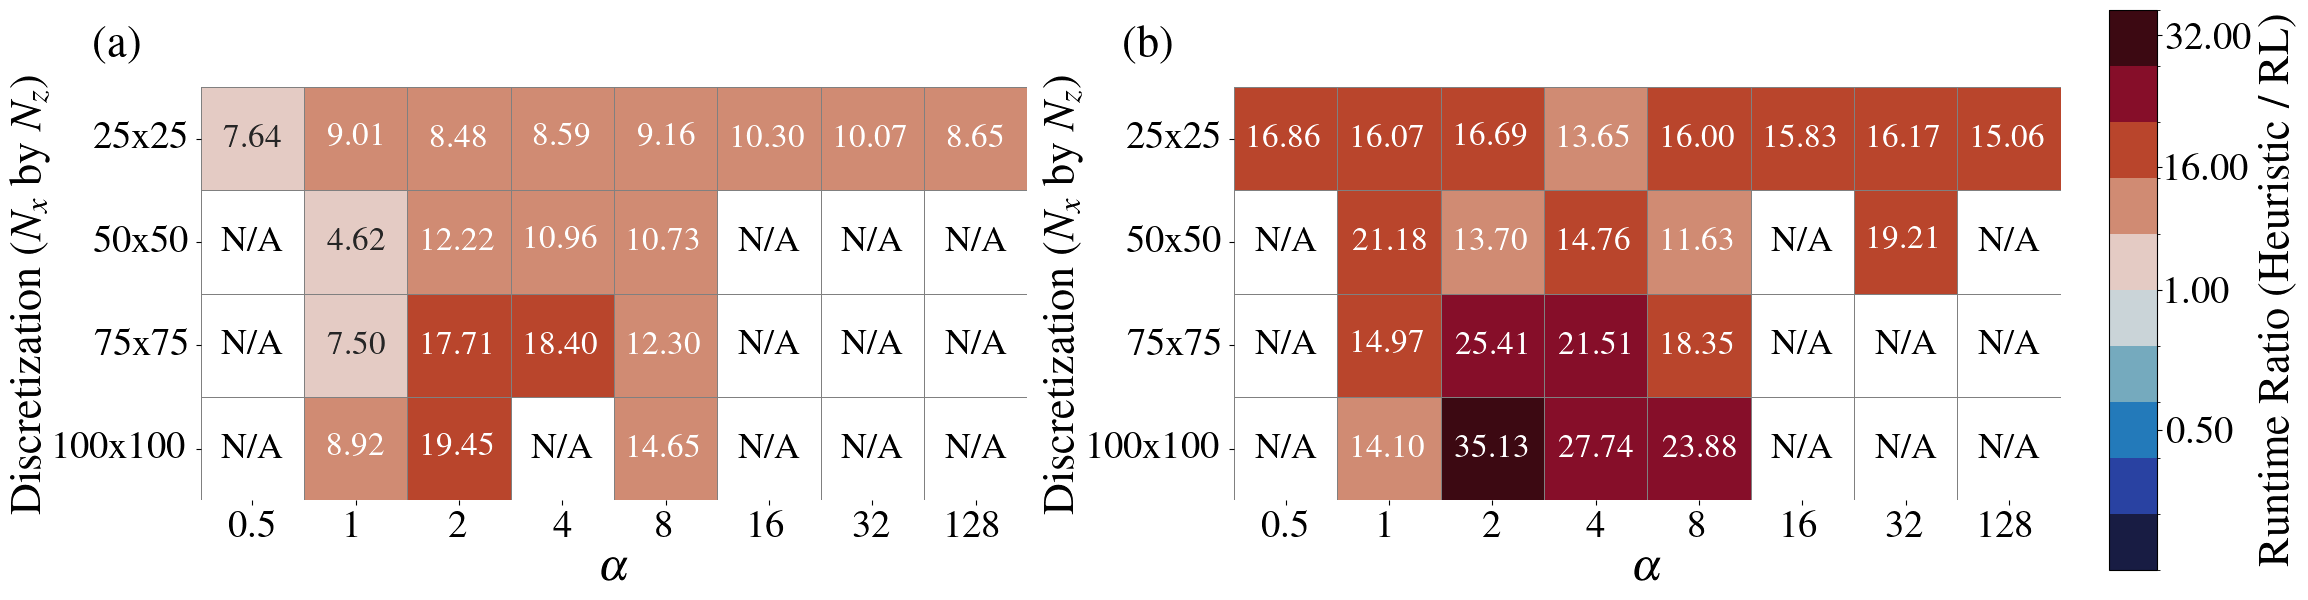

In [1]:
import json
import re
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib.colors import BoundaryNorm, ListedColormap
from matplotlib.cm import ScalarMappable

# ============================================================
# Global style (your settings)
# ============================================================
sizes = 32
plt.rcParams.update({
    'font.size': sizes,
    'axes.titlesize': sizes,
    'axes.labelsize': sizes,
    'xtick.labelsize': sizes,
    'ytick.labelsize': sizes,
    'legend.fontsize': sizes,
    'figure.titlesize': sizes,
    'text.usetex': True,
    'font.family': 'Times',
    'pdf.fonttype': 42,
    'ps.fonttype': 42,
    'text.latex.preamble': r'\usepackage{amsmath}\usepackage{mathptmx}',
    'axes.grid': False,
})

# optional cmocean
try:
    import cmocean
    _HAS_CMOCEAN = True
except Exception:
    _HAS_CMOCEAN = False
    print("[INFO] cmocean not found. Falling back to 'coolwarm'.")


# ============================================================
# Helpers: loading + ratio computation
# ============================================================
def _parse_alpha(method_name: str) -> float | None:
    m = re.search(r'alpha\s*=\s*([0-9.+-eE]+)', method_name)
    if not m:
        return None
    try:
        return float(m.group(1))
    except Exception:
        return None


def _aggregate_values(vals: list[float], how: str) -> float:
    arr = np.array([v for v in vals if np.isfinite(v) and v > 0.0], dtype=float)
    if arr.size == 0:
        return np.nan
    how = how.lower()
    if how == "min":
        return float(np.min(arr))
    if how == "mean":
        return float(np.mean(arr))
    if how == "max":
        return float(np.max(arr))
    return float(np.min(arr))


def compute_runtime_ratio_df(
    results_glob: str,
    aggregate: str = "min",
    method_filter_prefix: str | None = None,
    exclude_substrings: list[str] | None = None,
    verbose: bool = True,
) -> pd.DataFrame | None:
    """Return DF: index=discretization (e.g. '25x25'), columns=alphas, entries=PI/RL."""
    eval_files = sorted(Path(".").glob(results_glob))
    if exclude_substrings:
        eval_files = [
            f for f in eval_files
            if not any(sub in f.name for sub in exclude_substrings)
        ]
    if not eval_files:
        print(f"[WARN] No files for glob '{results_glob}' after excludes={exclude_substrings}")
        return None

    if verbose:
        print(f"\nLoading files for glob '{results_glob}' (excludes={exclude_substrings}):")
        print("  ", [f.name for f in eval_files])

    all_data: dict[str, dict] = {}
    for f in eval_files:
        grid_label_full = f.stem.replace("eval_results_", "")
        with open(f, "r", encoding="utf-8") as fh:
            data = json.load(fh)
        all_data[grid_label_full] = data
        if verbose:
            print(f"  Loaded {f.name}: keys={list(data.keys())}")

    # collect all alphas
    all_alphas = set()
    for grid_data in all_data.values():
        for method_name in grid_data.keys():
            if method_name == "PI_baseline":
                continue
            if method_filter_prefix and not method_name.startswith(method_filter_prefix):
                continue
            a = _parse_alpha(method_name)
            if a is not None:
                all_alphas.add(a)

    if not all_alphas:
        print(f"[WARN] No RL methods with alpha=* in '{results_glob}'")
        return None

    alphas_sorted = sorted(all_alphas)
    alpha_labels = [f"{a:g}" for a in alphas_sorted]

    # index labels: strip e.g. "3by3_25x25" -> "25x25"
    full_labels = list(all_data.keys())
    disc_labels = [lab.split("_")[-1] for lab in full_labels]

    ratio_mat = np.full((len(full_labels), len(alphas_sorted)), np.nan, dtype=float)

    for i, full_label in enumerate(full_labels):
        grid_data = all_data[full_label]
        pi_runtime = grid_data.get("PI_baseline", {}).get("runtime_s", np.nan)
        if not (np.isfinite(pi_runtime) and pi_runtime > 0.0):
            if verbose:
                print(f"  [WARN] No valid PI baseline for '{full_label}'")
            continue

        per_alpha_values: dict[float, list[float]] = {a: [] for a in alphas_sorted}

        for method_name, method_data in grid_data.items():
            if method_name == "PI_baseline":
                continue
            if method_filter_prefix and not method_name.startswith(method_filter_prefix):
                continue

            a = _parse_alpha(method_name)
            if a is None:
                continue

            converged = bool(method_data.get("converged", False))
            success_rate = float(method_data.get("success_rate", 0.0))
            if not (converged or success_rate > 0.0):
                continue

            rl_runtime = method_data.get("runtime_s", np.nan)
            if not (np.isfinite(rl_runtime) and rl_runtime > 0.0):
                continue

            for a_target in per_alpha_values.keys():
                if abs(a - a_target) < 1e-12:
                    per_alpha_values[a_target].append(float(rl_runtime))
                    break

        for j, a in enumerate(alphas_sorted):
            rl_agg = _aggregate_values(per_alpha_values[a], aggregate)
            if np.isfinite(rl_agg) and rl_agg > 0.0:
                ratio_mat[i, j] = pi_runtime / rl_agg
                if verbose:
                    print(f"  Grid {full_label:>12s}, alpha={a:g}: "
                          f"PI={pi_runtime:.3f}, RL({aggregate})={rl_agg:.3f}, "
                          f"ratio={ratio_mat[i,j]:.2f}")

    ratio_df = pd.DataFrame(ratio_mat, index=disc_labels, columns=alpha_labels)

    # sort: discretization ascending, alpha ascending
    def _disc_key(lbl: str):
        try:
            return int(lbl.split('x')[0])
        except Exception:
            return lbl

    ratio_df = ratio_df.sort_index(key=lambda idx: [_disc_key(s) for s in idx])
    ratio_df = ratio_df.reindex(sorted(ratio_df.columns, key=lambda s: float(s)), axis=1)

    if verbose:
        print("\nRatio DataFrame (index=disc, columns=alpha):")
        print(ratio_df)

    return ratio_df


# ============================================================
# Plot helpers
# ============================================================
def _annotations(df: pd.DataFrame) -> pd.DataFrame:
    if hasattr(df, "map"):
        return df.map(lambda x: f"{x:.2f}" if pd.notna(x) else "")
    return df.applymap(lambda x: f"{x:.2f}" if pd.notna(x) else "")


def _overlay_na(ax, df: pd.DataFrame, fontsize=12, color="black"):
    for y in range(df.shape[0]):
        for x in range(df.shape[1]):
            if pd.isna(df.iat[y, x]):
                ax.text(x + 0.5, y + 0.5, "N/A",
                        ha="center", va="center",
                        fontsize=fontsize, color=color)


def _symmetric_limits_around_one(vals_all: np.ndarray):
    vals_all = vals_all[np.isfinite(vals_all)]
    if vals_all.size == 0:
        return 0.5, 1.5
    vmin_real = float(np.min(vals_all))
    vmax_real = float(np.max(vals_all))
    delta_low = max(0.0, 1.0 - vmin_real)
    delta_high = max(0.0, vmax_real - 1.0)
    half_span = max(delta_low, delta_high)
    vmin_sym = max(1.0 - half_span, 1e-12)
    vmax_sym = 1.0 + half_span
    return vmin_sym, vmax_sym


def _diverging_levels(vmin_sym: float, vmax_sym: float, n_bins_total: int):
    if n_bins_total % 2 == 1:
        n_bins_total += 1
    n_half = n_bins_total // 2
    lower = np.linspace(vmin_sym, 1.0, n_half + 1)[:-1]
    upper = np.linspace(1.0, vmax_sym, n_half + 1)
    return np.concatenate([lower, upper])  # len = n_bins_total + 1

from matplotlib.colors import BoundaryNorm, ListedColormap
from matplotlib.cm import ScalarMappable

def create_runtime_ratio_dual_heatmap(
    glob_a: str = "eval_results_3by3_*.json",
    glob_b: str = "eval_results_5by5_*.json",
    aggregate: str = "min",
    method_filter_prefix: str | None = None,
    exclude_substrings_a: list[str] | None = None,
    exclude_substrings_b: list[str] | None = ["_PI_"],  # exclude 5by5_PI by default
    save_path: str = "runtime_ratio_3by3_vs_5by5_xalpha.pdf",
    n_bins_diverging: int = 10,
    verbose: bool = True,
):
    # --------------------------------------------------------
    # 1) Build the two ratio DataFrames
    # --------------------------------------------------------
    df_a = compute_runtime_ratio_df(
        results_glob=glob_a,
        aggregate=aggregate,
        method_filter_prefix=method_filter_prefix,
        exclude_substrings=exclude_substrings_a,
        verbose=verbose,
    )
    df_b = compute_runtime_ratio_df(
        results_glob=glob_b,
        aggregate=aggregate,
        method_filter_prefix=method_filter_prefix,
        exclude_substrings=exclude_substrings_b,
        verbose=verbose,
    )

    if df_a is None or df_b is None:
        print("[ERROR] One of the DataFrames is None; aborting.")
        return None, None

    vals_a = df_a.values[np.isfinite(df_a.values)]
    vals_b = df_b.values[np.isfinite(df_b.values)]
    if vals_a.size == 0 and vals_b.size == 0:
        print("[ERROR] No finite ratios.")
        return df_a, df_b

    if vals_a.size == 0:
        all_vals = vals_b
    elif vals_b.size == 0:
        all_vals = vals_a
    else:
        all_vals = np.concatenate([vals_a, vals_b])

    # symmetric limits around 1 so colour scale is centred
    vmin_sym, vmax_sym = _symmetric_limits_around_one(all_vals)

    # discrete bin boundaries
    if n_bins_diverging % 2 == 1:
        n_bins_diverging += 1
    levels = _diverging_levels(vmin_sym, vmax_sym, n_bins_total=n_bins_diverging)
    ncolors = len(levels) - 1

    # base cmap: cmocean.balance if available, otherwise coolwarm
    if _HAS_CMOCEAN:
        base_cmap = cmocean.cm.balance
    else:
        base_cmap = plt.get_cmap("coolwarm")

    cmap_disc = ListedColormap(base_cmap(np.linspace(0, 1, ncolors)))
    cmap_disc.set_bad(color="white")
    norm = BoundaryNorm(boundaries=levels, ncolors=ncolors)

    # --------------------------------------------------------
    # 2) Figure layout (more space between panels)
    # --------------------------------------------------------
    fig = plt.figure(figsize=(24, 8))
    gs = fig.add_gridspec(
        nrows=1, ncols=3,
        width_ratios=[1, 1, 0.05],
        wspace=0.4  # increase spacing between (a) and (b)
    )

    ax_a = fig.add_subplot(gs[0, 0])
    ax_b = fig.add_subplot(gs[0, 1])
    cax  = fig.add_subplot(gs[0, 2])

    # --------------------------------------------------------
    # 3) Panel (a): 3by3
    # --------------------------------------------------------
    ann_a = _annotations(df_a)
    sns.heatmap(
        df_a,
        annot=ann_a.values,
        fmt="",
        cmap=cmap_disc,
        norm=norm,
        mask=df_a.isna(),
        cbar=False,
        annot_kws={"size": sizes - 8},
        linewidths=0.5,
        linecolor="gray",
        square=True,
        ax=ax_a,
    )
    _overlay_na(ax_a, df_a, fontsize=sizes - 6)
    ax_a.set_xlabel(r'$\alpha$', fontsize=sizes)
    ax_a.set_ylabel(r'Discretization ($N_x$ by $N_z$)', fontsize=sizes)
    ax_a.tick_params(axis='both', labelsize=sizes - 4)
    ax_a.text(-0.07, 1.05, r'(a)',
              transform=ax_a.transAxes,
              fontsize=sizes,
              va='bottom', ha='right')

    # --------------------------------------------------------
    # 4) Panel (b): 5by5
    # --------------------------------------------------------
    ann_b = _annotations(df_b)
    sns.heatmap(
        df_b,
        annot=ann_b.values,
        fmt="",
        cmap=cmap_disc,
        norm=norm,
        mask=df_b.isna(),
        cbar=False,
        annot_kws={"size": sizes - 8},
        linewidths=0.5,
        linecolor="gray",
        square=True,
        ax=ax_b,
    )
    _overlay_na(ax_b, df_b, fontsize=sizes - 6)
    ax_b.set_xlabel(r'$\alpha$', fontsize=sizes)
    ax_b.set_ylabel(r'Discretization ($N_x$ by $N_z$)', fontsize=sizes)
    ax_b.tick_params(axis='both', labelsize=sizes - 4)
    ax_b.text(-0.07, 1.2, r'(b)',
              transform=ax_b.transAxes,
              fontsize=sizes,
              va='bottom', ha='right')

    # --------------------------------------------------------
    # 5) Shared colourbar – always show 1 and some values below/above
    # --------------------------------------------------------
    sm = ScalarMappable(norm=norm, cmap=cmap_disc)
    sm.set_array([])

    cbar = fig.colorbar(sm, cax=cax)

    # Build ticks: start from a coarse linspace, then inject 1.0 explicitly
    n_ticks_base = min(5, ncolors + 1)
    base_ticks = np.linspace(0, vmax_sym, n_ticks_base)
    ticks = np.unique(np.concatenate([base_ticks, np.array([1.0])]))
    # clamp to [vmin_sym, vmax_sym]
    ticks = ticks[(ticks >= vmin_sym - 1e-9) & (ticks <= vmax_sym + 1e-9)]
    ticks = np.sort(ticks)

    # cbar.set_ticks(ticks)
    # cbar.set_ticklabels([f"{t:.2f}" for t in ticks])
    cbar.set_label(r'Runtime Ratio (PI / RL)', fontsize=sizes)
    cbar.ax.tick_params(labelsize=sizes - 4)

    fig.tight_layout(rect=[0.03, 0.05, 0.97, 0.95])
    fig.savefig(save_path, dpi=300, bbox_inches="tight")
    print(f"Saved dual heatmap to {save_path}")
    plt.show()

    return df_a, df_b

def create_runtime_ratio_dual_heatmap(
    glob_a: str = "eval_results_3by3_*.json",
    glob_b: str = "eval_results_5by5_*.json",
    aggregate: str = "min",
    method_filter_prefix: str | None = None,
    exclude_substrings_a: list[str] | None = None,
    exclude_substrings_b: list[str] | None = ["_PI_"],
    save_path: str = "runtime_ratio_3by3_vs_5by5_xalpha.pdf",
    n_bins_diverging: int = 10,
    verbose: bool = True,
):
    # --------------------------------------------------------
    # 1) Build the two ratio DataFrames
    # --------------------------------------------------------
    df_a = compute_runtime_ratio_df(
        results_glob=glob_a,
        aggregate=aggregate,
        method_filter_prefix=method_filter_prefix,
        exclude_substrings=exclude_substrings_a,
        verbose=verbose,
    )
    df_b = compute_runtime_ratio_df(
        results_glob=glob_b,
        aggregate=aggregate,
        method_filter_prefix=method_filter_prefix,
        exclude_substrings=exclude_substrings_b,
        verbose=verbose,
    )

    if df_a is None or df_b is None:
        print("[ERROR] One of the DataFrames is None; aborting.")
        return None, None

    vals_a = df_a.values[np.isfinite(df_a.values)]
    vals_b = df_b.values[np.isfinite(df_b.values)]
    if vals_a.size == 0 and vals_b.size == 0:
        print("[ERROR] No finite ratios.")
        return df_a, df_b

    if vals_a.size == 0:
        all_vals = vals_b
    elif vals_b.size == 0:
        all_vals = vals_a
    else:
        all_vals = np.concatenate([vals_a, vals_b])

    # symmetric limits around 1 so colour scale is centred
    vmin_sym, vmax_sym = _symmetric_limits_around_one(all_vals)

    # discrete bin boundaries
    if n_bins_diverging % 2 == 1:
        n_bins_diverging += 1
    levels = _diverging_levels(vmin_sym, vmax_sym, n_bins_total=n_bins_diverging)
    ncolors = len(levels) - 1

    # base cmap: cmocean.balance if available, otherwise coolwarm
    if _HAS_CMOCEAN:
        base_cmap = cmocean.cm.balance
    else:
        base_cmap = plt.get_cmap("coolwarm")

    cmap_disc = ListedColormap(base_cmap(np.linspace(0, 1, ncolors)))
    cmap_disc.set_bad(color="white")
    norm = BoundaryNorm(boundaries=levels, ncolors=ncolors)

    # --------------------------------------------------------
    # 2) Figure layout - only 2 columns for main plots
    # --------------------------------------------------------
    fig = plt.figure(figsize=(24, 8))
    gs = fig.add_gridspec(
        nrows=1, ncols=2,
        width_ratios=[1, 1],
        wspace=0.25  # Keep good spacing between (a) and (b)
    )

    ax_a = fig.add_subplot(gs[0, 0])
    ax_b = fig.add_subplot(gs[0, 1])
    
    # Manually create colorbar axis close to plot (b)
    # [left, bottom, width, height] in figure coordinates
    cax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # Adjust 'left' to control distance

    # --------------------------------------------------------
    # 3) Panel (a): 3by3
    # --------------------------------------------------------
    ann_a = _annotations(df_a)
    sns.heatmap(
        df_a,
        annot=ann_a.values,
        fmt="",
        cmap=cmap_disc,
        norm=norm,
        mask=df_a.isna(),
        cbar=False,
        annot_kws={"size": sizes - 8},
        linewidths=0.5,
        linecolor="gray",
        square=True,
        ax=ax_a,
    )
    _overlay_na(ax_a, df_a, fontsize=sizes - 6)
    ax_a.set_xlabel(r'$\alpha$', fontsize=sizes)
    ax_a.set_ylabel(r'Discretization ($N_x$ by $N_z$)', fontsize=sizes)
    ax_a.tick_params(axis='both', labelsize=sizes - 4)
    ax_a.text(-0.07, 1.05, r'(a)',
              transform=ax_a.transAxes,
              fontsize=sizes,
              va='bottom', ha='right')

    # --------------------------------------------------------
    # 4) Panel (b): 5by5
    # --------------------------------------------------------
    ann_b = _annotations(df_b)
    sns.heatmap(
        df_b,
        annot=ann_b.values,
        fmt="",
        cmap=cmap_disc,
        norm=norm,
        mask=df_b.isna(),
        cbar=False,
        annot_kws={"size": sizes - 8},
        linewidths=0.5,
        linecolor="gray",
        square=True,
        ax=ax_b,
    )
    _overlay_na(ax_b, df_b, fontsize=sizes - 6)
    ax_b.set_xlabel(r'$\alpha$', fontsize=sizes)
    ax_b.set_ylabel(r'Discretization ($N_x$ by $N_z$)', fontsize=sizes)
    ax_b.tick_params(axis='both', labelsize=sizes - 4)
    ax_b.text(-0.07, 1.05, r'(b)',
              transform=ax_b.transAxes,
              fontsize=sizes,
              va='bottom', ha='right')

    # --------------------------------------------------------
    # 5) Shared colourbar with 1.0 explicitly shown
    # --------------------------------------------------------
    sm = ScalarMappable(norm=norm, cmap=cmap_disc)
    sm.set_array([])

    cbar = fig.colorbar(sm, cax=cax)

    # Build ticks ensuring 1.0 is included
    if vmax_sym > 10:
        # For large ranges, select key values including 1.0
        tick_candidates = [vmin_sym, 0.5, 0.8, 1.0, 5, 10, 15, 20, vmax_sym]
        ticks = [t for t in tick_candidates if vmin_sym <= t <= vmax_sym]
    else:
        # For smaller ranges, linear spacing but force 1.0
        n_ticks = 7
        base_ticks = np.linspace(vmin_sym, vmax_sym, n_ticks)
        # Replace closest value to 1.0 with exactly 1.0
        if len(base_ticks) > 0:
            idx_closest = np.argmin(np.abs(base_ticks - 1.0))
            base_ticks[idx_closest] = 1.0
        ticks = base_ticks
    ticks = np.array([ 0.5, 1,  16, 32])

    # Ensure ticks are sorted and unique
    ticks = np.sort(np.unique(ticks))
    
    # Set the ticks and labels (with 1.00 explicitly formatted)
    cbar.set_ticks(ticks)
    tick_labels = [f"{t:.2f}" if abs(t - 1.0) > 0.01 else "1.00" for t in ticks]
    cbar.set_ticklabels(tick_labels)
    
    cbar.set_label(r'Runtime Ratio (Heuristic / RL)', fontsize=sizes)
    cbar.ax.tick_params(labelsize=sizes - 4)

    fig.tight_layout(rect=[0.03, 0.05, 0.97, 0.95])
    fig.savefig(save_path, dpi=300, bbox_inches="tight")
    print(f"Saved dual heatmap to {save_path}")
    plt.show()

    return df_a, df_b

# ============================================================
# Example call
# ============================================================
if __name__ == "__main__":
    df_3by3, df_5by5 = create_runtime_ratio_dual_heatmap(
        glob_a="eval_results_3by3_*.json",
        glob_b="eval_results_5by5_*.json",
        aggregate="min",
        method_filter_prefix=None,       # or "TQC " if you only want TQC
        exclude_substrings_a=None,
        exclude_substrings_b=["_PI_"],   # exclude eval_results_5by5_PI_*.json
        save_path="figure5.pdf",
        n_bins_diverging=10,
        verbose=True,
    )


In [32]:
import json
import re
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib.colors import BoundaryNorm, ListedColormap
from matplotlib.cm import ScalarMappable

# ============================================================
# Global style (your settings)
# ============================================================
sizes = 32
plt.rcParams.update({
    'font.size': sizes,
    'axes.titlesize': sizes,
    'axes.labelsize': sizes,
    'xtick.labelsize': sizes,
    'ytick.labelsize': sizes,
    'legend.fontsize': sizes,
    'figure.titlesize': sizes,
    'text.usetex': True,
    'font.family': 'Times',
    'pdf.fonttype': 42,
    'ps.fonttype': 42,
    'text.latex.preamble': r'\usepackage{amsmath}\usepackage{mathptmx}',
    'axes.grid': False,
})

# optional cmocean
try:
    import cmocean
    _HAS_CMOCEAN = True
except Exception:
    _HAS_CMOCEAN = False
    print("[INFO] cmocean not found. Falling back to 'coolwarm'.")


# ============================================================
# Helpers: parsing + utilities
# ============================================================
def _parse_alpha(method_name: str) -> float | None:
    """Extract numeric alpha from method name like 'TQC alpha=4'."""
    m = re.search(r'alpha\s*=\s*([0-9.+-eE]+)', method_name)
    if not m:
        return None
    try:
        return float(m.group(1))
    except Exception:
        return None


def _aggregate_values(vals: list[float], how: str) -> float:
    """Aggregate a list of runtimes with min/mean/max, skipping non-finite."""
    arr = np.array([v for v in vals if np.isfinite(v) and v > 0.0], dtype=float)
    if arr.size == 0:
        return np.nan
    how = how.lower()
    if how == "min":
        return float(np.min(arr))
    if how == "mean":
        return float(np.mean(arr))
    if how == "max":
        return float(np.max(arr))
    return float(np.min(arr))


def _disc_key(lbl: str):
    """Sorting key for discretization strings like '25x25', '100x100'."""
    try:
        return int(lbl.split('x')[0])
    except Exception:
        return lbl


def _annotations(df: pd.DataFrame) -> pd.DataFrame:
    """Nicely formatted text annotations."""
    if hasattr(df, "map"):
        return df.map(lambda x: f"{x:.2f}" if pd.notna(x) else "")
    return df.applymap(lambda x: f"{x:.2f}" if pd.notna(x) else "")


def _overlay_na(ax, df: pd.DataFrame, fontsize=12, color="black"):
    """Write 'N/A' on NaN cells."""
    for y in range(df.shape[0]):
        for x in range(df.shape[1]):
            if pd.isna(df.iat[y, x]):
                ax.text(x + 0.5, y + 0.5, "N/A",
                        ha="center", va="center",
                        fontsize=fontsize, color=color)


def _symmetric_limits_around_one(vals_all: np.ndarray):
    """Symmetric colour limits around 1.0."""
    vals_all = vals_all[np.isfinite(vals_all)]
    if vals_all.size == 0:
        return 0.5, 1.5
    vmin_real = float(np.min(vals_all))
    vmax_real = float(np.max(vals_all))
    delta_low = max(0.0, 1.0 - vmin_real)
    delta_high = max(0.0, vmax_real - 1.0)
    half_span = max(delta_low, delta_high)
    vmin_sym = max(1.0 - half_span, 1e-12)
    vmax_sym = 1.0 + half_span
    return vmin_sym, vmax_sym


def _diverging_levels(vmin_sym: float, vmax_sym: float, n_bins_total: int):
    """Discrete bin boundaries for diverging colormap centred at 1."""
    if n_bins_total % 2 == 1:
        n_bins_total += 1
    n_half = n_bins_total // 2
    lower = np.linspace(vmin_sym, 1.0, n_half + 1)[:-1]  # exclude duplicate 1
    upper = np.linspace(1.0, vmax_sym, n_half + 1)
    return np.concatenate([lower, upper])  # length = n_bins_total + 1


# ============================================================
# Load PI baselines from separate eval_results_*_PI_*.json
# ============================================================
def load_external_pi_baselines(
    pi_glob: str,
    exclude_substrings: list[str] | None = None,
    verbose: bool = True,
) -> dict[str, float]:
    """
    Load PI baseline runtimes from separate files.

    Returns dict: { '25x25': runtime_s, ... } in *dimensionless* units
    (exactly as stored in the JSON).
    """
    pi_files = sorted(Path(".").glob(pi_glob))
    if exclude_substrings:
        pi_files = [
            f for f in pi_files
            if not any(sub in f.name for sub in exclude_substrings)
        ]

    pi_map: dict[str, float] = {}

    if verbose:
        print(f"\nLoading external PI baselines for glob '{pi_glob}':")
        print("  files:", [f.name for f in pi_files])

    for f in pi_files:
        with open(f, "r", encoding="utf-8") as fh:
            data = json.load(fh)

        # discretization label is always the last '_' chunk, e.g.
        #   eval_results_PI_25x25      -> '25x25'
        #   eval_results_5by5_PI_25x25 -> '25x25'
        disc_label = f.stem.split("_")[-1]

        pi_runtime = data.get("PI_baseline", {}).get("runtime_s", np.nan)
        if np.isfinite(pi_runtime) and pi_runtime > 0.0:
            pi_map[disc_label] = float(pi_runtime)
            if verbose:
                print(f"  {f.name}: disc={disc_label}, PI_runtime={pi_runtime:.3f}s")
        else:
            if verbose:
                print(f"  [WARN] {f.name}: invalid PI runtime {pi_runtime}")

    return pi_map


# ============================================================
# Compute PI/RL ratio using EXTERNAL PI baselines
# ============================================================
def compute_runtime_ratio_df_external_pi(
    rl_glob: str,
    pi_glob: str,
    aggregate: str = "min",
    method_filter_prefix: str | None = None,
    rl_exclude_substrings: list[str] | None = None,
    pi_exclude_substrings: list[str] | None = None,
    verbose: bool = True,
) -> pd.DataFrame | None:
    """
    Build a DataFrame of runtime ratios PI/RL for one family (3by3 or 5by5),
    using *external* PI files for the baseline.

    - rl_glob:      pattern for RL eval JSONs      (e.g. 'eval_results_3by3_*.json')
    - pi_glob:      pattern for external PI JSONs (e.g. 'eval_results_PI_*.json')
    - rl_exclude_substrings: optional list of substrings to skip in RL filenames
                             (e.g. ['_PI_'] so you don't pick 5by5_PI* files)
    """

    # ---------- RL files ----------
    rl_files = sorted(Path(".").glob(rl_glob))
    if rl_exclude_substrings:
        rl_files = [
            f for f in rl_files
            if not any(sub in f.name for sub in rl_exclude_substrings)
        ]
    if not rl_files:
        print(f"[WARN] No RL files for glob '{rl_glob}' after excludes={rl_exclude_substrings}")
        return None

    if verbose:
        print(f"\nLoading RL files for glob '{rl_glob}' (excludes={rl_exclude_substrings}):")
        print("  files:", [f.name for f in rl_files])

    rl_data: dict[str, dict] = {}
    for f in rl_files:
        with open(f, "r", encoding="utf-8") as fh:
            data = json.load(fh)
        # discretization label: last '_' chunk, e.g. '3by3_25x25' -> '25x25'
        disc_label = f.stem.split("_")[-1]
        rl_data[disc_label] = data
        if verbose:
            print(f"  Loaded {f.name}: disc={disc_label}, keys={list(data.keys())}")

    # ---------- external PI runtimes ----------
    pi_map = load_external_pi_baselines(
        pi_glob=pi_glob,
        exclude_substrings=pi_exclude_substrings,
        verbose=verbose,
    )

    if not pi_map:
        print(f"[ERROR] No valid external PI baselines found for glob '{pi_glob}'")
        return None

    # ---------- collect all alpha values from RL ----------
    all_alphas = set()
    for grid_data in rl_data.values():
        for method_name in grid_data.keys():
            if method_name == "PI_baseline":
                continue  # ignore internal PI
            if method_filter_prefix and not method_name.startswith(method_filter_prefix):
                continue
            a = _parse_alpha(method_name)
            if a is not None:
                all_alphas.add(a)

    if not all_alphas:
        print(f"[WARN] No RL methods with alpha=* in RL glob '{rl_glob}'")
        return None

    alphas_sorted = sorted(all_alphas)
    alpha_labels = [f"{a:g}" for a in alphas_sorted]

    # ---------- build ratio matrix ----------
    disc_labels_sorted = sorted(rl_data.keys(), key=_disc_key)
    ratio_mat = np.full((len(disc_labels_sorted), len(alphas_sorted)), np.nan, dtype=float)

    for i, disc_label in enumerate(disc_labels_sorted):
        grid_data = rl_data[disc_label]

        pi_runtime = pi_map.get(disc_label, np.nan)
        if not (np.isfinite(pi_runtime) and pi_runtime > 0.0):
            if verbose:
                print(f"  [WARN] no external PI runtime for disc '{disc_label}'")
            continue

        # collect RL runtimes per alpha
        per_alpha_values: dict[float, list[float]] = {a: [] for a in alphas_sorted}

        for method_name, method_data in grid_data.items():
            if method_name == "PI_baseline":
                continue  # ignore embedded PI
            if method_filter_prefix and not method_name.startswith(method_filter_prefix):
                continue

            a = _parse_alpha(method_name)
            if a is None:
                continue

            converged = bool(method_data.get("converged", False))
            success_rate = float(method_data.get("success_rate", 0.0))
            if not (converged or success_rate > 0.0):
                continue

            rl_runtime = method_data.get("runtime_s", np.nan)
            if not (np.isfinite(rl_runtime) and rl_runtime > 0.0):
                continue

            for a_target in per_alpha_values.keys():
                if abs(a - a_target) < 1e-12:
                    per_alpha_values[a_target].append(float(rl_runtime))
                    break

        for j, a in enumerate(alphas_sorted):
            rl_agg = _aggregate_values(per_alpha_values[a], aggregate)
            if np.isfinite(rl_agg) and rl_agg > 0.0:
                ratio = pi_runtime / rl_agg
                ratio_mat[i, j] = ratio
                if verbose:
                    print(f"  disc={disc_label:>6s}, alpha={a:g}: "
                          f"PI_ext={pi_runtime:.3f}, RL({aggregate})={rl_agg:.3f}, "
                          f"ratio={ratio:.2f}")

    ratio_df = pd.DataFrame(ratio_mat, index=disc_labels_sorted, columns=alpha_labels)

    # ensure alphas sorted numerically, rows by discretization
    ratio_df = ratio_df.reindex(
        sorted(ratio_df.columns, key=lambda s: float(s)),
        axis=1
    )
    ratio_df = ratio_df.sort_index(key=lambda idx: [_disc_key(s) for s in idx])

    if verbose:
        print("\nRatio DataFrame (index=disc, columns=alpha):")
        print(ratio_df)

    return ratio_df


# ============================================================
# Plot dual heatmap with shared discrete diverging colourbar
# ============================================================
def create_runtime_ratio_dual_heatmap_external_pi(
    rl_glob_a: str = "eval_results_3by3_*.json",
    pi_glob_a: str = "eval_results_PI_*.json",
    rl_glob_b: str = "eval_results_5by5_*.json",
    pi_glob_b: str = "eval_results_5by5_PI_*.json",
    aggregate: str = "min",
    method_filter_prefix: str | None = None,
    rl_exclude_a: list[str] | None = None,
    rl_exclude_b: list[str] | None = ["_PI_"],  # exclude 5by5_PI_* from RL glob
    pi_exclude_a: list[str] | None = None,
    pi_exclude_b: list[str] | None = None,
    save_path: str = "runtime_ratio_externalPI_3by3_vs_5by5.pdf",
    n_bins_diverging: int = 10,
    verbose: bool = True,
):
    # --- build the two dataframes ---
    df_a = compute_runtime_ratio_df_external_pi(
        rl_glob=rl_glob_a,
        pi_glob=pi_glob_a,
        aggregate=aggregate,
        method_filter_prefix=method_filter_prefix,
        rl_exclude_substrings=rl_exclude_a,
        pi_exclude_substrings=pi_exclude_a,
        verbose=verbose,
    )

    df_b = compute_runtime_ratio_df_external_pi(
        rl_glob=rl_glob_b,
        pi_glob=pi_glob_b,
        aggregate=aggregate,
        method_filter_prefix=method_filter_prefix,
        rl_exclude_substrings=rl_exclude_b,
        pi_exclude_substrings=pi_exclude_b,
        verbose=verbose,
    )

    if df_a is None or df_b is None:
        print("[ERROR] One of the DataFrames is None; aborting.")
        return None, None

    vals_a = df_a.values[np.isfinite(df_a.values)]
    vals_b = df_b.values[np.isfinite(df_b.values)]

    if vals_a.size == 0 and vals_b.size == 0:
        print("[ERROR] No finite ratios to plot.")
        return df_a, df_b

    if vals_a.size == 0:
        all_vals = vals_b
    elif vals_b.size == 0:
        all_vals = vals_a
    else:
        all_vals = np.concatenate([vals_a, vals_b])

    # symmetric limits around 1
    vmin_sym, vmax_sym = _symmetric_limits_around_one(all_vals)

    # discrete bins
    if n_bins_diverging % 2 == 1:
        n_bins_diverging += 1
    levels = _diverging_levels(vmin_sym, vmax_sym, n_bins_total=n_bins_diverging)
    ncolors = len(levels) - 1

    # base colormap
    if _HAS_CMOCEAN:
        base_cmap = cmocean.cm.balance
    else:
        base_cmap = plt.get_cmap("coolwarm")

    cmap_disc = ListedColormap(base_cmap(np.linspace(0, 1, ncolors)))
    cmap_disc.set_bad(color="white")
    norm = BoundaryNorm(boundaries=levels, ncolors=ncolors)

    # --------------------------------------------------------
    # 2) Figure layout - only 2 columns for main plots
    # --------------------------------------------------------
    fig = plt.figure(figsize=(24, 8))
    gs = fig.add_gridspec(
        nrows=1, ncols=2,
        width_ratios=[1, 1],
        wspace=0.25  # Keep good spacing between (a) and (b)
    )

    ax_a = fig.add_subplot(gs[0, 0])
    ax_b = fig.add_subplot(gs[0, 1])
    
    # Manually create colorbar axis close to plot (b)
    # [left, bottom, width, height] in figure coordinates
    cax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # Adjust 'left' to control distance


    # ---- Panel (a): 3by3 vs external PI ----
    ann_a = _annotations(df_a)
    sns.heatmap(
        df_a,
        annot=ann_a.values,
        fmt="",
        cmap=cmap_disc,
        norm=norm,
        mask=df_a.isna(),
        cbar=False,
        annot_kws={"size": sizes - 8},
        linewidths=0.5,
        linecolor="gray",
        square=True,
        ax=ax_a,
    )
    _overlay_na(ax_a, df_a, fontsize=sizes - 6)
    ax_a.set_xlabel(r'$\alpha$', fontsize=sizes)
    ax_a.set_ylabel(r'Discretization ($N_x$ by $N_z$)', fontsize=sizes)
    ax_a.tick_params(axis='both', labelsize=sizes - 4)
    ax_a.text(-0.12, 1.05, r'(a)',
              transform=ax_a.transAxes,
              fontsize=sizes,
              va='bottom', ha='left')

    # ---- Panel (b): 5by5 vs external PI ----
    ann_b = _annotations(df_b)
    sns.heatmap(
        df_b,
        annot=ann_b.values,
        fmt="",
        cmap=cmap_disc,
        norm=norm,
        mask=df_b.isna(),
        cbar=False,
        annot_kws={"size": sizes - 8},
        linewidths=0.5,
        linecolor="gray",
        square=True,
        ax=ax_b,
    )
    _overlay_na(ax_b, df_b, fontsize=sizes - 6)
    ax_b.set_xlabel(r'$\alpha$', fontsize=sizes)
    ax_b.set_ylabel(r'Discretization ($N_x$ by $N_z$)', fontsize=sizes)
    ax_b.tick_params(axis='both', labelsize=sizes - 4)
    ax_b.text(-0.12, 1.05, r'(b)',
              transform=ax_b.transAxes,
              fontsize=sizes,
              va='bottom', ha='left')

    # ---- Shared colourbar ----
    sm = ScalarMappable(norm=norm, cmap=cmap_disc)
    sm.set_array([])

    cbar = fig.colorbar(sm, cax=cax)

    ticks = [0.5,  1.0,  35,  vmax_sym]
    # Filter to valid range
    ticks = [t for t in ticks if vmin_sym <= t <= vmax_sym]
    ticks = np.array([ 0.5, 1,   35,70])

    ticks = np.sort(np.unique(ticks))

    cbar.set_ticks(ticks)
    tick_labels = []
    for t in ticks:
        if abs(t - 1.0) < 0.01:
            tick_labels.append("1.00")
        elif t == int(t) and t >= 10:
            tick_labels.append(f"{int(t)}")
        else:
            tick_labels.append(f"{t:.1f}")
    cbar.set_ticklabels(tick_labels)
    tick_labels = [f"{t:.2f}" if abs(t - 1.0) > 0.01 else "1.00" for t in ticks]
    # tick_labels = [f"{t:.2f}" if abs(t - 1.0) > 0.01 else "1.00" for t in ticks]
    cbar.set_ticklabels(tick_labels)
    
    cbar.set_label(r'Runtime Ratio (PI / RL)', fontsize=sizes)
    cbar.ax.tick_params(labelsize=sizes - 4)
    fig.tight_layout(rect=[0.03, 0.06, 0.97, 0.95])
    fig.savefig(save_path, dpi=300, bbox_inches="tight")
    print(f"Saved dual heatmap (external PI) to {save_path}")
    plt.show()

    return df_a, df_b

def create_runtime_ratio_heatmap_external_pi(
    rl_glob: str = "eval_results_3by3_*.json",
    pi_glob: str = "eval_results_PI_*.json",
    aggregate: str = "min",
    method_filter_prefix: str | None = None,
    rl_exclude: list[str] | None = None,
    pi_exclude: list[str] | None = None,
    save_path: str = "figure5a.pdf",
    n_bins_diverging: int = 10,
    verbose: bool = True,
):
    """
    Single-panel version: only plot (a) = 3by3 vs external PI baselines.
    """

    # --- build the dataframe for 3by3 family ---
    df = compute_runtime_ratio_df_external_pi(
        rl_glob=rl_glob,
        pi_glob=pi_glob,
        aggregate=aggregate,
        method_filter_prefix=method_filter_prefix,
        rl_exclude_substrings=rl_exclude,
        pi_exclude_substrings=pi_exclude,
        verbose=verbose,
    )

    if df is None:
        print("[ERROR] DataFrame is None; aborting.")
        return None

    vals = df.values[np.isfinite(df.values)]
    if vals.size == 0:
        print("[ERROR] No finite ratios to plot.")
        return df

    # symmetric limits around 1
    vmin_sym, vmax_sym = _symmetric_limits_around_one(vals)

    # discrete bins
    if n_bins_diverging % 2 == 1:
        n_bins_diverging += 1
    levels = _diverging_levels(vmin_sym, vmax_sym, n_bins_total=n_bins_diverging)
    ncolors = len(levels) - 1

    # base colormap
    if _HAS_CMOCEAN:
        base_cmap = cmocean.cm.balance
    else:
        base_cmap = plt.get_cmap("coolwarm")

    cmap_disc = ListedColormap(base_cmap(np.linspace(0, 1, ncolors)))
    cmap_disc.set_bad(color="white")
    norm = BoundaryNorm(boundaries=levels, ncolors=ncolors)

    # --------------------------------------------------------
    # Figure layout: 1 panel + colourbar on the right
    # --------------------------------------------------------
    fig = plt.figure(figsize=(12, 8))
    gs = fig.add_gridspec(
        nrows=1, ncols=1,
        width_ratios=[1],
        wspace=0.2
    )

    ax = fig.add_subplot(gs[0, 0])

    # Manual colorbar axis
    # [left, bottom, width, height] in figure coordinates
    cax = fig.add_axes([0.92, 0.15, 0.02, 0.7])

    # ---- Panel (a): 3by3 vs external PI ----
    ann = _annotations(df)
    sns.heatmap(
        df,
        annot=ann.values,
        fmt="",
        cmap=cmap_disc,
        norm=norm,
        mask=df.isna(),
        cbar=False,
        annot_kws={"size": sizes - 8},
        linewidths=0.5,
        linecolor="gray",
        square=True,
        ax=ax,
    )
    _overlay_na(ax, df, fontsize=sizes - 6)
    ax.set_xlabel(r'$\alpha$', fontsize=sizes)
    ax.set_ylabel(r'Discretization ($N_x$ by $N_z$)', fontsize=sizes)
    ax.tick_params(axis='both', labelsize=sizes - 4)
    # ax.text(-0.12, 1.05, r'(a)',
    #         transform=ax.transAxes,
    #         fontsize=sizes,
    #         va='bottom', ha='left')

    # ---- Shared colourbar ----
    sm = ScalarMappable(norm=norm, cmap=cmap_disc)
    sm.set_array([])

    cbar = fig.colorbar(sm, cax=cax)

    # Keep your explicit tick choices (0.5, 1, 35, 70)
    ticks = [0.5, 1.0, 15, 30]
    ticks = [t for t in ticks if vmin_sym <= t <= vmax_sym]
    # ticks = np.array([0.5, 1, 35, 70])  # as in your original code
    ticks = np.sort(np.unique(ticks))

    cbar.set_ticks(ticks)

    tick_labels = [f"{t:.2f}" if abs(t - 1.0) > 0.01 else "1.00" for t in ticks]
    cbar.set_ticklabels(tick_labels)

    cbar.set_label(r'Runtime Ratio (PI / RL)', fontsize=sizes)
    cbar.ax.tick_params(labelsize=sizes - 4)

    fig.tight_layout(rect=[0.03, 0.06, 0.97, 0.95])
    fig.savefig(save_path, dpi=300, bbox_inches="tight")
    print(f"Saved single-panel heatmap (external PI) to {save_path}")
    plt.show()

    return df

# # ============================================================
# # Example call
# # ============================================================
# if __name__ == "__main__":
#     df_3by3, df_5by5 = create_runtime_ratio_heatmap_external_pi(
#         rl_glob_a="eval_results_3by3_*.json",     # RL on 3by3 grids
#         pi_glob_a="eval_results_*.json",       # external PI baselines (no 5by5)
#         rl_glob_b="eval_results_5by5_*.json",     # RL on 5by5 grids
#         pi_glob_b="eval_results_5by5_PI_*.json",  # external PI baselines for 5by5
#         aggregate="min",                          # fastest RL per alpha
#         method_filter_prefix=None,                # or "TQC " if you only want TQC
#         rl_exclude_a=None,                        # nothing special to exclude
#         rl_exclude_b=["_PI_"],                    # don't treat *_PI_* as RL
#         pi_exclude_a=["_PI_"],
#         pi_exclude_b=None,
#         save_path="figure5a.pdf",
#         n_bins_diverging=10,
#         verbose=True,
    



Loading RL files for glob 'eval_results_3by3_*.json' (excludes=None):
  files: ['eval_results_3by3_100x100.json', 'eval_results_3by3_25x25.json', 'eval_results_3by3_50x50.json', 'eval_results_3by3_75x75.json']
  Loaded eval_results_3by3_100x100.json: disc=100x100, keys=['TQC alpha=1', 'TQC alpha=2', 'TQC alpha=8', 'PI_baseline']
  Loaded eval_results_3by3_25x25.json: disc=25x25, keys=['TQC alpha=0.5', 'TQC alpha=128', 'TQC alpha=16', 'TQC alpha=1', 'TQC alpha=2', 'TQC alpha=32', 'TQC alpha=4', 'TQC alpha=8', 'PI_baseline']
  Loaded eval_results_3by3_50x50.json: disc=50x50, keys=['TQC alpha=1', 'TQC alpha=2', 'TQC alpha=4', 'TQC alpha=8', 'PI_baseline']
  Loaded eval_results_3by3_75x75.json: disc=75x75, keys=['TQC alpha=1', 'TQC alpha=2', 'TQC alpha=4', 'TQC alpha=8', 'PI_baseline']

Loading external PI baselines for glob 'eval_results_*.json':
  files: ['eval_results_100x100 copy.json', 'eval_results_1x1.json', 'eval_results_25x25.json', 'eval_results_3by3_100x100.json', 'eval_results

/tmp/ipykernel_70738/1234730608.py:607: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0.03, 0.06, 0.97, 0.95])


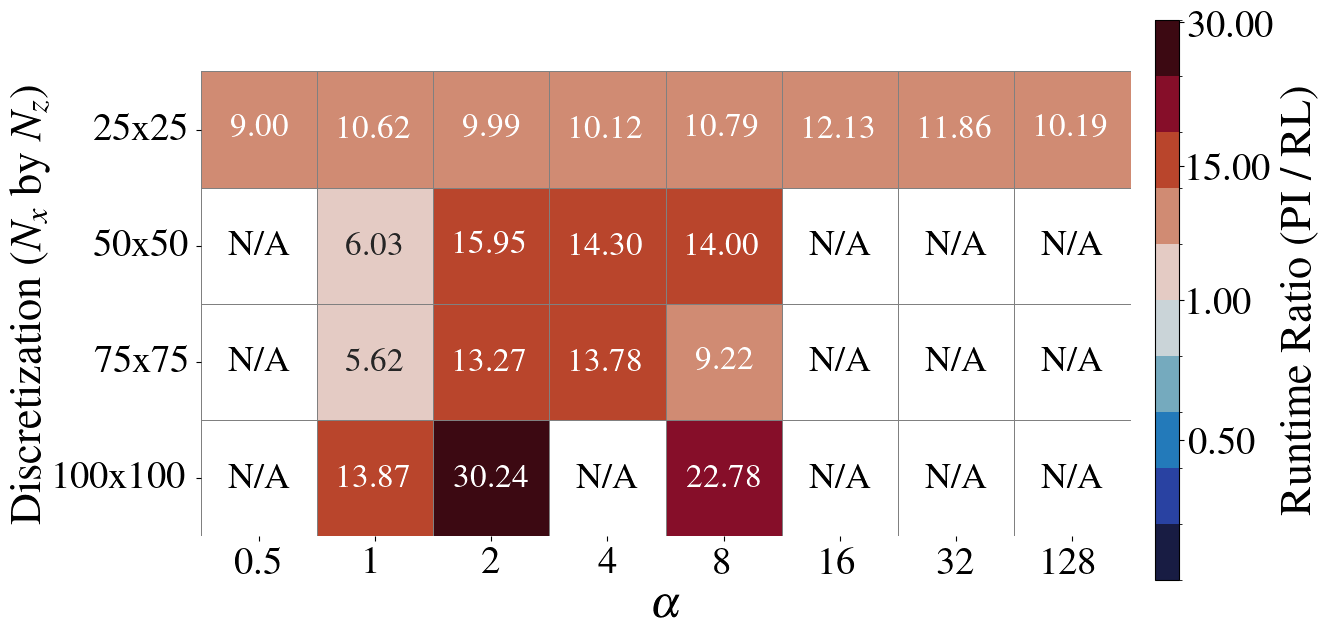

In [33]:

df_3by3 = create_runtime_ratio_heatmap_external_pi(
              rl_glob="eval_results_3by3_*.json",   # RL on 3by3 grids
              # PI baselines: use the dedicated PI files, not the general ones
              pi_glob="eval_results_*.json",     # external PI baselines
        aggregate="min",                      # fastest RL per alpha
             method_filter_prefix=None,            # or "TQC " if you only want TQC
              rl_exclude=None,                      # nothing special to exclude
              pi_exclude=["_PI_"],                      # or e.g. ["5by5"] if needed
             save_path="figure5a.pdf",
              n_bins_diverging=10,
              verbose=True,
    )




Loading PI_baseline from eval_results_3by3_*.json:
  Found: ['eval_results_3by3_100x100.json', 'eval_results_3by3_25x25.json', 'eval_results_3by3_50x50.json', 'eval_results_3by3_75x75.json']
  eval_results_3by3_100x100.json: label=100x100, runtime=12096.982s, s_end=2.392e+02
  eval_results_3by3_25x25.json: label=25x25, runtime=12.651s, s_end=2.383e+02
  eval_results_3by3_50x50.json: label=50x50, runtime=503.082s, s_end=2.388e+02
  eval_results_3by3_75x75.json: label=75x75, runtime=3438.533s, s_end=2.391e+02

Loading PI_baseline from eval_results_PI_*.json:
  Found: ['eval_results_PI_25x25.json', 'eval_results_PI_50x50.json', 'eval_results_PI_75x75.json']
  eval_results_PI_25x25.json: label=25x25, runtime=14.041s, s_end=2.383e+02
  eval_results_PI_50x50.json: label=50x50, runtime=545.823s, s_end=2.388e+02
  eval_results_PI_75x75.json: label=75x75, runtime=3448.510s, s_end=2.391e+02

Loading constant-stepper files from .:
  Found: ['constant_stepper_100by100.npz', 'constant_stepper_25by

/tmp/ipykernel_26110/3992635527.py:324: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax1.legend()



Saved ratios figure (constant-stepper reference) to ratios_vs_discretization_const_ref.png


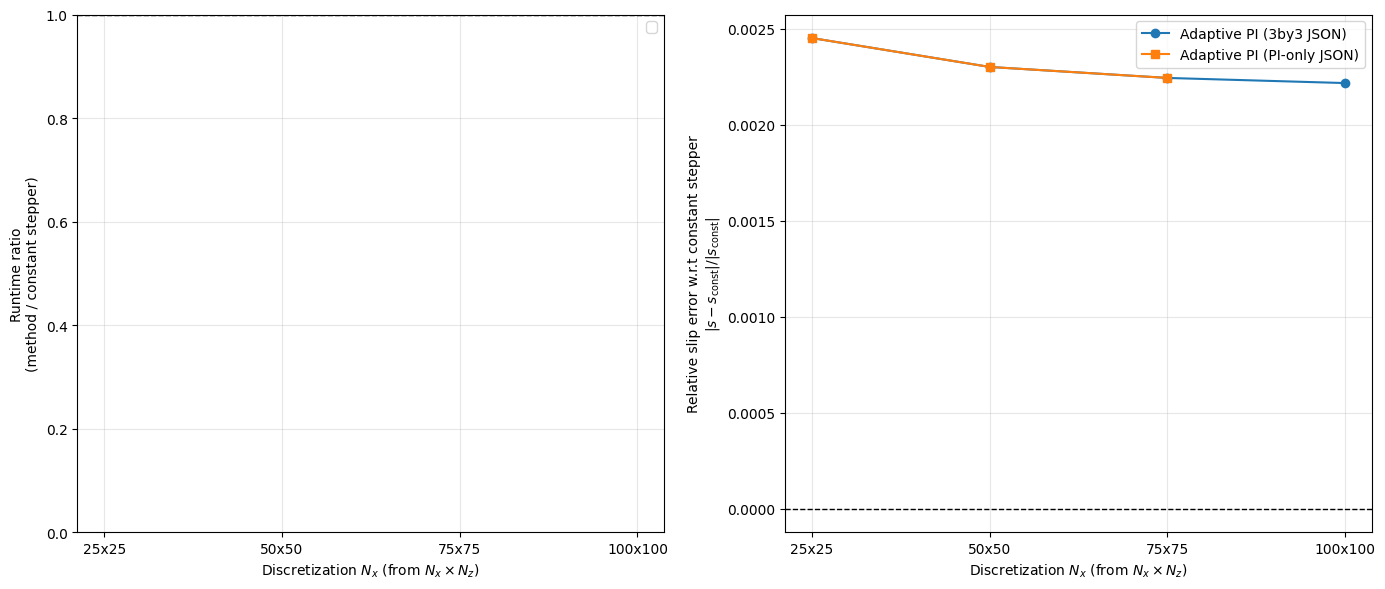

In [ ]:
# import os
# import json
# from pathlib import Path

# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt

# # ============================================================
# # Helpers to load PI JSON results
# # ============================================================

# def load_pi_jsons(glob_pattern: str,
#                   stem_prefix_to_strip: str,
#                   ignore_5by5: bool = True,
#                   verbose: bool = True):
#     """
#     Load PI_baseline runtime and s_end_mean from all JSON files
#     matching glob_pattern.

#     Returns
#     -------
#     dict[label] -> dict(runtime_s, s_end)
#         label is e.g. '25x25', '50x50', ...
#     """
#     results = {}
#     files = sorted(Path(".").glob(glob_pattern))
#     if verbose:
#         print(f"\nLoading PI_baseline from {glob_pattern}:")
#         print("  Found:", [f.name for f in files])

#     for path in files:
#         stem = path.stem
#         if ignore_5by5 and "5by5" in stem:
#             if verbose:
#                 print(f"  Skipping {path.name} (5by5)")
#             continue

#         label = stem.replace(stem_prefix_to_strip, "")
#         try:
#             with open(path, "r", encoding="utf-8") as fh:
#                 data = json.load(fh)
#         except Exception as e:
#             if verbose:
#                 print(f"  [WARN] Failed to read {path.name}: {e}")
#             continue

#         pi_data = data.get("PI_baseline", {})
#         runtime = float(pi_data.get("runtime_s", np.nan))
#         s_end = pi_data.get("s_end_mean", None)
#         if s_end is None:
#             s_end = np.nan
#         else:
#             # already scaled to physical units in your evaluation code
#             s_end = float(s_end)

#         if not np.isfinite(runtime):
#             if verbose:
#                 print(f"  [WARN] {path.name}: invalid runtime {runtime}")
#             continue

#         results[label] = dict(runtime_s=runtime, s_end=s_end)
#         if verbose:
#             print(f"  {path.name}: label={label}, runtime={runtime:.3f}s, s_end={s_end:.3e}")

#     return results


# # ============================================================
# # Helper to load constant stepper NPZ results
# # ============================================================

# def load_constant_stepper_results(output_dir: str,
#                                   verbose: bool = True):
#     """
#     Load constant-stepper results for all files like
#     'constant_stepper_50by50.npz' in output_dir.

#     Uses build_fault_and_solver(Nz, Nx) to get N_DOFS and Dscale,
#     then computes average slip at final time and scales it.

#     Returns
#     -------
#     dict[label] -> dict(runtime_s, s_end)
#         label is e.g. '25x25', '50x50', ...
#         runtime_s may be NaN if not stored in npz.
#     """
#     # sanity check: build_fault_and_solver must exist
#     if "build_fault_and_solver" not in globals():
#         raise NameError(
#             "build_fault_and_solver(Nz, Nx) must be defined before "
#             "calling load_constant_stepper_results."
#         )

#     const_results = {}
#     out_path = Path(output_dir)

#     pattern = "constant_stepper_*by*.npz"
#     files = sorted(out_path.glob(pattern))
#     if verbose:
#         print(f"\nLoading constant-stepper files from {output_dir}:")
#         print("  Found:", [f.name for f in files])

#     for npz_path in files:
#         stem = npz_path.stem  # e.g. 'constant_stepper_50by50'
#         grid_part = stem.replace("constant_stepper_", "")  # '50by50'

#         try:
#             Nz_str, Nx_str = grid_part.split("by")
#             Nz, Nx = int(Nz_str), int(Nx_str)
#         except Exception as e:
#             if verbose:
#                 print(f"  [WARN] Could not parse Nz,Nx from {stem}: {e}")
#             continue

#         # build fault to get Dscale and N_DOFS
#         grid = build_fault_and_solver(Nz, Nx)
#         fault = grid["fault"]
#         N = grid["N_DOFS"]
#         Dscale = fault.Dscale

#         data = np.load(npz_path)

#         if "ts1" not in data.files or "ys1" not in data.files:
#             if verbose:
#                 print(f"  [WARN] {npz_path.name} missing ts1/ys1; skipping.")
#             continue

#         ts = data["ts1"]
#         ys = data["ys1"]

#         if ys.shape[1] < 3 * N:
#             if verbose:
#                 print(f"  [WARN] {npz_path.name}: ys shape {ys.shape} < 3*N={3*N}; skipping.")
#             continue

#         # slip block (dimensionless), average over DOFs, then scale to physical
#         s_block = ys[:, 2*N:3*N]
#         avg_s_dimless = np.mean(s_block, axis=1)
#         avg_s_phys = avg_s_dimless * Dscale
#         s_end = float(avg_s_phys[-1])

#         # runtime if stored inside npz
#         if "runtime_s" in data.files:
#             runtime_s = float(data["runtime_s"])
#         elif "wall_time" in data.files:
#             runtime_s = float(data["wall_time"])
#         else:
#             runtime_s = np.nan
#             if verbose:
#                 print(f"  [INFO] {npz_path.name}: no runtime in file, setting runtime_s=NaN.")

#         label = f"{Nz}x{Nx}"
#         const_results[label] = dict(runtime_s=runtime_s, s_end=s_end)
#         if verbose:
#             print(f"  {npz_path.name}: label={label}, runtime={runtime_s:.3f}s, s_end={s_end:.3e}")

#     return const_results


# # ============================================================
# # Sorting helper for labels like '25x25'
# # ============================================================

# def _grid_sort_key(label: str) -> int:
#     try:
#         return int(label.split("x")[0])
#     except Exception:
#         return 0


# # ============================================================
# # Main plotting: ratios vs discretization, constant stepper reference
# # ============================================================

# def scatter_runtime_vs_error(
#     const_output_dir: str,
#     threeby3_glob: str = "eval_results_3by3_*.json",
#     pionly_glob: str = "eval_results_PI_*.json",
#     save_path: str = "ratios_vs_discretization_const_ref.png",
#     verbose: bool = True,
# ):
#     """
#     Plot, versus discretization size, for each grid:

#       Reference method: CONSTANT STEPPER (s_const, runtime_const_s)

#       Panel (a): Runtime ratios (method / constant-stepper)
#           - Adaptive PI from 3by3 JSON:    runtime_PI_3by3_s / runtime_const_s
#           - Adaptive PI from PI-only JSON: runtime_PI_only_s / runtime_const_s

#       Panel (b): Relative slip error vs constant-stepper slip
#           - |s_PI_3by3 - s_const| / |s_const|
#           - |s_PI_only - s_const| / |s_const|
#     """

#     # 1) load PI results (3by3 + PI-only)
#     pi_3by3 = load_pi_jsons(
#         threeby3_glob,
#         stem_prefix_to_strip="eval_results_3by3_",
#         verbose=verbose,
#     )
#     pi_only = load_pi_jsons(
#         pionly_glob,
#         stem_prefix_to_strip="eval_results_PI_",
#         verbose=verbose,
#     )

#     # 2) load constant stepper results (REFERENCE)
#     const_res = load_constant_stepper_results(const_output_dir, verbose=verbose)

#     # 3) build combined table
#     all_labels = sorted(
#         set(pi_3by3.keys()) | set(pi_only.keys()) | set(const_res.keys()),
#         key=_grid_sort_key,
#     )
#     if verbose:
#         print("\nAll grid labels found:", all_labels)

#     rows = []
#     for label in all_labels:
#         r_pi3 = pi_3by3.get(label, {})
#         r_pio = pi_only.get(label, {})
#         r_con = const_res.get(label, {})

#         rows.append(
#             {
#                 "grid": label,
#                 "runtime_PI_3by3_s": r_pi3.get("runtime_s", np.nan),
#                 "s_PI_3by3": r_pi3.get("s_end", np.nan),
#                 "runtime_PI_only_s": r_pio.get("runtime_s", np.nan),
#                 "s_PI_only": r_pio.get("s_end", np.nan),
#                 "runtime_const_s": r_con.get("runtime_s", np.nan),
#                 "s_const": r_con.get("s_end", np.nan),
#             }
#         )

#     df = pd.DataFrame(rows).set_index("grid")

#     if verbose:
#         print("\nCombined DataFrame (raw):")
#         print(df)

#     # 4) add discretization size Nx for x-axis
#     def _nx_from_label(lbl: str) -> float:
#         try:
#             return float(lbl.split("x")[0])
#         except Exception:
#             return np.nan

#     df["Nx"] = [_nx_from_label(g) for g in df.index]
#     df = df.sort_values("Nx")

#     # 5) Reference = CONSTANT STEPPER
#     df["runtime_ref"] = df["runtime_const_s"]
#     df["s_ref"] = df["s_const"]

#     # 6) safe operations
#     def safe_ratio(num, den):
#         num = np.asarray(num, dtype=float)
#         den = np.asarray(den, dtype=float)
#         out = np.full_like(num, np.nan, dtype=float)
#         mask = np.isfinite(num) & np.isfinite(den) & (den != 0.0)
#         out[mask] = num[mask] / den[mask]
#         return out

#     def safe_rel_err(val, ref):
#         val = np.asarray(val, dtype=float)
#         ref = np.asarray(ref, dtype=float)
#         out = np.full_like(val, np.nan, dtype=float)
#         mask = np.isfinite(val) & np.isfinite(ref) & (ref != 0.0)
#         out[mask] = np.abs(val[mask] - ref[mask]) / np.abs(ref[mask])
#         return out

#     # 7) Runtime ratios wrt constant stepper
#     df["rt_ratio_PI_3by3"] = safe_ratio(df["runtime_PI_3by3_s"], df["runtime_ref"])
#     df["rt_ratio_PI_only"] = safe_ratio(df["runtime_PI_only_s"], df["runtime_ref"])

#     # 8) Relative slip errors wrt constant stepper slip
#     df["rel_err_PI_3by3"] = safe_rel_err(df["s_PI_3by3"], df["s_ref"])
#     df["rel_err_PI_only"] = safe_rel_err(df["s_PI_only"], df["s_ref"])

#     if verbose:
#         print("\nDataFrame with constant-stepper reference:")
#         print(df[[
#             "Nx",
#             "runtime_ref",
#             "rt_ratio_PI_3by3", "rt_ratio_PI_only",
#             "s_ref",
#             "rel_err_PI_3by3", "rel_err_PI_only",
#         ]])

#     # 9) Plot: two panels vs discretization size
#     fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), sharex=True)

#     x = df["Nx"].values
#     xticklabels = df.index.tolist()

#     # ---- Panel (a): runtime ratios ----
#     mask_pi3 = np.isfinite(df["rt_ratio_PI_3by3"])
#     mask_pio = np.isfinite(df["rt_ratio_PI_only"])

#     if mask_pi3.any():
#         ax1.plot(
#             x[mask_pi3],
#             df.loc[mask_pi3, "rt_ratio_PI_3by3"],
#             "o-",
#             label="Adaptive PI (3by3 JSON)",
#         )
#     if mask_pio.any():
#         ax1.plot(
#             x[mask_pio],
#             df.loc[mask_pio, "rt_ratio_PI_only"],
#             "s-",
#             label="Adaptive PI (PI-only JSON)",
#         )

#     ax1.axhline(1.0, color="k", linestyle="--", linewidth=1)
#     ax1.set_ylabel("Runtime ratio\n(method / constant stepper)")
#     ax1.set_xlabel(r"Discretization $N_x$ (from $N_x \times N_z$)")
#     ax1.set_xticks(x)
#     ax1.set_xticklabels(xticklabels, rotation=0)
#     ax1.grid(True, alpha=0.3)
#     ax1.legend()

#     # ---- Panel (b): relative slip errors ----
#     mask_pi3_e = np.isfinite(df["rel_err_PI_3by3"])
#     mask_pio_e = np.isfinite(df["rel_err_PI_only"])

#     if mask_pi3_e.any():
#         ax2.plot(
#             x[mask_pi3_e],
#             df.loc[mask_pi3_e, "rel_err_PI_3by3"],
#             "o-",
#             label="Adaptive PI (3by3 JSON)",
#         )
#     if mask_pio_e.any():
#         ax2.plot(
#             x[mask_pio_e],
#             df.loc[mask_pio_e, "rel_err_PI_only"],
#             "s-",
#             label="Adaptive PI (PI-only JSON)",
#         )

#     ax2.axhline(0.0, color="k", linestyle="--", linewidth=1)
#     ax2.set_ylabel(
#         r"Relative slip error w.r.t constant stepper"
#         + "\n"
#         + r"$|s - s_{\rm const}|/|s_{\rm const}|$"
#     )
#     ax2.set_xlabel(r"Discretization $N_x$ (from $N_x \times N_z$)")
#     ax2.set_xticks(x)
#     ax2.set_xticklabels(xticklabels, rotation=0)
#     ax2.grid(True, alpha=0.3)
#     ax2.legend()

#     fig.tight_layout()
#     fig.savefig(save_path, dpi=150, bbox_inches="tight")
#     print(f"\nSaved ratios figure (constant-stepper reference) to {save_path}")
#     plt.show()

#     return df


# # ============================================================
# # Run if executed as a script / from this cell
# # ============================================================

# if __name__ == "__main__":
#     # directory where your constant_stepper_*.npz live
#     CONST_OUTPUT_DIR = "."  # adjust if needed

#     df_summary = scatter_runtime_vs_error(
#         const_output_dir=CONST_OUTPUT_DIR,
#         threeby3_glob="eval_results_3by3_*.json",
#         pionly_glob="eval_results_PI_*.json",
#         save_path="ratios_vs_discretization_const_ref.png",
#         verbose=True,
#     )



Loading constant-stepper files from ., pattern='constant_stepper_*by*.npz':
  Found: ['constant_stepper_100by100.npz', 'constant_stepper_25by25.npz', 'constant_stepper_50by50.npz', 'constant_stepper_75by75.npz']
Loading: ./Data/kijs_100x100elem-3x3length.npy
Theoretical value of total stiffness assuming a patch of dimensions Lx x Lz:  3.501230118388745e-07
Approximate value of total stiffness assuming a patch of length Lx:  3.333333333333333e-07
Calculated value:  1.1492959183203097e-06
Units are in: mm,N,ms,MPa,gr
  [INFO] constant_stepper_100by100.npz: no runtime in file, setting runtime_s=NaN.
  constant_stepper_100by100.npz: label=100x100, runtime=nans, s_end=2.387e+02
Loading: ./Data/kijs_25x25elem-3x3length.npy
Theoretical value of total stiffness assuming a patch of dimensions Lx x Lz:  3.501230118388745e-07
Approximate value of total stiffness assuming a patch of length Lx:  3.333333333333333e-07
Calculated value:  8.802054671146341e-07
Units are in: mm,N,ms,MPa,gr
  [INFO] co

/tmp/ipykernel_6408/165394856.py:683: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0.03, 0.05, 0.90, 0.95])



Saved error heatmaps to figure8.pdf


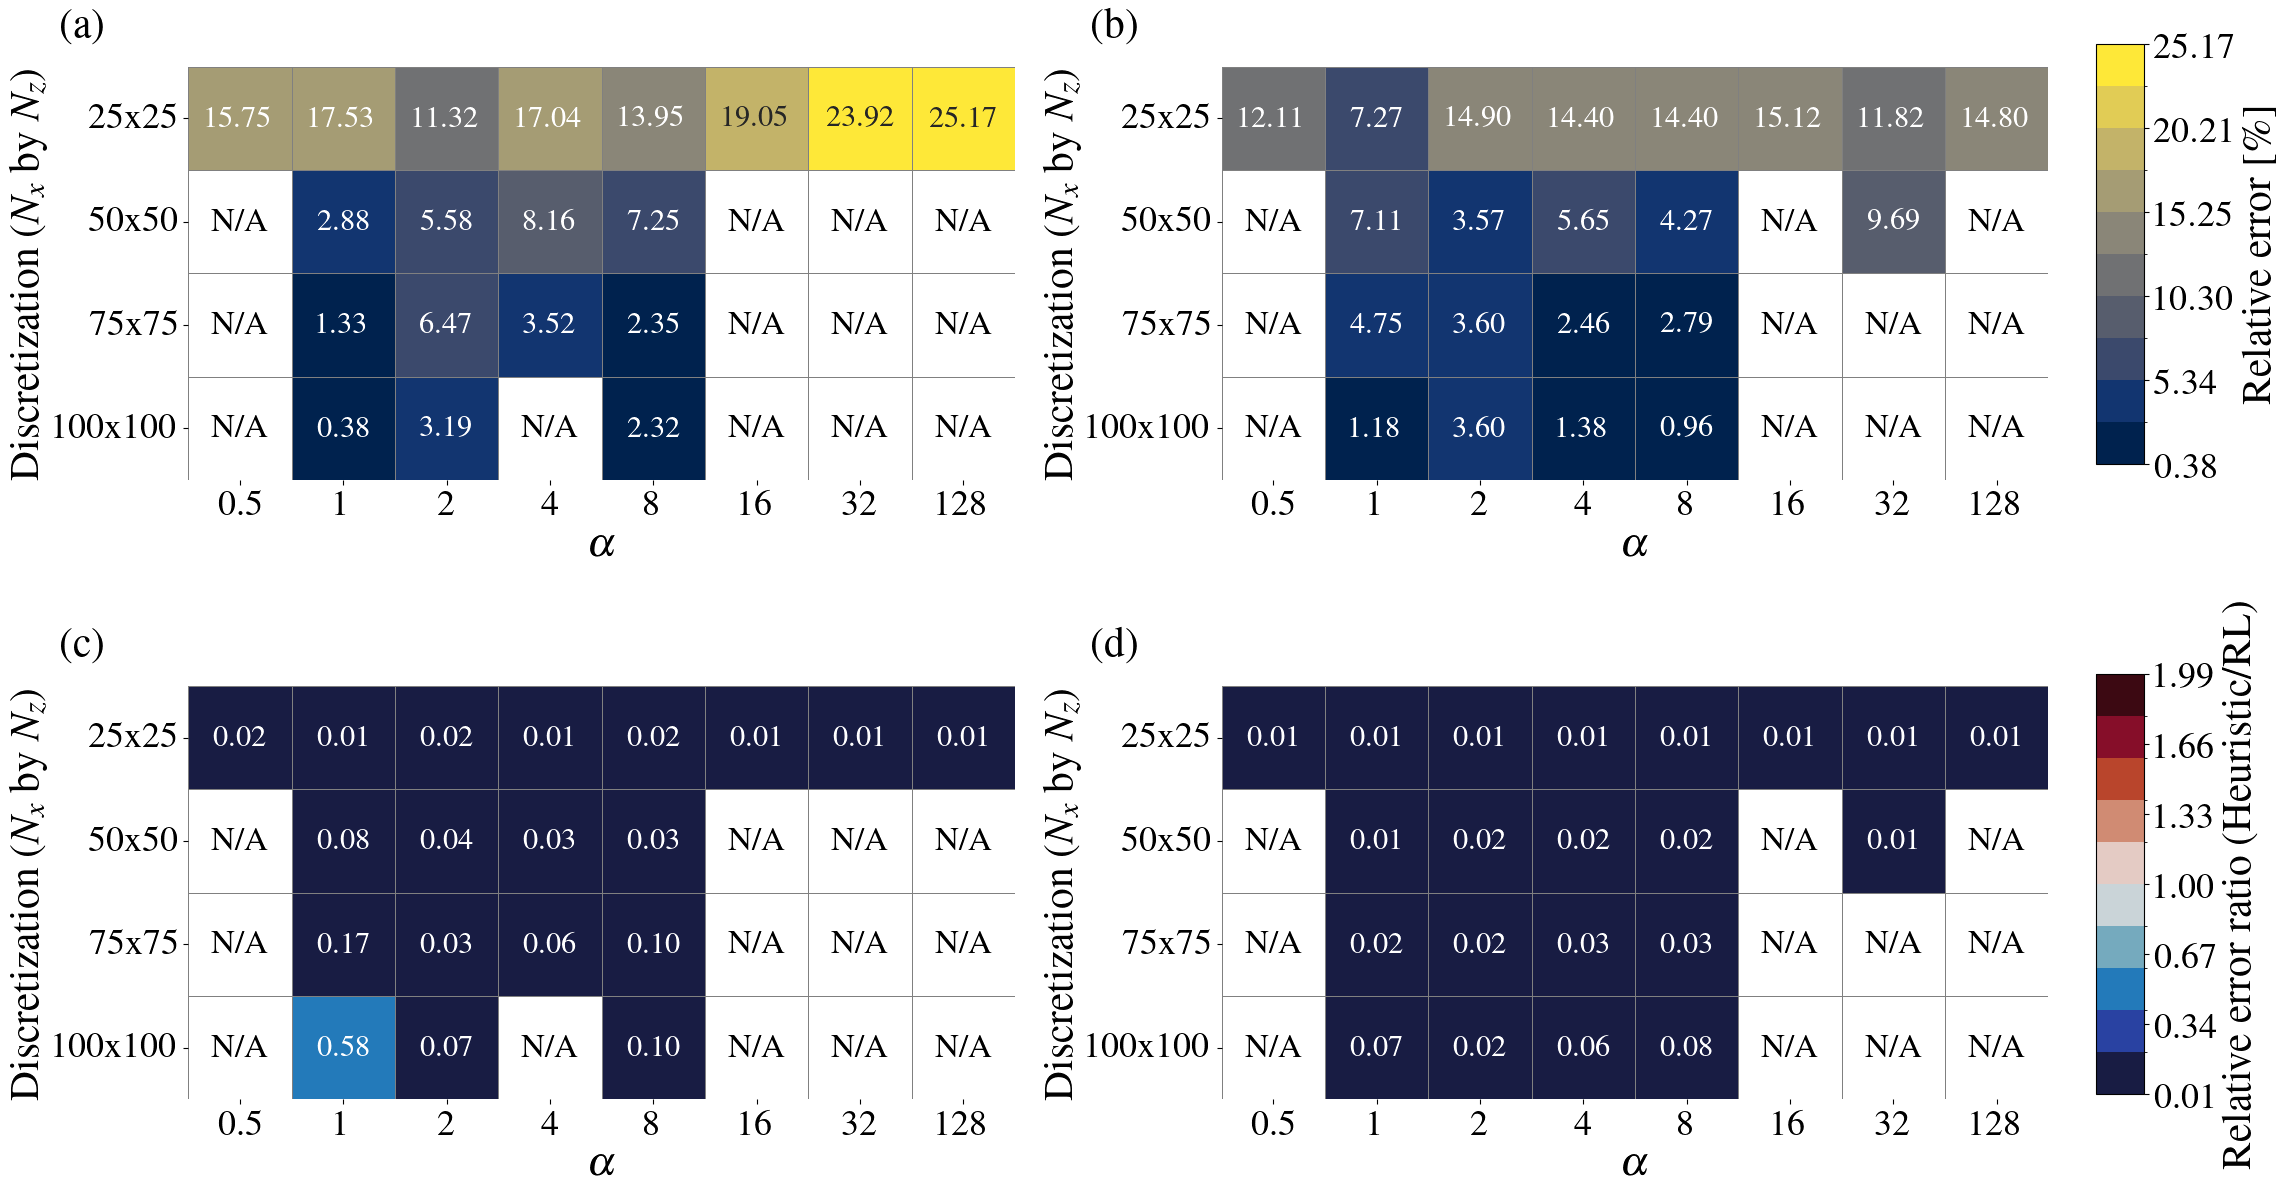

In [22]:
import json
import re
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib.colors import BoundaryNorm, ListedColormap
from matplotlib.cm import ScalarMappable

from plants.faults import strikeslip  # you already have this in your project

# ============================================================
# Global style (your settings)
# ============================================================
sizes = 30
plt.rcParams.update({
    'font.size': sizes,
    'axes.titlesize': sizes,
    'axes.labelsize': sizes,
    'xtick.labelsize': sizes,
    'ytick.labelsize': sizes,
    'legend.fontsize': sizes,
    'figure.titlesize': sizes,
    'text.usetex': True,
    'font.family': 'Times',
    'pdf.fonttype': 42,
    'ps.fonttype': 42,
    'text.latex.preamble': r'\usepackage{amsmath}\usepackage{mathptmx}',
    'axes.grid': False,
})

# optional cmocean
try:
    import cmocean
    _HAS_CMOCEAN = True
except Exception:
    _HAS_CMOCEAN = False
    print("[INFO] cmocean not found. Falling back to 'coolwarm' for diverging maps.")


# ============================================================
# Minimal fault builder (patch-size aware)
# ============================================================
def build_fault_and_solver(Nz: int, Nx: int, patch_size: int = 3):
    """
    Minimal helper for post-processing: build a quasi-static strike-slip fault
    for a given grid and patch size; return fault and N_DOFS.

    patch_size = zdepth = xlength = 3 (for 3x3 case) or 5 (for 5x5 case).
    """
    fault_local = strikeslip.qs_strikeslip_fault(
        zdepth=patch_size,
        xlength=patch_size,
        Nz=Nz,
        Nx=Nx,
        G=30000.0,
        rho=2.5e-3,
        zeta=0.8 / patch_size,
        Ks_path="./Data/",
        gamma_s=25.0,
        gamma_w=10.0,
        sigma_ref=100.0,
        depth_ini=0.0,
        vinf=3.171e-10,
        Dmu_estimate=0.5,
    )

    N_DOFS_l = fault_local.N
    return {
        "fault": fault_local,
        "N_DOFS": N_DOFS_l,
    }


# ============================================================
# Low-level helpers
# ============================================================
def _parse_alpha(method_name: str) -> float | None:
    m = re.search(r'alpha\s*=\s*([0-9.+-eE]+)', method_name)
    if not m:
        return None
    try:
        return float(m.group(1))
    except Exception:
        return None


def _aggregate_values(vals: list[float], how: str) -> float:
    arr = np.array([v for v in vals if np.isfinite(v) and v >= 0.0], dtype=float)
    if arr.size == 0:
        return np.nan
    how = how.lower()
    if how == "min":
        return float(np.min(arr))
    if how == "mean":
        return float(np.mean(arr))
    if how == "max":
        return float(np.max(arr))
    return float(np.min(arr))


def _annotations(df: pd.DataFrame) -> pd.DataFrame:
    if hasattr(df, "map"):
        return df.map(lambda x: f"{x:.2f}" if pd.notna(x) else "")
    return df.applymap(lambda x: f"{x:.2f}" if pd.notna(x) else "")


def _overlay_na(ax, df: pd.DataFrame, fontsize=12, color="black"):
    for y in range(df.shape[0]):
        for x in range(df.shape[1]):
            if pd.isna(df.iat[y, x]):
                ax.text(x + 0.5, y + 0.5, "N/A",
                        ha="center", va="center",
                        fontsize=fontsize, color=color)


def _symmetric_limits_around_one(vals_all: np.ndarray):
    vals_all = vals_all[np.isfinite(vals_all)]
    if vals_all.size == 0:
        return 0.5, 1.5
    vmin_real = float(np.min(vals_all))
    vmax_real = float(np.max(vals_all))
    delta_low = max(0.0, 1.0 - vmin_real)
    delta_high = max(0.0, vmax_real - 1.0)
    half_span = max(delta_low, delta_high)
    vmin_sym = max(1.0 - half_span, 1e-12)
    vmax_sym = 1.0 + half_span
    return vmin_sym, vmax_sym


def _diverging_levels(vmin_sym: float, vmax_sym: float, n_bins_total: int):
    if n_bins_total % 2 == 1:
        n_bins_total += 1
    n_half = n_bins_total // 2
    lower = np.linspace(vmin_sym, 1.0, n_half + 1)[:-1]
    upper = np.linspace(1.0, vmax_sym, n_half + 1)
    return np.concatenate([lower, upper])  # len = n_bins_total + 1


def _sequential_levels(vals_all: np.ndarray, n_bins: int):
    vals_all = vals_all[np.isfinite(vals_all)]
    if vals_all.size == 0:
        vmin, vmax = 0.0, 1.0
    else:
        vmin = float(np.min(vals_all))
        vmax = float(np.max(vals_all))
        if vmin == vmax:
            vmin = max(0.0, vmin - 1e-6)
            vmax = vmin + 1e-6
    return np.linspace(vmin, vmax, int(n_bins) + 1)


# ============================================================
# Constant-stepper loader (scenario-aware)
# ============================================================
def load_constant_stepper_results(output_dir: str,
                                  file_pattern: str,
                                  patch_size: int,
                                  exclude_substrings: list[str] | None = None,
                                  verbose: bool = True):
    """
    Load constant-stepper results for files like:

      - "constant_stepper_25by25.npz"          (for 3x3 scenario)
      - "constant_stepper_25by25_5by5.npz"    (for 5x5 scenario)

    `patch_size` controls zdepth=xlength used when building the fault
    (3 for 3x3, 5 for 5x5).

    Returns
    -------
    dict[label] -> dict(runtime_s, s_end)
        label is e.g. '25x25', '50x50', ...
        runtime_s may be NaN if not stored in npz.
    """
    const_results: dict[str, dict] = {}
    out_path = Path(output_dir)

    files = sorted(out_path.glob(file_pattern))
    if exclude_substrings:
        files = [
            f for f in files
            if not any(sub in f.name for sub in exclude_substrings)
        ]

    if verbose:
        print(f"\nLoading constant-stepper files from {output_dir}, pattern='{file_pattern}':")
        print("  Found:", [f.name for f in files])

    for npz_path in files:
        stem = npz_path.stem  # e.g. 'constant_stepper_25by25' or 'constant_stepper_25by25_5by5'
        rest = stem.replace("constant_stepper_", "")  # '25by25' or '25by25_5by5'
        grid_token = rest.split("_")[0]              # always '25by25'

        try:
            Nz_str, Nx_str = grid_token.split("by")
            Nz, Nx = int(Nz_str), int(Nx_str)
        except Exception as e:
            if verbose:
                print(f"  [WARN] Could not parse Nz,Nx from '{rest}' in {stem}: {e}")
            continue

        grid = build_fault_and_solver(Nz, Nx, patch_size=patch_size)
        fault = grid["fault"]
        N = grid["N_DOFS"]
        Dscale = fault.Dscale

        data = np.load(npz_path)

        if "ts1" not in data.files or "ys1" not in data.files:
            if verbose:
                print(f"  [WARN] {npz_path.name} missing ts1/ys1; skipping.")
            continue

        ys = data["ys1"]

        if ys.shape[1] < 3 * N:
            if verbose:
                print(f"  [WARN] {npz_path.name}: ys shape {ys.shape} < 3*N={3*N}; skipping.")
            continue

        # slip block (dimensionless) -> average over DOFs -> scale to physical
        s_block = ys[:, 2*N:3*N]
        avg_s_dimless = np.mean(s_block, axis=1)
        avg_s_phys = avg_s_dimless * Dscale
        s_end = float(avg_s_phys[-1])

        # runtime if stored inside npz
        if "runtime_s" in data.files:
            runtime_s = float(data["runtime_s"])
        elif "wall_time" in data.files:
            runtime_s = float(data["wall_time"])
        else:
            runtime_s = np.nan
            if verbose:
                print(f"  [INFO] {npz_path.name}: no runtime in file, setting runtime_s=NaN.")

        label = f"{Nz}x{Nx}"
        const_results[label] = dict(runtime_s=runtime_s, s_end=s_end)
        if verbose:
            print(f"  {npz_path.name}: label={label}, runtime={runtime_s:.3f}s, s_end={s_end:.3e}")

    return const_results


# ============================================================
# Error matrices (RL relative error, PI/RL error ratio)
# ============================================================
def compute_error_dfs_for_dataset(
    results_glob: str,
    const_results: dict[str, dict],
    aggregate: str = "min",
    method_filter_prefix: str | None = None,
    exclude_substrings: list[str] | None = None,
    verbose: bool = True,
):
    """
    For a given eval_results_*.json family (3by3 or 5by5), build:

      - rl_err_df:   RL relative error heatmap vs constant stepper (in %)
      - ratio_df:    (PI relative error) / (RL relative error)  (dimensionless)

    Both are DataFrames with:
        index  = discretization label (e.g. '25x25', '50x50')
        columns = alpha values (as strings)
    """
    eval_files = sorted(Path(".").glob(results_glob))
    if exclude_substrings:
        eval_files = [
            f for f in eval_files
            if not any(sub in f.name for sub in exclude_substrings)
        ]
    if not eval_files:
        print(f"[WARN] No files for glob '{results_glob}' after excludes={exclude_substrings}")
        return None, None

    if verbose:
        print(f"\nLoading files for glob '{results_glob}' (excludes={exclude_substrings}):")
        print("  ", [f.name for f in eval_files])

    all_data: dict[str, dict] = {}
    for f in eval_files:
        grid_label_full = f.stem.replace("eval_results_", "")   # e.g. '3by3_25x25'
        with open(f, "r", encoding="utf-8") as fh:
            data = json.load(fh)
        all_data[grid_label_full] = data
        if verbose:
            print(f"  Loaded {f.name}: keys={list(data.keys())}")

    # collect all alphas
    all_alphas = set()
    for grid_data in all_data.values():
        for method_name in grid_data.keys():
            if method_name == "PI_baseline":
                continue
            if method_filter_prefix and not method_name.startswith(method_filter_prefix):
                continue
            a = _parse_alpha(method_name)
            if a is not None:
                all_alphas.add(a)

    if not all_alphas:
        print(f"[WARN] No RL methods with alpha=* in '{results_glob}'")
        return None, None

    alphas_sorted = sorted(all_alphas)
    alpha_labels = [f"{a:g}" for a in alphas_sorted]

    full_labels = list(all_data.keys())
    disc_labels = [lab.split("_")[-1] for lab in full_labels]

    rl_err_mat = np.full((len(full_labels), len(alphas_sorted)), np.nan, dtype=float)
    ratio_mat  = np.full((len(full_labels), len(alphas_sorted)), np.nan, dtype=float)

    for i, full_label in enumerate(full_labels):
        grid_data = all_data[full_label]
        disc_label = disc_labels[i]

        const_entry = const_results.get(disc_label, None)
        if const_entry is None:
            if verbose:
                print(f"  [WARN] No constant-stepper result for grid '{disc_label}'")
            continue

        s_const = const_entry.get("s_end", np.nan)
        if not (np.isfinite(s_const) and s_const != 0.0):
            if verbose:
                print(f"  [WARN] Invalid s_const for grid '{disc_label}': {s_const}")
            continue

        # RL errors per alpha (in %)
        per_alpha_rl_errs: dict[float, list[float]] = {a: [] for a in alphas_sorted}

        for method_name, method_data in grid_data.items():
            if method_name == "PI_baseline":
                continue
            if method_filter_prefix and not method_name.startswith(method_filter_prefix):
                continue

            a = _parse_alpha(method_name)
            if a is None:
                continue

            converged = bool(method_data.get("converged", False))
            success_rate = float(method_data.get("success_rate", 0.0))
            if not (converged or success_rate > 0.0):
                continue

            s_rl = method_data.get("s_end_mean", None)
            if s_rl is None:
                continue
            s_rl = float(s_rl)
            if not np.isfinite(s_rl):
                continue

            # --- relative error in percent ---
            err_rl = abs(s_rl - s_const) / abs(s_const) * 100.0
            if not np.isfinite(err_rl):
                continue

            for a_target in per_alpha_rl_errs.keys():
                if abs(a - a_target) < 1e-12:
                    per_alpha_rl_errs[a_target].append(err_rl)
                    break

        # PI error (single value per grid, also in %)
        pi_data = grid_data.get("PI_baseline", {})
        s_pi = pi_data.get("s_end_mean", None)
        if s_pi is None or not np.isfinite(float(s_pi)):
            err_pi = np.nan
        else:
            s_pi = float(s_pi)
            err_pi = abs(s_pi - s_const) / abs(s_const) * 100.0

        # aggregate RL errors, and build ratio (dimensionless)
        for j, a in enumerate(alphas_sorted):
            rl_agg_err = _aggregate_values(per_alpha_rl_errs[a], aggregate)
            if np.isfinite(rl_agg_err):
                rl_err_mat[i, j] = rl_agg_err
                if np.isfinite(err_pi) and rl_agg_err > 0.0:
                    ratio_mat[i, j] = err_pi / rl_agg_err

            if verbose and np.isfinite(rl_agg_err):
                print(f"  Grid {full_label:>12s}, alpha={a:g}: "
                      f"err_RL={rl_agg_err:.3e} %, err_PI={err_pi:.3e} %, "
                      f"ratio={ratio_mat[i,j]:.2f}")

    rl_err_df = pd.DataFrame(rl_err_mat, index=disc_labels, columns=alpha_labels)
    ratio_df  = pd.DataFrame(ratio_mat,  index=disc_labels, columns=alpha_labels)

    # sort rows by discretization (Nx)
    def _disc_key(lbl: str):
        try:
            return int(lbl.split('x')[0])
        except Exception:
            return lbl

    rl_err_df = rl_err_df.sort_index(key=lambda idx: [_disc_key(s) for s in idx])
    ratio_df  = ratio_df.sort_index(key=lambda idx: [_disc_key(s) for s in idx])

    # sort columns by alpha numerically
    rl_err_df = rl_err_df.reindex(sorted(rl_err_df.columns, key=lambda s: float(s)), axis=1)
    ratio_df  = ratio_df.reindex(sorted(ratio_df.columns,  key=lambda s: float(s)), axis=1)

    if verbose:
        print("\nRL relative error DataFrame (%):")
        print(rl_err_df)
        print("\nPI/RL error ratio DataFrame:")
        print(ratio_df)

    return rl_err_df, ratio_df


# ============================================================
# Main plotting: 4-panel figure
# ============================================================
def create_error_dual_heatmaps(
    const_output_dir: str = ".",
    glob_a: str = "eval_results_3by3_*.json",
    glob_b: str = "eval_results_5by5_*.json",
    aggregate: str = "min",
    method_filter_prefix: str | None = None,
    exclude_substrings_a: list[str] | None = None,
    exclude_substrings_b: list[str] | None = ["_PI_"],
    save_path: str = "error_rel_and_ratio_3by3_vs_5by5.pdf",
    n_bins_seq: int = 10,
    n_bins_div: int = 10,
    verbose: bool = True,
):
    # 1) Constant-stepper results (separate for 3x3 and 5x5)
    const_results_a = load_constant_stepper_results(
        const_output_dir,
        file_pattern="constant_stepper_*by*.npz",
        patch_size=3,
        exclude_substrings=["_5by5"],  # exclude the 5by5 variants
        verbose=verbose,
    )
    const_results_b = load_constant_stepper_results(
        const_output_dir,
        file_pattern="constant_stepper_*by*_5by5.npz",
        patch_size=5,
        exclude_substrings=None,
        verbose=verbose,
    )

    # 2) Error matrices for 3by3 and 5by5
    rl_err_a, ratio_a = compute_error_dfs_for_dataset(
        results_glob=glob_a,
        const_results=const_results_a,
        aggregate=aggregate,
        method_filter_prefix=method_filter_prefix,
        exclude_substrings=exclude_substrings_a,
        verbose=verbose,
    )
    rl_err_b, ratio_b = compute_error_dfs_for_dataset(
        results_glob=glob_b,
        const_results=const_results_b,
        aggregate=aggregate,
        method_filter_prefix=method_filter_prefix,
        exclude_substrings=exclude_substrings_b,
        verbose=verbose,
    )

    if rl_err_a is None or rl_err_b is None or ratio_a is None or ratio_b is None:
        print("[ERROR] One of the DataFrames is None; aborting.")
        return None, None, None, None

    # --------------------------------------------------------
    # Colormap + levels for RL relative error (sequential, in %)
    # --------------------------------------------------------
    vals_err_a = rl_err_a.values[np.isfinite(rl_err_a.values)]
    vals_err_b = rl_err_b.values[np.isfinite(rl_err_b.values)]
    if vals_err_a.size == 0 and vals_err_b.size == 0:
        print("[ERROR] No finite RL errors.")
        return rl_err_a, rl_err_b, ratio_a, ratio_b

    if vals_err_a.size == 0:
        all_err_vals = vals_err_b
    elif vals_err_b.size == 0:
        all_err_vals = vals_err_a
    else:
        all_err_vals = np.concatenate([vals_err_a, vals_err_b])

    levels_seq = _sequential_levels(all_err_vals, n_bins_seq)
    ncolors_seq = len(levels_seq) - 1
    base_cmap_seq = plt.get_cmap("cividis")
    cmap_seq_disc = ListedColormap(base_cmap_seq(np.linspace(0, 1, ncolors_seq)))
    cmap_seq_disc.set_bad(color="white")
    norm_seq = BoundaryNorm(boundaries=levels_seq, ncolors=ncolors_seq)

    # --------------------------------------------------------
    # Colormap + levels for error ratios (diverging, centered at 1)
    # --------------------------------------------------------
    vals_ratio_a = ratio_a.values[np.isfinite(ratio_a.values)]
    vals_ratio_b = ratio_b.values[np.isfinite(ratio_b.values)]
    if vals_ratio_a.size == 0 and vals_ratio_b.size == 0:
        print("[ERROR] No finite error ratios.")
        return rl_err_a, rl_err_b, ratio_a, ratio_b

    if vals_ratio_a.size == 0:
        all_ratio_vals = vals_ratio_b
    elif vals_ratio_b.size == 0:
        all_ratio_vals = vals_ratio_a
    else:
        all_ratio_vals = np.concatenate([vals_ratio_a, vals_ratio_b])

    vmin_sym, vmax_sym = _symmetric_limits_around_one(all_ratio_vals)
    if n_bins_div % 2 == 1:
        n_bins_div += 1
    levels_div = _diverging_levels(vmin_sym, vmax_sym, n_bins_total=n_bins_div)
    ncolors_div = len(levels_div) - 1

    if _HAS_CMOCEAN:
        base_cmap_div = cmocean.cm.balance
    else:
        base_cmap_div = plt.get_cmap("coolwarm")

    cmap_div_disc = ListedColormap(base_cmap_div(np.linspace(0, 1, ncolors_div)))
    cmap_div_disc.set_bad(color="white")
    norm_div = BoundaryNorm(boundaries=levels_div, ncolors=ncolors_div)

    # --------------------------------------------------------
    # Build the 2x2 figure
    # --------------------------------------------------------
    fig, axes = plt.subplots(
        2, 2, figsize=(24, 14),
        gridspec_kw={"wspace": 0.25, "hspace": 0.35}
    )
    ax_a, ax_b = axes[0]
    ax_c, ax_d = axes[1]

    # Colorbar axes (top for errors, bottom for ratios)
    cax_top = fig.add_axes([0.92, 0.58, 0.02, 0.30])
    cax_bot = fig.add_axes([0.92, 0.13, 0.02, 0.30])

    # --------------------------------------------------------
    # Panel (a): RL relative error, 3by3
    # --------------------------------------------------------
    ann_err_a = _annotations(rl_err_a)
    sns.heatmap(
        rl_err_a,
        annot=ann_err_a.values,
        fmt="",
        cmap=cmap_seq_disc,
        norm=norm_seq,
        mask=rl_err_a.isna(),
        cbar=False,
        annot_kws={"size": sizes - 8},
        linewidths=0.5,
        linecolor="gray",
        square=True,
        ax=ax_a,
    )
    _overlay_na(ax_a, rl_err_a, fontsize=sizes - 6)
    ax_a.set_xlabel(r'$\alpha$', fontsize=sizes)
    ax_a.set_ylabel(r'Discretization ($N_x$ by $N_z$)', fontsize=sizes)
    ax_a.tick_params(axis='both', labelsize=sizes - 4)
    ax_a.text(-0.10, 1.05, r'(a)',
              transform=ax_a.transAxes,
              fontsize=sizes,
              va='bottom', ha='right')

    # --------------------------------------------------------
    # Panel (b): RL relative error, 5by5
    # --------------------------------------------------------
    ann_err_b = _annotations(rl_err_b)
    sns.heatmap(
        rl_err_b,
        annot=ann_err_b.values,
        fmt="",
        cmap=cmap_seq_disc,
        norm=norm_seq,
        mask=rl_err_b.isna(),
        cbar=False,
        annot_kws={"size": sizes - 8},
        linewidths=0.5,
        linecolor="gray",
        square=True,
        ax=ax_b,
    )
    _overlay_na(ax_b, rl_err_b, fontsize=sizes - 6)
    ax_b.set_xlabel(r'$\alpha$', fontsize=sizes)
    ax_b.set_ylabel(r'Discretization ($N_x$ by $N_z$)', fontsize=sizes)
    ax_b.tick_params(axis='both', labelsize=sizes - 4)
    ax_b.text(-0.10, 1.05, r'(b)',
              transform=ax_b.transAxes,
              fontsize=sizes,
              va='bottom', ha='right')

    # --------------------------------------------------------
    # Shared colourbar for RL relative error (top, in %)
    # --------------------------------------------------------
    sm_err = ScalarMappable(norm=norm_seq, cmap=cmap_seq_disc)
    sm_err.set_array([])
    cbar_top = fig.colorbar(sm_err, cax=cax_top)
    cbar_top.set_label(
        r'Relative error [\%]',
        fontsize=sizes
    )
    cbar_top.ax.tick_params(labelsize=sizes - 4)

    # --------------------------------------------------------
    # Panel (c): PI/RL error ratio, 3by3
    # --------------------------------------------------------
    ann_ratio_a = _annotations(ratio_a)
    sns.heatmap(
        ratio_a,
        annot=ann_ratio_a.values,
        fmt="",
        cmap=cmap_div_disc,
        norm=norm_div,
        mask=ratio_a.isna(),
        cbar=False,
        annot_kws={"size": sizes - 8},
        linewidths=0.5,
        linecolor="gray",
        square=True,
        ax=ax_c,
    )
    _overlay_na(ax_c, ratio_a, fontsize=sizes - 6)
    ax_c.set_xlabel(r'$\alpha$', fontsize=sizes)
    ax_c.set_ylabel(r'Discretization ($N_x$ by $N_z$)', fontsize=sizes)
    ax_c.tick_params(axis='both', labelsize=sizes - 4)
    ax_c.text(-0.10, 1.05, r'(c)',
              transform=ax_c.transAxes,
              fontsize=sizes,
              va='bottom', ha='right')

    # --------------------------------------------------------
    # Panel (d): PI/RL error ratio, 5by5
    # --------------------------------------------------------
    ann_ratio_b = _annotations(ratio_b)
    sns.heatmap(
        ratio_b,
        annot=ann_ratio_b.values,
        fmt="",
        cmap=cmap_div_disc,
        norm=norm_div,
        mask=ratio_b.isna(),
        cbar=False,
        annot_kws={"size": sizes - 8},
        linewidths=0.5,
        linecolor="gray",
        square=True,
        ax=ax_d,
    )
    _overlay_na(ax_d, ratio_b, fontsize=sizes - 6)
    ax_d.set_xlabel(r'$\alpha$', fontsize=sizes)
    ax_d.set_ylabel(r'Discretization ($N_x$ by $N_z$)', fontsize=sizes)
    ax_d.tick_params(axis='both', labelsize=sizes - 4)
    ax_d.text(-0.10, 1.05, r'(d)',
              transform=ax_d.transAxes,
              fontsize=sizes,
              va='bottom', ha='right')

    # --------------------------------------------------------
    # Shared colourbar for error ratio (bottom, dimensionless)
    # --------------------------------------------------------
    sm_ratio = ScalarMappable(norm=norm_div, cmap=cmap_div_disc)
    sm_ratio.set_array([])
    cbar_bot = fig.colorbar(sm_ratio, cax=cax_bot)

    # ticks: include 1.0 explicitly
    n_ticks_base = min(7, ncolors_div + 1)
    base_ticks = np.linspace(vmin_sym, vmax_sym, n_ticks_base)
    if len(base_ticks) > 0:
        idx_closest = np.argmin(np.abs(base_ticks - 1.0))
        base_ticks[idx_closest] = 1.0
    ticks = np.sort(np.unique(base_ticks))
    cbar_bot.set_ticks(ticks)
    tick_labels = [f"{t:.2f}" if abs(t - 1.0) > 0.01 else "1.00" for t in ticks]
    cbar_bot.set_ticklabels(tick_labels)

    cbar_bot.set_label(
        r'Relative error ratio (Heuristic/RL)',
        fontsize=sizes
    )
    cbar_bot.ax.tick_params(labelsize=sizes - 4)

    fig.tight_layout(rect=[0.03, 0.05, 0.90, 0.95])
    fig.savefig(save_path, dpi=300, bbox_inches="tight")
    print(f"\nSaved error heatmaps to {save_path}")
    plt.show()

    return rl_err_a, rl_err_b, ratio_a, ratio_b


# ============================================================
# Example call
# ============================================================
if __name__ == "__main__":
    rl_err_3by3, rl_err_5by5, ratio_3by3, ratio_5by5 = create_error_dual_heatmaps(
        const_output_dir=".",                  # where constant_stepper_*.npz live
        glob_a="eval_results_3by3_*.json",
        glob_b="eval_results_5by5_*.json",
        aggregate="min",                       # best RL per alpha
        method_filter_prefix=None,            # or "TQC " if you only want TQC
        exclude_substrings_a=None,
        exclude_substrings_b=["_PI_"],        # exclude eval_results_5by5_PI_*.json
        save_path="figure8.pdf",
        n_bins_seq=10,
        n_bins_div=10,
        verbose=True,
    )


In [23]:
from matplotlib.colors import BoundaryNorm, ListedColormap
from matplotlib.cm import ScalarMappable

def create_combined_runtime_error_dual_heatmap(
    const_output_dir: str = ".",
    glob_a: str = "eval_results_3by3_*.json",
    glob_b: str = "eval_results_5by5_*.json",
    aggregate: str = "min",
    method_filter_prefix: str | None = None,
    exclude_substrings_a: list[str] | None = None,
    exclude_substrings_b: list[str] | None = ["_PI_"],
    save_path: str = "combined_runtime_error_3by3_vs_5by5.pdf",
    n_bins_diverging: int = 10,
    verbose: bool = True,
):
    """
    Build a 2-panel figure:

      (a) 3x3 patch:  (runtime_ratio * error_ratio)
      (b) 5x5 patch:  (runtime_ratio * error_ratio)

    where
      runtime_ratio = T_PI / T_RL             (from compute_runtime_ratio_df)
      error_ratio   = err_PI / err_RL         (from compute_error_dfs_for_dataset,
                                               with constant stepper as reference)

    Both panels use the SAME diverging discrete colormap centered at 1.
    """

    # --------------------------------------------------------
    # 1) Constant-stepper results (3x3 and 5x5)
    # --------------------------------------------------------
    const_results_a = load_constant_stepper_results(
        const_output_dir,
        file_pattern="constant_stepper_*by*.npz",
        patch_size=3,
        exclude_substrings=["_5by5"],  # exclude the 5by5 variants
        verbose=verbose,
    )
    const_results_b = load_constant_stepper_results(
        const_output_dir,
        file_pattern="constant_stepper_*by*_5by5.npz",
        patch_size=5,
        exclude_substrings=None,
        verbose=verbose,
    )

    # --------------------------------------------------------
    # 2) Runtime ratios (PI / RL) for 3by3 and 5by5
    # --------------------------------------------------------
    runtime_ratio_a = compute_runtime_ratio_df(
        results_glob=glob_a,
        aggregate=aggregate,
        method_filter_prefix=method_filter_prefix,
        exclude_substrings=exclude_substrings_a,
        verbose=verbose,
    )
    runtime_ratio_b = compute_runtime_ratio_df(
        results_glob=glob_b,
        aggregate=aggregate,
        method_filter_prefix=method_filter_prefix,
        exclude_substrings=exclude_substrings_b,  # exclude *_PI_ JSONs
        verbose=verbose,
    )

    # --------------------------------------------------------
    # 3) Error ratios (err_PI / err_RL) via constant stepper
    # --------------------------------------------------------
    rl_err_a, ratio_err_a = compute_error_dfs_for_dataset(
        results_glob=glob_a,
        const_results=const_results_a,
        aggregate=aggregate,
        method_filter_prefix=method_filter_prefix,
        exclude_substrings=exclude_substrings_a,
        verbose=verbose,
    )
    rl_err_b, ratio_err_b = compute_error_dfs_for_dataset(
        results_glob=glob_b,
        const_results=const_results_b,
        aggregate=aggregate,
        method_filter_prefix=method_filter_prefix,
        exclude_substrings=exclude_substrings_b,
        verbose=verbose,
    )

    if (runtime_ratio_a is None or runtime_ratio_b is None or
        ratio_err_a is None or ratio_err_b is None):
        print("[ERROR] Missing runtime or error ratio DataFrames; aborting.")
        return None, None

    # --------------------------------------------------------
    # 4) Align indices/columns and form the combined metric
    # --------------------------------------------------------
    # Ensure same grid/alpha layout
    runtime_ratio_a = runtime_ratio_a.reindex(
        index=ratio_err_a.index, columns=ratio_err_a.columns
    )
    runtime_ratio_b = runtime_ratio_b.reindex(
        index=ratio_err_b.index, columns=ratio_err_b.columns
    )

    combined_a = runtime_ratio_a * ratio_err_a
    combined_b = runtime_ratio_b * ratio_err_b

    if verbose:
        print("\nCombined metric (3x3) = runtime_ratio * error_ratio:")
        print(combined_a)
        print("\nCombined metric (5x5) = runtime_ratio * error_ratio:")
        print(combined_b)

    # --------------------------------------------------------
    # 5) Diverging colormap centered at 1 for the combined metric
    # --------------------------------------------------------
    vals_a = combined_a.values[np.isfinite(combined_a.values)]
    vals_b = combined_b.values[np.isfinite(combined_b.values)]
    if vals_a.size == 0 and vals_b.size == 0:
        print("[ERROR] No finite combined metric values.")
        return combined_a, combined_b

    if vals_a.size == 0:
        all_vals = vals_b
    elif vals_b.size == 0:
        all_vals = vals_a
    else:
        all_vals = np.concatenate([vals_a, vals_b])

    # symmetric limits around 1
    vmin_sym, vmax_sym = _symmetric_limits_around_one(all_vals)

    if n_bins_diverging % 2 == 1:
        n_bins_diverging += 1
    levels = _diverging_levels(vmin_sym, vmax_sym, n_bins_total=n_bins_diverging)
    ncolors = len(levels) - 1

    # base cmap: cmocean.balance if available, otherwise coolwarm
    if _HAS_CMOCEAN:
        base_cmap = cmocean.cm.balance
    else:
        base_cmap = plt.get_cmap("coolwarm")

    cmap_disc = ListedColormap(base_cmap(np.linspace(0, 1, ncolors)))
    cmap_disc.set_bad(color="white")
    norm = BoundaryNorm(boundaries=levels, ncolors=ncolors)

    # --------------------------------------------------------
    # 6) Build figure: 2 panels + 1 shared colorbar
    # --------------------------------------------------------
    fig = plt.figure(figsize=(24, 8))
    gs = fig.add_gridspec(
        nrows=1, ncols=2,
        width_ratios=[1, 1],
        wspace=0.2
    )

    ax_a = fig.add_subplot(gs[0, 0])
    ax_b = fig.add_subplot(gs[0, 1])

    # colorbar axis
    cax = fig.add_axes([0.92, 0.15, 0.02, 0.7])

    # ---------- Panel (a): 3by3 ----------
    ann_a = _annotations(combined_a)
    sns.heatmap(
        combined_a,
        annot=ann_a.values,
        fmt="",
        cmap=cmap_disc,
        norm=norm,
        mask=combined_a.isna(),
        cbar=False,
        annot_kws={"size": sizes - 8},
        linewidths=0.5,
        linecolor="gray",
        square=True,
        ax=ax_a,
    )
    _overlay_na(ax_a, combined_a, fontsize=sizes - 6)
    ax_a.set_xlabel(r'$\alpha$', fontsize=sizes)
    ax_a.set_ylabel(r'Discretization ($N_x$ by $N_z$)', fontsize=sizes)
    ax_a.tick_params(axis='both', labelsize=sizes - 4)
    ax_a.text(-0.10, 1.05, r'(a)',
              transform=ax_a.transAxes,
              fontsize=sizes,
              va='bottom', ha='right')

    # ---------- Panel (b): 5by5 ----------
    ann_b = _annotations(combined_b)
    sns.heatmap(
        combined_b,
        annot=ann_b.values,
        fmt="",
        cmap=cmap_disc,
        norm=norm,
        mask=combined_b.isna(),
        cbar=False,
        annot_kws={"size": sizes - 8},
        linewidths=0.5,
        linecolor="gray",
        square=True,
        ax=ax_b,
    )
    _overlay_na(ax_b, combined_b, fontsize=sizes - 6)
    ax_b.set_xlabel(r'$\alpha$', fontsize=sizes)
    ax_b.set_ylabel(r'Discretization ($N_x$ by $N_z$)', fontsize=sizes)
    ax_b.tick_params(axis='both', labelsize=sizes - 4)
    ax_b.text(-0.10, 1.05, r'(b)',
              transform=ax_b.transAxes,
              fontsize=sizes,
              va='bottom', ha='right')

    # ---------- Shared colorbar ----------
    sm = ScalarMappable(norm=norm, cmap=cmap_disc)
    sm.set_array([])
    cbar = fig.colorbar(sm, cax=cax)

    # ticks: include 1.0 explicitly
    n_ticks_base = min(7, ncolors + 1)
    base_ticks = np.linspace(vmin_sym, vmax_sym, n_ticks_base)
    if len(base_ticks) > 0:
        idx_closest = np.argmin(np.abs(base_ticks - 1.0))
        base_ticks[idx_closest] = 1.0
    ticks = np.sort(np.unique(base_ticks))

    cbar.set_ticks(ticks)
    tick_labels = [f"{t:.2f}" if abs(t - 1.0) > 0.01 else "1.00" for t in ticks]
    cbar.set_ticklabels(tick_labels)

    cbar.set_label(
        r'Combined performance ratio'
        + "\n"
        + r'$\left(\dfrac{T_{\mathrm{PI}}}{T_{\mathrm{RL}}}\right)'
        + r'\left[\dfrac{|s_{\mathrm{PI}}-s_{\mathrm{const}}|/|s_{\mathrm{const}}|}'
        + r'{|s_{\mathrm{RL}}-s_{\mathrm{const}}|/|s_{\mathrm{const}}|}\right]$',
        fontsize=sizes
    )
    cbar.ax.tick_params(labelsize=sizes - 4)

    fig.tight_layout(rect=[0.03, 0.05, 0.90, 0.95])
    fig.savefig(save_path, dpi=300, bbox_inches="tight")
    print(f"\nSaved combined runtime–error heatmaps to {save_path}")
    plt.show()

    return combined_a, combined_b



Loading constant-stepper files from . with pattern 'constant_stepper_*by*.npz':
  Found: ['constant_stepper_100by100.npz', 'constant_stepper_25by25.npz', 'constant_stepper_50by50.npz', 'constant_stepper_75by75.npz']
Loading: ./Data/kijs_100x100elem-3x3length.npy
Theoretical value of total stiffness assuming a patch of dimensions Lx x Lz:  3.501230118388745e-07
Approximate value of total stiffness assuming a patch of length Lx:  3.333333333333333e-07
Calculated value:  1.1492959183203097e-06
Units are in: mm,N,ms,MPa,gr
  [INFO] constant_stepper_100by100.npz: no runtime stored; runtime_s=NaN.
  constant_stepper_100by100.npz: label=100x100, runtime=nans, s_end=2.387e+02
Loading: ./Data/kijs_25x25elem-3x3length.npy
Theoretical value of total stiffness assuming a patch of dimensions Lx x Lz:  3.501230118388745e-07
Approximate value of total stiffness assuming a patch of length Lx:  3.333333333333333e-07
Calculated value:  8.802054671146341e-07
Units are in: mm,N,ms,MPa,gr
  [INFO] constan

/tmp/ipykernel_6408/1514037531.py:755: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0.03, 0.05, 0.97, 0.95])


Saved combined runtime-error dual heatmap to combined_runtime_error_3by3_vs_5by5.pdf


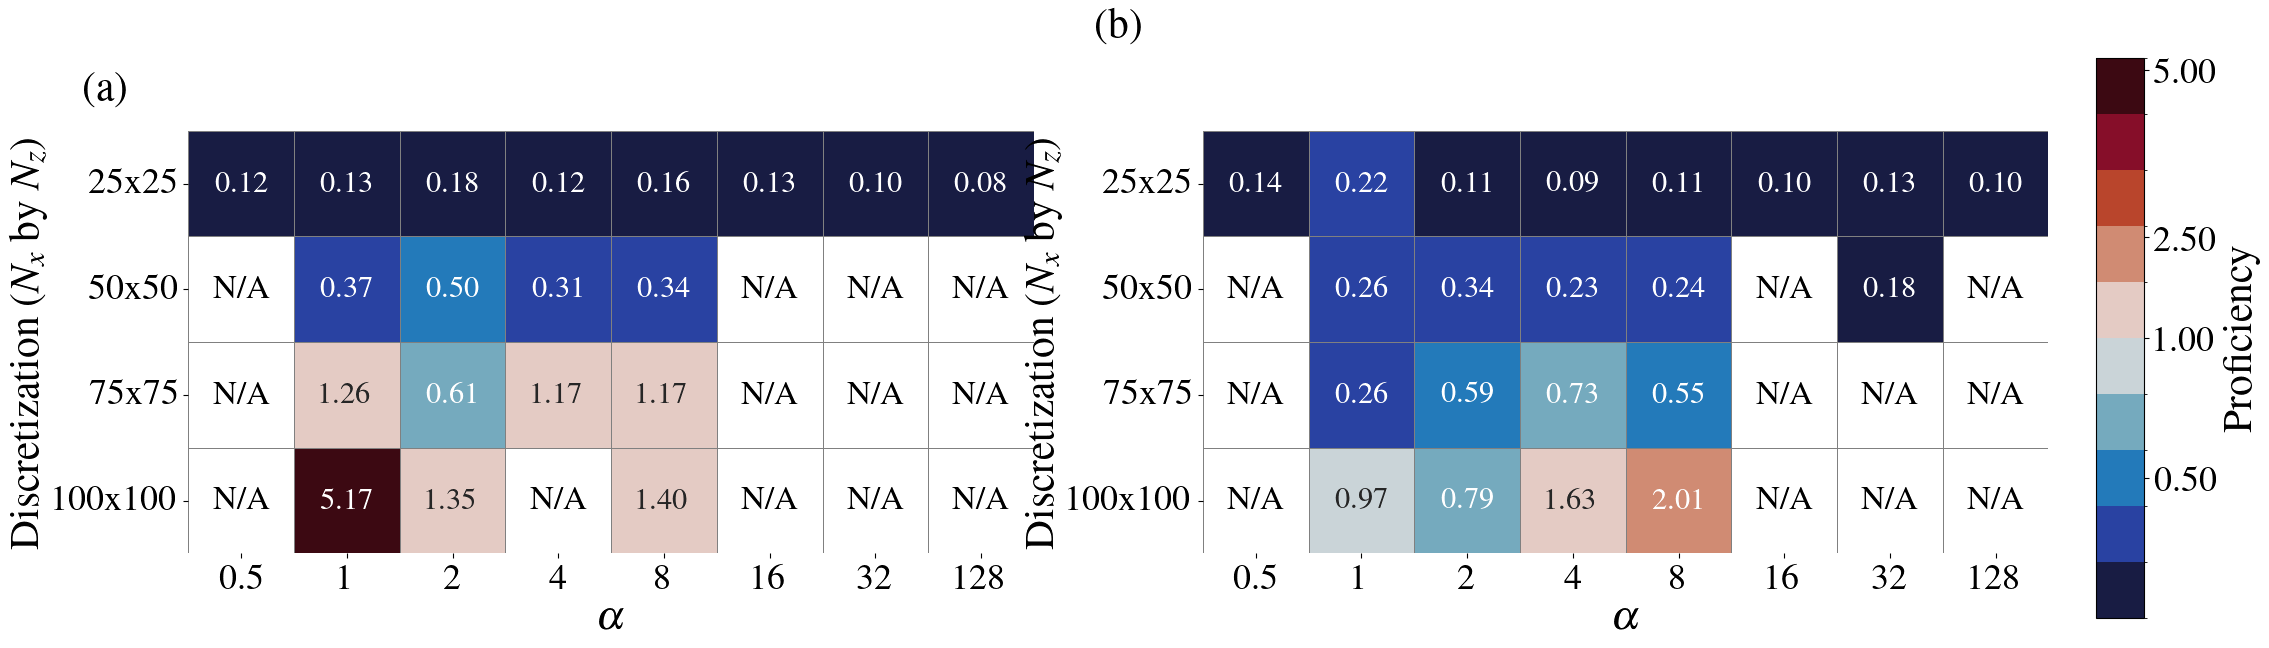

In [ ]:
# import json
# import re
# from pathlib import Path

# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# import seaborn as sns

# from matplotlib.colors import BoundaryNorm, ListedColormap
# from matplotlib.cm import ScalarMappable

# from plants.faults import strikeslip

# # ============================================================
# # Global style (your settings)
# # ============================================================
# sizes = 30
# plt.rcParams.update({
#     'font.size': sizes,
#     'axes.titlesize': sizes,
#     'axes.labelsize': sizes,
#     'xtick.labelsize': sizes,
#     'ytick.labelsize': sizes,
#     'legend.fontsize': sizes,
#     'figure.titlesize': sizes,
#     'text.usetex': True,
#     'font.family': 'Times',
#     'pdf.fonttype': 42,
#     'ps.fonttype': 42,
#     'text.latex.preamble': r'\usepackage{amsmath}\usepackage{mathptmx}',
#     'axes.grid': False,
# })

# # optional cmocean
# try:
#     import cmocean
#     _HAS_CMOCEAN = True
# except Exception:
#     _HAS_CMOCEAN = False
#     print("[INFO] cmocean not found. Falling back to 'coolwarm'.")


# # ------------------------------------------------------------------
# # Minimal helper: build fault & return Dscale and N_DOFS for a grid
# # ------------------------------------------------------------------
# def build_fault_for_grid(Nz: int, Nx: int, patch_size: int):
#     """
#     Build a quasi-static strike-slip fault for given grid size and
#     patch size (3 or 5) and return fault + N_DOFS.
#     """
#     fault_local = strikeslip.qs_strikeslip_fault(
#         zdepth=patch_size,
#         xlength=patch_size,
#         Nz=Nz,
#         Nx=Nx,
#         G=30000.0,
#         rho=2.5e-3,
#         zeta=0.8 / patch_size,
#         Ks_path="./Data/",
#         gamma_s=25.0,
#         gamma_w=10.0,
#         sigma_ref=100.0,
#         depth_ini=0.0,
#         vinf=3.171e-10,
#         Dmu_estimate=0.5,
#     )

#     return {
#         "fault": fault_local,
#         "N_DOFS": fault_local.N,
#     }


# # ------------------------------------------------------------------
# # Load constant-stepper results for a given dataset (3by3 or 5by5)
# # ------------------------------------------------------------------
# def load_constant_stepper_results(
#     output_dir: str,
#     file_pattern: str,
#     patch_size: int,
#     exclude_substrings: list[str] | None = None,
#     verbose: bool = True,
# ):
#     """
#     Load constant-stepper results from NPZ files, compute final mean slip
#     in physical units using Dscale from the fault, and return a dict:

#         label -> dict(runtime_s, s_end)

#     label is e.g. '25x25', '50x50', ...
#     """
#     out_path = Path(output_dir)
#     files = sorted(out_path.glob(file_pattern))

#     if exclude_substrings:
#         files = [
#             f for f in files
#             if not any(sub in f.name for sub in exclude_substrings)
#         ]

#     if verbose:
#         print(f"\nLoading constant-stepper files from {output_dir} with pattern '{file_pattern}':")
#         print("  Found:", [f.name for f in files])

#     const_results: dict[str, dict] = {}

#     for npz_path in files:
#         stem = npz_path.stem  # e.g. 'constant_stepper_50by50' or 'constant_stepper_50by50_5by5'
#         core = stem.replace("constant_stepper_", "")  # e.g. '50by50' or '50by50_5by5'
#         grid_part = core.split("_")[0]  # take '50by50'
#         try:
#             Nz_str, Nx_str = grid_part.split("by")
#             Nz, Nx = int(Nz_str), int(Nx_str)
#         except Exception as e:
#             if verbose:
#                 print(f"  [WARN] Could not parse Nz,Nx from {stem}: {e}")
#             continue

#         # build fault to get Dscale and N_DOFS (patch_size = 3 or 5)
#         grid = build_fault_for_grid(Nz, Nx, patch_size=patch_size)
#         fault = grid["fault"]
#         N = grid["N_DOFS"]
#         Dscale = fault.Dscale

#         data = np.load(npz_path)

#         if "ts1" not in data.files or "ys1" not in data.files:
#             if verbose:
#                 print(f"  [WARN] {npz_path.name} missing ts1/ys1; skipping.")
#             continue

#         ys = data["ys1"]
#         if ys.shape[1] < 3 * N:
#             if verbose:
#                 print(f"  [WARN] {npz_path.name}: ys shape {ys.shape} < 3*N={3*N}; skipping.")
#             continue

#         # slip block (dimensionless), average over DOFs, then scale
#         s_block = ys[:, 2*N:3*N]
#         avg_s_dimless = np.mean(s_block, axis=1)
#         avg_s_phys = avg_s_dimless * Dscale
#         s_end = float(avg_s_phys[-1])

#         # runtime if stored inside npz (optional)
#         if "runtime_s" in data.files:
#             runtime_s = float(data["runtime_s"])
#         elif "wall_time" in data.files:
#             runtime_s = float(data["wall_time"])
#         else:
#             runtime_s = np.nan
#             if verbose:
#                 print(f"  [INFO] {npz_path.name}: no runtime stored; runtime_s=NaN.")

#         label = f"{Nz}x{Nx}"
#         const_results[label] = dict(runtime_s=runtime_s, s_end=s_end)
#         if verbose:
#             print(f"  {npz_path.name}: label={label}, runtime={runtime_s:.3f}s, s_end={s_end:.3e}")

#     return const_results


# # ============================================================
# # Helpers: loading + runtime ratio computation (PI / RL)
# # ============================================================
# def _parse_alpha(method_name: str) -> float | None:
#     m = re.search(r"alpha\s*=\s*([0-9.+-eE]+)", method_name)
#     if not m:
#         return None
#     try:
#         return float(m.group(1))
#     except Exception:
#         return None


# def _aggregate_values(vals: list[float], how: str) -> float:
#     arr = np.array([v for v in vals if np.isfinite(v) and v > 0.0], dtype=float)
#     if arr.size == 0:
#         return np.nan
#     how = how.lower()
#     if how == "min":
#         return float(np.min(arr))
#     if how == "mean":
#         return float(np.mean(arr))
#     if how == "max":
#         return float(np.max(arr))
#     return float(np.min(arr))


# def compute_runtime_ratio_df(
#     results_glob: str,
#     aggregate: str = "min",
#     method_filter_prefix: str | None = None,
#     exclude_substrings: list[str] | None = None,
#     verbose: bool = True,
# ) -> pd.DataFrame | None:
#     """
#     Return DF: index=discretization (e.g. '25x25'),
#                columns=alphas,
#                entries = PI_runtime / RL_runtime.
#     """
#     eval_files = sorted(Path(".").glob(results_glob))
#     if exclude_substrings:
#         eval_files = [
#             f for f in eval_files
#             if not any(sub in f.name for sub in exclude_substrings)
#         ]
#     if not eval_files:
#         print(f"[WARN] No files for glob '{results_glob}' after excludes={exclude_substrings}")
#         return None

#     if verbose:
#         print(f"\nLoading files for glob '{results_glob}' (excludes={exclude_substrings}):")
#         print("  ", [f.name for f in eval_files])

#     all_data: dict[str, dict] = {}
#     for f in eval_files:
#         grid_label_full = f.stem.replace("eval_results_", "")
#         with open(f, "r", encoding="utf-8") as fh:
#             data = json.load(fh)
#         all_data[grid_label_full] = data
#         if verbose:
#             print(f"  Loaded {f.name}: keys={list(data.keys())}")

#     # collect all alphas from RL entries
#     all_alphas = set()
#     for grid_data in all_data.values():
#         for method_name in grid_data.keys():
#             if method_name == "PI_baseline":
#                 continue
#             if method_filter_prefix and not method_name.startswith(method_filter_prefix):
#                 continue
#             a = _parse_alpha(method_name)
#             if a is not None:
#                 all_alphas.add(a)

#     if not all_alphas:
#         print(f"[WARN] No RL methods with alpha=* in '{results_glob}'")
#         return None

#     alphas_sorted = sorted(all_alphas)
#     alpha_labels = [f"{a:g}" for a in alphas_sorted]

#     # index labels: strip e.g. "3by3_25x25" -> "25x25"
#     full_labels = list(all_data.keys())
#     disc_labels = [lab.split("_")[-1] for lab in full_labels]

#     ratio_mat = np.full((len(full_labels), len(alphas_sorted)), np.nan, dtype=float)

#     for i, full_label in enumerate(full_labels):
#         grid_data = all_data[full_label]
#         pi_runtime = grid_data.get("PI_baseline", {}).get("runtime_s", np.nan)
#         if not (np.isfinite(pi_runtime) and pi_runtime > 0.0):
#             if verbose:
#                 print(f"  [WARN] No valid PI baseline for '{full_label}'")
#             continue

#         per_alpha_values: dict[float, list[float]] = {a: [] for a in alphas_sorted}

#         for method_name, method_data in grid_data.items():
#             if method_name == "PI_baseline":
#                 continue
#             if method_filter_prefix and not method_name.startswith(method_filter_prefix):
#                 continue

#             a = _parse_alpha(method_name)
#             if a is None:
#                 continue

#             converged = bool(method_data.get("converged", False))
#             success_rate = float(method_data.get("success_rate", 0.0))
#             if not (converged or success_rate > 0.0):
#                 continue

#             rl_runtime = method_data.get("runtime_s", np.nan)
#             if not (np.isfinite(rl_runtime) and rl_runtime > 0.0):
#                 continue

#             for a_target in per_alpha_values.keys():
#                 if abs(a - a_target) < 1e-12:
#                     per_alpha_values[a_target].append(float(rl_runtime))
#                     break

#         for j, a in enumerate(alphas_sorted):
#             rl_agg = _aggregate_values(per_alpha_values[a], aggregate)
#             if np.isfinite(rl_agg) and rl_agg > 0.0:
#                 ratio_mat[i, j] = pi_runtime / rl_agg
#                 if verbose:
#                     print(
#                         f"  Grid {full_label:>12s}, alpha={a:g}: "
#                         f"PI={pi_runtime:.3f}, RL({aggregate})={rl_agg:.3f}, "
#                         f"ratio={ratio_mat[i,j]:.2f}"
#                     )

#     ratio_df = pd.DataFrame(ratio_mat, index=disc_labels, columns=alpha_labels)

#     # sort: discretization ascending, alpha ascending
#     def _disc_key(lbl: str):
#         try:
#             return int(lbl.split("x")[0])
#         except Exception:
#             return lbl

#     ratio_df = ratio_df.sort_index(key=lambda idx: [_disc_key(s) for s in idx])
#     ratio_df = ratio_df.reindex(sorted(ratio_df.columns, key=lambda s: float(s)), axis=1)

#     if verbose:
#         print("\nRuntime ratio DataFrame (index=disc, columns=alpha):")
#         print(ratio_df)

#     return ratio_df


# # ============================================================
# # Error DF: RL relative error & ratio err_PI / err_RL
# # ============================================================
# def compute_error_dfs_for_dataset(
#     results_glob: str,
#     const_results: dict,
#     aggregate: str = "min",
#     method_filter_prefix: str | None = None,
#     exclude_substrings: list[str] | None = None,
#     verbose: bool = True,
# ):
#     """
#     For a given dataset (3by3 or 5by5), compute:

#       - rl_err_df[grid, alpha]  = |s_RL - s_const| / |s_const|
#       - ratio_err_df[grid, alpha] = (|s_PI - s_const| / |s_const|)
#                                      / (|s_RL - s_const| / |s_const|)

#     where s_const is the final mean slip from the constant-stepper
#     for that discretization.
#     """
#     eval_files = sorted(Path(".").glob(results_glob))
#     if exclude_substrings:
#         eval_files = [
#             f for f in eval_files
#             if not any(sub in f.name for sub in exclude_substrings)
#         ]
#     if not eval_files:
#         print(f"[WARN] No files for glob '{results_glob}' after excludes={exclude_substrings}")
#         return None, None

#     if verbose:
#         print(f"\nLoading files for error computation '{results_glob}' (excludes={exclude_substrings}):")
#         print("  ", [f.name for f in eval_files])

#     all_data: dict[str, dict] = {}
#     for f in eval_files:
#         grid_label_full = f.stem.replace("eval_results_", "")
#         with open(f, "r", encoding="utf-8") as fh:
#             data = json.load(fh)
#         all_data[grid_label_full] = data
#         if verbose:
#             print(f"  Loaded {f.name}: keys={list(data.keys())}")

#     # collect all alphas
#     all_alphas = set()
#     for grid_data in all_data.values():
#         for method_name in grid_data.keys():
#             if method_name == "PI_baseline":
#                 continue
#             if method_filter_prefix and not method_name.startswith(method_filter_prefix):
#                 continue
#             a = _parse_alpha(method_name)
#             if a is not None:
#                 all_alphas.add(a)

#     if not all_alphas:
#         print(f"[WARN] No RL methods with alpha=* in '{results_glob}'")
#         return None, None

#     alphas_sorted = sorted(all_alphas)
#     alpha_labels = [f"{a:g}" for a in alphas_sorted]

#     full_labels = list(all_data.keys())
#     disc_labels = [lab.split("_")[-1] for lab in full_labels]

#     rl_err_mat = np.full((len(full_labels), len(alphas_sorted)), np.nan, dtype=float)
#     ratio_err_mat = np.full((len(full_labels), len(alphas_sorted)), np.nan, dtype=float)

#     for i, full_label in enumerate(full_labels):
#         disc_label = full_label.split("_")[-1]  # e.g. "25x25"
#         grid_data = all_data[full_label]

#         const_entry = const_results.get(disc_label, None)
#         if const_entry is None:
#             if verbose:
#                 print(f"  [WARN] No constant-stepper reference for '{disc_label}'")
#             continue

#         s_const = float(const_entry.get("s_end", np.nan))
#         if not np.isfinite(s_const):
#             if verbose:
#                 print(f"  [WARN] Constant-stepper s_end not finite for '{disc_label}'")
#             continue

#         denom = max(abs(s_const), 1e-16)

#         # PI final slip (independent of alpha)
#         pi_data = grid_data.get("PI_baseline", {})
#         s_pi = float(pi_data.get("s_end_mean", np.nan))
#         if np.isfinite(s_pi):
#             err_pi = abs(s_pi - s_const) / denom
#         else:
#             err_pi = np.nan

#         # gather RL errors per alpha
#         per_alpha_errs: dict[float, list[float]] = {a: [] for a in alphas_sorted}

#         for method_name, method_data in grid_data.items():
#             if method_name == "PI_baseline":
#                 continue
#             if method_filter_prefix and not method_name.startswith(method_filter_prefix):
#                 continue

#             a = _parse_alpha(method_name)
#             if a is None:
#                 continue

#             s_rl = float(method_data.get("s_end_mean", np.nan))
#             if not np.isfinite(s_rl):
#                 continue

#             err_rl = abs(s_rl - s_const) / denom
#             if not np.isfinite(err_rl):
#                 continue

#             for a_target in per_alpha_errs.keys():
#                 if abs(a - a_target) < 1e-12:
#                     per_alpha_errs[a_target].append(err_rl)
#                     break

#         for j, a in enumerate(alphas_sorted):
#             err_rl_agg = _aggregate_values(per_alpha_errs[a], aggregate)
#             if np.isfinite(err_rl_agg) and err_rl_agg > 0.0:
#                 rl_err_mat[i, j] = err_rl_agg
#                 if np.isfinite(err_pi):
#                     ratio_err_mat[i, j] = err_pi / err_rl_agg
#                 if verbose:
#                     print(
#                         f"  Grid {full_label:>12s}, alpha={a:g}: "
#                         f"err_RL={err_rl_agg:.3e}, err_PI={err_pi:.3e}, "
#                         f"ratio={ratio_err_mat[i,j]:.2f}"
#                     )

#     rl_err_df = pd.DataFrame(rl_err_mat, index=disc_labels, columns=alpha_labels)
#     ratio_err_df = pd.DataFrame(ratio_err_mat, index=disc_labels, columns=alpha_labels)

#     # sort
#     def _disc_key(lbl: str):
#         try:
#             return int(lbl.split("x")[0])
#         except Exception:
#             return lbl

#     rl_err_df = rl_err_df.sort_index(key=lambda idx: [_disc_key(s) for s in idx])
#     rl_err_df = rl_err_df.reindex(sorted(rl_err_df.columns, key=lambda s: float(s)), axis=1)

#     ratio_err_df = ratio_err_df.loc[rl_err_df.index, rl_err_df.columns]

#     if verbose:
#         print("\nRL relative error DF:")
#         print(rl_err_df)
#         print("\nError-ratio DF (PI / RL):")
#         print(ratio_err_df)

#     return rl_err_df, ratio_err_df


# # ============================================================
# # Plot helpers (annotations, NA overlay, diverging levels)
# # ============================================================
# def _annotations(df: pd.DataFrame) -> pd.DataFrame:
#     if hasattr(df, "map"):
#         return df.map(lambda x: f"{x:.2f}" if pd.notna(x) else "")
#     return df.applymap(lambda x: f"{x:.2f}" if pd.notna(x) else "")


# def _overlay_na(ax, df: pd.DataFrame, fontsize=12, color="black"):
#     for y in range(df.shape[0]):
#         for x in range(df.shape[1]):
#             if pd.isna(df.iat[y, x]):
#                 ax.text(
#                     x + 0.5,
#                     y + 0.5,
#                     "N/A",
#                     ha="center",
#                     va="center",
#                     fontsize=fontsize,
#                     color=color,
#                 )


# def _symmetric_limits_around_one(vals_all: np.ndarray):
#     vals_all = vals_all[np.isfinite(vals_all)]
#     if vals_all.size == 0:
#         return 0.5, 1.5
#     vmin_real = float(np.min(vals_all))
#     vmax_real = float(np.max(vals_all))
#     delta_low = max(0.0, 1.0 - vmin_real)
#     delta_high = max(0.0, vmax_real - 1.0)
#     half_span = max(delta_low, delta_high)
#     vmin_sym = max(1.0 - half_span, 1e-12)
#     vmax_sym = 1.0 + half_span
#     return vmin_sym, vmax_sym


# def _diverging_levels(vmin_sym: float, vmax_sym: float, n_bins_total: int):
#     if n_bins_total % 2 == 1:
#         n_bins_total += 1
#     n_half = n_bins_total // 2
#     lower = np.linspace(vmin_sym, 1.0, n_half + 1)[:-1]
#     upper = np.linspace(1.0, vmax_sym, n_half + 1)
#     return np.concatenate([lower, upper])  # len = n_bins_total + 1


# # ============================================================
# # Combined heatmap: runtime ratio * error ratio
# # ============================================================
# def create_combined_runtime_error_dual_heatmap(
#     const_output_dir: str,
#     glob_a: str = "eval_results_3by3_*.json",
#     glob_b: str = "eval_results_5by5_*.json",
#     aggregate: str = "min",
#     method_filter_prefix: str | None = None,
#     exclude_substrings_a: list[str] | None = None,
#     exclude_substrings_b: list[str] | None = ["_PI_"],
#     save_path: str = "combined_runtime_error_3by3_vs_5by5.pdf",
#     n_bins_diverging: int = 10,
#     verbose: bool = True,
# ):
#     """
#     Build a figure with two panels:

#       (a) 3by3 data
#       (b) 5by5 data

#     Each panel shows the scalar field:

#         combined = (PI_runtime / RL_runtime) * (err_PI / err_RL)

#     where the reference slip is the constant-stepper result.
#     """

#     # --------------------------------------------------------
#     # 1) Constant-stepper results for 3by3 and 5by5
#     # --------------------------------------------------------
#     const_results_a = load_constant_stepper_results(
#         const_output_dir,
#         file_pattern="constant_stepper_*by*.npz",
#         patch_size=3,
#         exclude_substrings=["_5by5"],  # exclude 5by5 variant here
#         verbose=verbose,
#     )
#     const_results_b = load_constant_stepper_results(
#         const_output_dir,
#         file_pattern="constant_stepper_*by*_5by5.npz",
#         patch_size=5,
#         exclude_substrings=None,
#         verbose=verbose,
#     )

#     # --------------------------------------------------------
#     # 2) Runtime ratios (PI / RL) for 3by3 and 5by5
#     # --------------------------------------------------------
#     runtime_ratio_a = compute_runtime_ratio_df(
#         results_glob=glob_a,
#         aggregate=aggregate,
#         method_filter_prefix=method_filter_prefix,
#         exclude_substrings=exclude_substrings_a,
#         verbose=verbose,
#     )
#     runtime_ratio_b = compute_runtime_ratio_df(
#         results_glob=glob_b,
#         aggregate=aggregate,
#         method_filter_prefix=method_filter_prefix,
#         exclude_substrings=exclude_substrings_b,
#         verbose=verbose,
#     )

#     # --------------------------------------------------------
#     # 3) Error ratios (err_PI / err_RL) via constant stepper
#     # --------------------------------------------------------
#     rl_err_a, err_ratio_a = compute_error_dfs_for_dataset(
#         results_glob=glob_a,
#         const_results=const_results_a,
#         aggregate=aggregate,
#         method_filter_prefix=method_filter_prefix,
#         exclude_substrings=exclude_substrings_a,
#         verbose=verbose,
#     )
#     rl_err_b, err_ratio_b = compute_error_dfs_for_dataset(
#         results_glob=glob_b,
#         const_results=const_results_b,
#         aggregate=aggregate,
#         method_filter_prefix=method_filter_prefix,
#         exclude_substrings=exclude_substrings_b,
#         verbose=verbose,
#     )

#     if runtime_ratio_a is None or runtime_ratio_b is None:
#         print("[ERROR] Runtime ratio DF is None; aborting.")
#         return None, None

#     if err_ratio_a is None or err_ratio_b is None:
#         print("[ERROR] Error ratio DF is None; aborting.")
#         return None, None

#     # Align indices/columns for safety
#     runtime_ratio_a = runtime_ratio_a.loc[rl_err_a.index, rl_err_a.columns]
#     runtime_ratio_b = runtime_ratio_b.loc[rl_err_b.index, rl_err_b.columns]

#     err_ratio_a = err_ratio_a.loc[runtime_ratio_a.index, runtime_ratio_a.columns]
#     err_ratio_b = err_ratio_b.loc[runtime_ratio_b.index, runtime_ratio_b.columns]

#     # Combined fields
#     combined_a = runtime_ratio_a * err_ratio_a
#     combined_b = runtime_ratio_b * err_ratio_b

#     # --------------------------------------------------------
#     # 4) Colour scale: diverging around 1
#     # --------------------------------------------------------
#     vals_a = combined_a.values[np.isfinite(combined_a.values)]
#     vals_b = combined_b.values[np.isfinite(combined_b.values)]

#     if vals_a.size == 0 and vals_b.size == 0:
#         print("[ERROR] No finite combined values to plot.")
#         return combined_a, combined_b

#     if vals_a.size == 0:
#         all_vals = vals_b
#     elif vals_b.size == 0:
#         all_vals = vals_a
#     else:
#         all_vals = np.concatenate([vals_a, vals_b])

#     vmin_sym, vmax_sym = _symmetric_limits_around_one(all_vals)

#     if n_bins_diverging % 2 == 1:
#         n_bins_diverging += 1
#     levels = _diverging_levels(vmin_sym, vmax_sym, n_bins_total=n_bins_diverging)
#     ncolors = len(levels) - 1

#     # base cmap: cmocean.balance if available, otherwise coolwarm
#     if _HAS_CMOCEAN:
#         base_cmap = cmocean.cm.balance
#     else:
#         base_cmap = plt.get_cmap("coolwarm")

#     cmap_disc = ListedColormap(base_cmap(np.linspace(0, 1, ncolors)))
#     cmap_disc.set_bad(color="white")
#     norm = BoundaryNorm(boundaries=levels, ncolors=ncolors)

#     # --------------------------------------------------------
#     # 5) Figure layout
#     # --------------------------------------------------------
#     fig = plt.figure(figsize=(24, 8))
#     gs = fig.add_gridspec(
#         nrows=1,
#         ncols=2,
#         width_ratios=[1, 1],
#         wspace=0.2,
#     )

#     ax_a = fig.add_subplot(gs[0, 0])
#     ax_b = fig.add_subplot(gs[0, 1])
#     cax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # colourbar axis

#     # Panel (a): 3by3
#     ann_a = _annotations(combined_a)
#     sns.heatmap(
#         combined_a,
#         annot=ann_a.values,
#         fmt="",
#         cmap=cmap_disc,
#         norm=norm,
#         mask=combined_a.isna(),
#         cbar=False,
#         annot_kws={"size": sizes - 8},
#         linewidths=0.5,
#         linecolor="gray",
#         square=True,
#         ax=ax_a,
#     )
#     _overlay_na(ax_a, combined_a, fontsize=sizes - 6)
#     ax_a.set_xlabel(r"$\alpha$", fontsize=sizes)
#     ax_a.set_ylabel(r"Discretization ($N_x$ by $N_z$)", fontsize=sizes)
#     ax_a.tick_params(axis="both", labelsize=sizes - 4)
#     ax_a.text(
#         -0.07,
#         1.05,
#         r"(a)",
#         transform=ax_a.transAxes,
#         fontsize=sizes,
#         va="bottom",
#         ha="right",
#     )

#     # Panel (b): 5by5
#     ann_b = _annotations(combined_b)
#     sns.heatmap(
#         combined_b,
#         annot=ann_b.values,
#         fmt="",
#         cmap=cmap_disc,
#         norm=norm,
#         mask=combined_b.isna(),
#         cbar=False,
#         annot_kws={"size": sizes - 8},
#         linewidths=0.5,
#         linecolor="gray",
#         square=True,
#         ax=ax_b,
#     )
#     _overlay_na(ax_b, combined_b, fontsize=sizes - 6)
#     ax_b.set_xlabel(r"$\alpha$", fontsize=sizes)
#     ax_b.set_ylabel(r"Discretization ($N_x$ by $N_z$)", fontsize=sizes)
#     ax_b.tick_params(axis="both", labelsize=sizes - 4)
#     ax_b.text(
#         -0.07,
#         1.2,
#         r"(b)",
#         transform=ax_b.transAxes,
#         fontsize=sizes,
#         va="bottom",
#         ha="right",
#     )

#     # Shared colourbar
#     sm = ScalarMappable(norm=norm, cmap=cmap_disc)
#     sm.set_array([])
#     cbar = fig.colorbar(sm, cax=cax)

#     # Ticks, ensuring 1.0 is visible
#     n_ticks = 7
#     base_ticks = np.linspace(vmin_sym, vmax_sym, n_ticks)
#     if len(base_ticks) > 0:
#         idx_closest = np.argmin(np.abs(base_ticks - 1.0))
#         base_ticks[idx_closest] = 1.0

#     ticks = np.sort(np.unique(base_ticks))
#     ticks = np.array([ 0.5, 1,  2.5, 5])

#     cbar.set_ticks(ticks)
#     tick_labels = [f"{t:.2f}" if abs(t - 1.0) > 0.01 else "1.00" for t in ticks]
#     cbar.set_ticklabels(tick_labels)
#     cbar.set_label(
#         r"Proficiency",
#         fontsize=sizes,
#     )
#     cbar.ax.tick_params(labelsize=sizes - 4)

#     fig.tight_layout(rect=[0.03, 0.05, 0.97, 0.95])
#     fig.savefig(save_path, dpi=300, bbox_inches="tight")
#     print(f"Saved combined runtime-error dual heatmap to {save_path}")
#     plt.show()

#     return combined_a, combined_b


# # ============================================================
# # Example call
# # ============================================================
# if __name__ == "__main__":
#     combined_3by3, combined_5by5 = create_combined_runtime_error_dual_heatmap(
#         const_output_dir=".",                   # where constant_stepper_*.npz live
#         glob_a="eval_results_3by3_*.json",
#         glob_b="eval_results_5by5_*.json",
#         aggregate="min",                        # best RL per alpha
#         method_filter_prefix=None,              # or "TQC " for only TQC
#         exclude_substrings_a=None,
#         exclude_substrings_b=["_PI_"],          # exclude eval_results_5by5_PI_*.json
#         save_path="combined_runtime_error_3by3_vs_5by5.pdf",
#         n_bins_diverging=10,
#         verbose=True,
#     )



Loading constant-stepper from . with pattern 'constant_stepper_*by*.npz':
  Found: ['constant_stepper_100by100.npz', 'constant_stepper_100by100_5by5.npz', 'constant_stepper_25by25.npz', 'constant_stepper_25by25_5by5.npz', 'constant_stepper_50by50.npz', 'constant_stepper_50by50_5by5.npz', 'constant_stepper_75by75.npz', 'constant_stepper_75by75_5by5.npz']
Loading: ./Data/kijs_100x100elem-3x3length.npy
Theoretical value of total stiffness assuming a patch of dimensions Lx x Lz:  3.501230118388745e-07
Approximate value of total stiffness assuming a patch of length Lx:  3.333333333333333e-07
Calculated value:  1.1492959183203097e-06
Units are in: mm,N,ms,MPa,gr
  constant_stepper_100by100.npz: label=100x100, s_const_end=2.387e+02
Loading: ./Data/kijs_25x25elem-3x3length.npy
Theoretical value of total stiffness assuming a patch of dimensions Lx x Lz:  3.501230118388745e-07
Approximate value of total stiffness assuming a patch of length Lx:  3.333333333333333e-07
Calculated value:  8.8020546

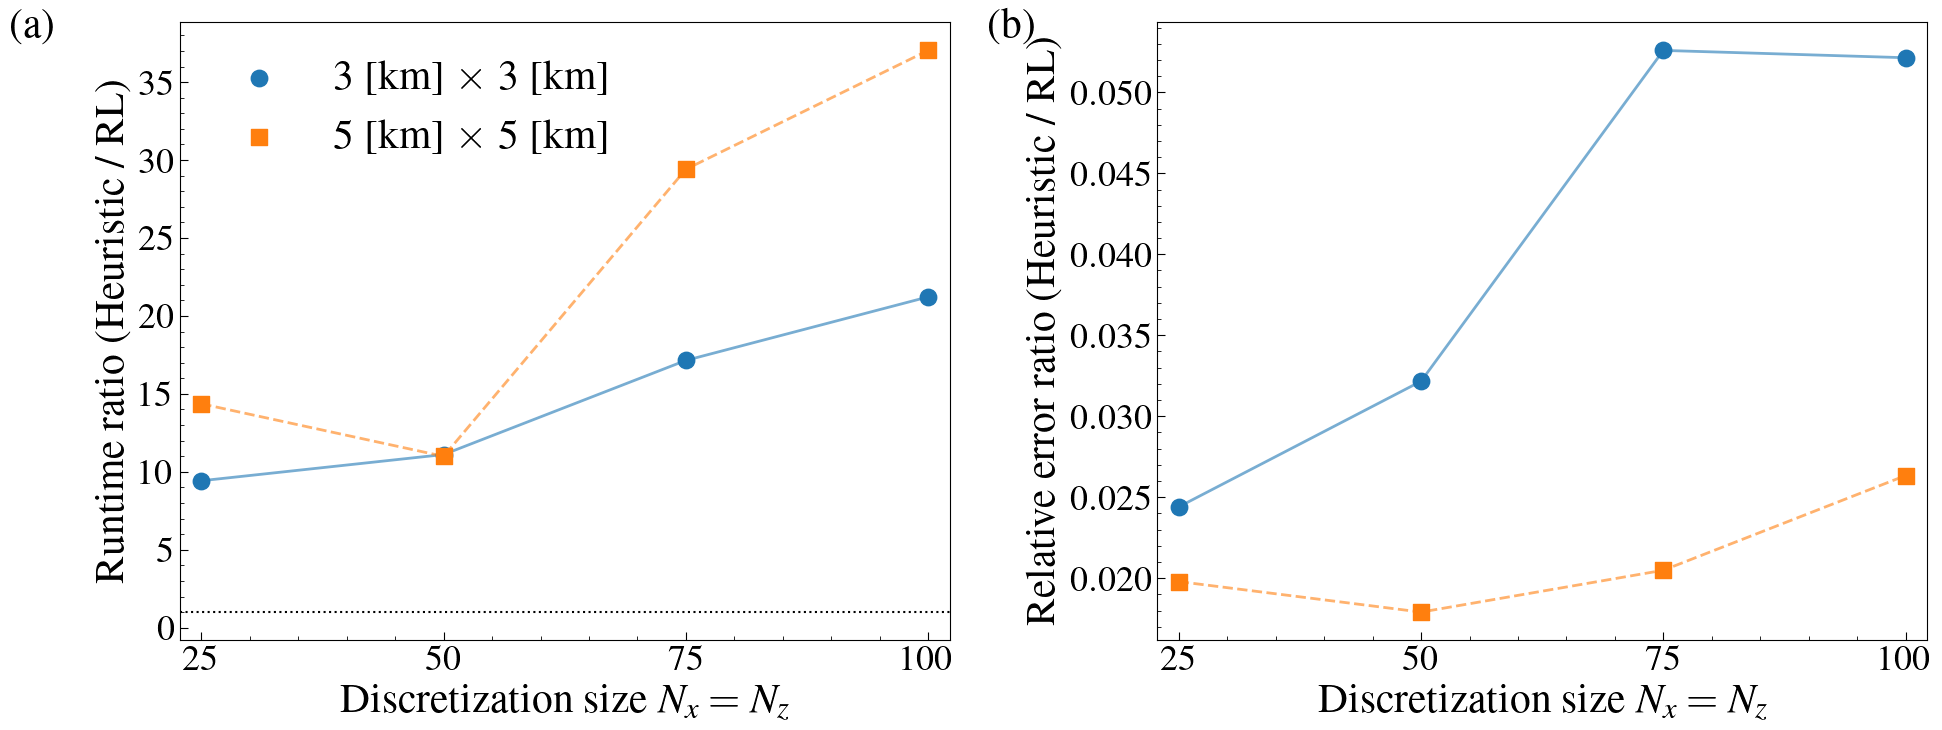

In [1]:
import os
import json
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from plants.faults import strikeslip  # your module

# ============================================================
# Global style (your settings)
# ============================================================
sizes = 30
plt.rcParams.update({
    'font.size': sizes,
    'axes.titlesize': sizes,
    'axes.labelsize': sizes,
    'xtick.labelsize': sizes,
    'ytick.labelsize': sizes,
    'legend.fontsize': sizes,
    'figure.titlesize': sizes,
    'text.usetex': True,
    'font.family': 'Times',
    'pdf.fonttype': 42,
    'ps.fonttype': 42,
    'text.latex.preamble': r'\usepackage{amsmath}\usepackage{mathptmx}',
    'axes.grid': False,
})

# ============================================================
# Helpers
# ============================================================

def _disc_key(label: str) -> int:
    """Sort key for labels like '25x25' -> 25."""
    try:
        return int(label.split("x")[0])
    except Exception:
        return 0


def _aggregate_values(vals, how: str = "min") -> float:
    """Aggregate a list of runtimes according to 'min', 'mean', or 'max'."""
    arr = np.array([v for v in vals if np.isfinite(v) and v > 0.0], dtype=float)
    if arr.size == 0:
        return np.nan
    how = how.lower()
    if how == "min":
        return float(np.min(arr))
    if how == "mean":
        return float(np.mean(arr))
    if how == "max":
        return float(np.max(arr))
    return float(np.min(arr))


def build_fault_minimal(Nz: int, Nx: int, zdepth: float, xlength: float):
    """
    Minimal fault builder for post-processing.

    We only need:
      - fault.Dscale
      - fault.N  (number of DOFs)
    """
    fault_local = strikeslip.qs_strikeslip_fault(
        zdepth=zdepth,
        xlength=xlength,
        Nz=Nz,
        Nx=Nx,
        G=30000.0,
        rho=2.5e-3,
        zeta=0.8 / 3.0,        # as in your main setup
        Ks_path="./Data/",
        gamma_s=25.0,
        gamma_w=10.0,
        sigma_ref=100.0,
        depth_ini=0.0,
        vinf=3.171e-10,
        Dmu_estimate=0.5,
    )
    return {
        "fault": fault_local,
        "N_DOFS": fault_local.N,
    }


# ============================================================
# Load constant-stepper reference (s_const)
# ============================================================

def load_constant_stepper_results(
    output_dir: str,
    file_pattern: str,
    zdepth: float,
    xlength: float,
    is_5by5: bool,
    verbose: bool = True,
):
    """
    Load constant-stepper results from NPZ files.

    Parameters
    ----------
    output_dir : directory containing the NPZ files
    file_pattern : glob pattern, e.g.
        - "constant_stepper_*by*.npz"       (3-by-3 case)
        - "constant_stepper_*by*_5by5.npz"  (5-by-5 case)
    zdepth, xlength : physical dimensions (3 or 5)
    is_5by5 : if True, only keep files whose stem contains '_5by5';
              if False, skip files containing '_5by5'.

    Returns
    -------
    dict[label] -> s_const_end  (physical final mean slip)
        label like '25x25', '50x50', ...
    """
    out_path = Path(output_dir)
    files = sorted(out_path.glob(file_pattern))

    if verbose:
        print(f"\nLoading constant-stepper from {output_dir} with pattern '{file_pattern}':")
        print("  Found:", [f.name for f in files])

    results = {}

    for npz_path in files:
        stem = npz_path.stem  # e.g. 'constant_stepper_25by25' or 'constant_stepper_25by25_5by5'

        if is_5by5:
            if "_5by5" not in stem:
                continue
        else:
            if "_5by5" in stem:
                continue

        # Extract "25by25" part before any extra suffix
        grid_part = stem.replace("constant_stepper_", "")  # '25by25' or '25by25_5by5'
        grid_main = grid_part.split("_")[0]                # '25by25'
        try:
            Nz_str, Nx_str = grid_main.split("by")
            Nz, Nx = int(Nz_str), int(Nx_str)
        except Exception as e:
            if verbose:
                print(f"  [WARN] Could not parse Nz,Nx from {stem}: {e}")
            continue

        grid = build_fault_minimal(Nz, Nx, zdepth=zdepth, xlength=xlength)
        fault = grid["fault"]
        N = grid["N_DOFS"]
        Dscale = fault.Dscale

        data = np.load(npz_path)

        if "ts1" not in data.files or "ys1" not in data.files:
            if verbose:
                print(f"  [WARN] {npz_path.name} missing ts1/ys1; skipping.")
            continue

        ys = data["ys1"]
        if ys.shape[1] < 3 * N:
            if verbose:
                print(f"  [WARN] {npz_path.name}: ys shape {ys.shape} < 3*N={3*N}; skipping.")
            continue

        # slip block (dimensionless), average over DOFs, then scale
        s_block = ys[:, 2 * N : 3 * N]
        avg_s_dimless = np.mean(s_block, axis=1)
        avg_s_phys = avg_s_dimless * Dscale
        s_end = float(avg_s_phys[-1])

        label = f"{Nz}x{Nx}"
        results[label] = s_end

        if verbose:
            print(f"  {npz_path.name}: label={label}, s_const_end={s_end:.3e}")

    return results


# ============================================================
# Load PI results (runtime + final slip)
# ============================================================

def load_pi_results(glob_pattern: str,
                    stem_prefix_to_strip: str,
                    verbose: bool = True):
    """
    Load PI_baseline runtime and final slip s_end_mean from JSON files.

    Returns
    -------
    dict[label] -> dict(runtime_s, s_end)
    """
    results = {}
    files = sorted(Path(".").glob(glob_pattern))
    if verbose:
        print(f"\nLoading PI_baseline from {glob_pattern}:")
        print("  Found:", [f.name for f in files])

    for path in files:
        stem = path.stem  # 'eval_results_3by3_25x25' or 'eval_results_5by5_25x25'
        label = stem.replace(stem_prefix_to_strip, "")  # '25x25', etc.

        try:
            with open(path, "r", encoding="utf-8") as fh:
                data = json.load(fh)
        except Exception as e:
            if verbose:
                print(f"  [WARN] Failed to read {path.name}: {e}")
            continue

        pi_data = data.get("PI_baseline", {})
        runtime = float(pi_data.get("runtime_s", np.nan))
        s_end = pi_data.get("s_end_mean", np.nan)
        s_end = float(s_end) if s_end is not None else np.nan

        if not np.isfinite(runtime) or not np.isfinite(s_end):
            if verbose:
                print(f"  [WARN] {path.name}: invalid PI runtime/slip ({runtime}, {s_end})")
            continue

        results[label] = dict(runtime_s=runtime, s_end=s_end)
        if verbose:
            print(f"  {path.name}: label={label}, PI runtime={runtime:.3f}s, s_end={s_end:.3e}")

    return results


# ============================================================
# Load RESUMED RL (runtime + final slip)
# ============================================================

def load_resumed_rl_runtime_and_slip(
    glob_pattern: str,
    method_filter_prefix: str | None = None,
    is_5by5: bool = False,
    aggregate: str = "min",
    verbose: bool = True,
):
    """
    Load RL runtimes and final slips from eval_results_RESUMED*.json.

    For each file:
      - filter RL methods (skip PI_baseline, optionally by prefix),
      - among those, pick the method with MIN runtime,
      - record its runtime and s_end_mean.

    If multiple files map to the same label, we again keep the minimum runtime
    (and its associated slip).

    Returns
    -------
    dict[label] -> dict(runtime_s, s_end)
    """
    results = {}
    files = sorted(Path(".").glob(glob_pattern))
    if verbose:
        print(f"\nLoading RESUMED RL from {glob_pattern}:")
        print("  Found:", [f.name for f in files])

    for path in files:
        stem = path.stem
        # Determine label (e.g. '25x25')
        if is_5by5:
            if "5by5" not in stem:
                continue
            label = stem.split("_")[-1]  # eval_results_RESUMED_5by5_25x25 -> '25x25'
        else:
            if "5by5" in stem:
                continue
            parts = stem.replace("eval_results_RESUMED_", "").split("_")
            label = parts[-1]  # eval_results_RESUMED_25x25 -> '25x25' (or similar)

        try:
            with open(path, "r", encoding="utf-8") as fh:
                data = json.load(fh)
        except Exception as e:
            if verbose:
                print(f"  [WARN] Failed to read {path.name}: {e}")
            continue

        best_runtime = np.inf
        best_s_end = np.nan

        for method_name, method_data in data.items():
            if method_name == "PI_baseline":
                continue
            if method_filter_prefix and not method_name.startswith(method_filter_prefix):
                continue

            converged = bool(method_data.get("converged", False))
            success_rate = float(method_data.get("success_rate", 0.0))
            if not (converged or success_rate > 0.0):
                continue

            rl_runtime = method_data.get("runtime_s", np.nan)
            s_end = method_data.get("s_end_mean", np.nan)

            if not (np.isfinite(rl_runtime) and rl_runtime > 0.0 and np.isfinite(s_end)):
                continue

            if rl_runtime < best_runtime:
                best_runtime = float(rl_runtime)
                best_s_end = float(s_end)

        if not np.isfinite(best_runtime):
            if verbose:
                print(f"  [WARN] {path.name}: no valid RL methods.")
            continue

        # If label already present, keep the best across files
        if label in results:
            prev = results[label]
            if best_runtime < prev["runtime_s"]:
                results[label] = dict(runtime_s=best_runtime, s_end=best_s_end)
        else:
            results[label] = dict(runtime_s=best_runtime, s_end=best_s_end)

        if verbose:
            print(f"  {path.name}: label={label}, RL runtime={best_runtime:.3f}s, s_end={best_s_end:.3e}")

    return results


# ============================================================
# Main: dual scatter (a) runtime ratio, (b) error ratio
# ============================================================

def scatter_runtime_and_error_ratio_resumed(
    const_output_dir: str = ".",
    pi_glob_3by3: str = "eval_results_3by3_*.json",
    pi_glob_5by5: str = "eval_results_5by5_*.json",
    rl_glob_3by3: str = "eval_results_RESUMED_*.json",
    rl_glob_5by5: str = "eval_results_RESUMED_5by5_*.json",
    method_filter_prefix: str | None = None,
    aggregate: str = "min",
    save_path: str = "runtime_and_error_ratio_resumed_scatter.pdf",
    verbose: bool = True,
):
    """
    Create a figure with two panels:

    (a) runtime ratio (PI / RL_resumed) vs discretization, for 3x3 and 5x5.
    (b) relative error ratio (err_PI / err_RL) vs discretization,
        where errors are relative to the constant-stepper final slip.

    Reference (for both 3x3 and 5x5) is s_const from constant_stepper_*.
    """

    # 1) Constant stepper (reference solution)
    const_3 = load_constant_stepper_results(
        output_dir=const_output_dir,
        file_pattern="constant_stepper_*by*.npz",
        zdepth=3.0,
        xlength=3.0,
        is_5by5=False,
        verbose=verbose,
    )
    const_5 = load_constant_stepper_results(
        output_dir=const_output_dir,
        file_pattern="constant_stepper_*by*_5by5.npz",
        zdepth=5.0,
        xlength=5.0,
        is_5by5=True,
        verbose=verbose,
    )

    # 2) PI results (3by3 and 5by5)
    pi_3 = load_pi_results(
        glob_pattern=pi_glob_3by3,
        stem_prefix_to_strip="eval_results_3by3_",
        verbose=verbose,
    )
    pi_5 = load_pi_results(
        glob_pattern=pi_glob_5by5,
        stem_prefix_to_strip="eval_results_5by5_",
        verbose=verbose,
    )

    # 3) RESUMED RL (3by3 and 5by5)
    rl_3 = load_resumed_rl_runtime_and_slip(
        glob_pattern=rl_glob_3by3,
        method_filter_prefix=method_filter_prefix,
        is_5by5=False,
        aggregate=aggregate,
        verbose=verbose,
    )
    rl_5 = load_resumed_rl_runtime_and_slip(
        glob_pattern=rl_glob_5by5,
        method_filter_prefix=method_filter_prefix,
        is_5by5=True,
        aggregate=aggregate,
        verbose=verbose,
    )

    # 4) Build datasets for 3x3 and 5x5
    labels_3 = sorted(
        set(pi_3.keys()) & set(rl_3.keys()) & set(const_3.keys()),
        key=_disc_key,
    )
    labels_5 = sorted(
        set(pi_5.keys()) & set(rl_5.keys()) & set(const_5.keys()),
        key=_disc_key,
    )

    if verbose:
        print("\nLabels for 3x3:", labels_3)
        print("Labels for 5x5:", labels_5)

    def _collect_series(labels, pi_dict, rl_dict, const_dict):
        xs = []
        runtime_ratios = []
        err_ratios = []

        for lbl in labels:
            try:
                N = int(lbl.split("x")[0])
            except Exception:
                continue

            pi_rt = pi_dict[lbl]["runtime_s"]
            pi_s = pi_dict[lbl]["s_end"]
            rl_rt = rl_dict[lbl]["runtime_s"]
            rl_s = rl_dict[lbl]["s_end"]
            s_const = const_dict[lbl]

            if not (np.isfinite(pi_rt) and np.isfinite(rl_rt) and rl_rt > 0.0):
                continue
            if not (np.isfinite(pi_s) and np.isfinite(rl_s) and np.isfinite(s_const)):
                continue
            if s_const == 0.0:
                continue

            # runtime ratio
            rr = pi_rt / rl_rt

            # relative errors w.r.t. constant-stepper
            err_pi = abs(pi_s - s_const) / abs(s_const)
            err_rl = abs(rl_s - s_const) / abs(s_const)
            if err_rl <= 0.0:
                err_ratio = np.nan
            else:
                err_ratio = err_pi / err_rl

            if not np.isfinite(rr) or not np.isfinite(err_ratio):
                continue

            xs.append(N)
            runtime_ratios.append(rr)
            err_ratios.append(err_ratio)

        return np.array(xs, dtype=float), np.array(runtime_ratios, dtype=float), np.array(err_ratios, dtype=float)

    x3, rr3, er3 = _collect_series(labels_3, pi_3, rl_3, const_3)
    x5, rr5, er5 = _collect_series(labels_5, pi_5, rl_5, const_5)

    # =======================================================
    # 5) Plot: panel (a) runtime ratio, panel (b) error ratio
    #    styled like your FOSM figure (no shared x-axis)
    # =======================================================
    fig, (ax_a, ax_b) = plt.subplots(1, 2, figsize=(20, 8))

    # Axis aesthetics: minor ticks, inward ticks, no gridlines
    for ax in (ax_a, ax_b):
        ax.minorticks_on()
        ax.tick_params(axis='both', which='both', direction='in')
        ax.tick_params(axis='both', which='major', length=6)
        ax.tick_params(axis='both', which='minor', length=3)
        ax.grid(False)
        ax.margins(x=0.03, y=0.05)

    # ---- Panel (a): runtime ratio PI / RL ----
    if x3.size > 0:
        ax_a.scatter(x3, rr3, marker="o", s=140,
                     label=r"3 [km] $\times$ 3 [km]", zorder=3)
        ax_a.plot(x3, rr3, linestyle="-", linewidth=2, alpha=0.6, zorder=2)
    if x5.size > 0:
        ax_a.scatter(x5, rr5, marker="s", s=140,
                     label=r"5 [km] $\times$ 5 [km]", zorder=3)
        ax_a.plot(x5, rr5, linestyle="--", linewidth=2, alpha=0.6, zorder=2)

    ax_a.axhline(1.0, color="k", linestyle=":", linewidth=1.5, zorder=1)

    ax_a.set_xlabel(r"Discretization size $N_x = N_z$", fontsize=sizes)
    ax_a.set_ylabel(r"Runtime ratio (Heuristic / RL)", fontsize=sizes)

    all_x_a = np.concatenate([x3, x5]) if (x3.size and x5.size) else (x3 if x3.size else x5)
    if all_x_a.size > 0:
        xticks = np.array(sorted(np.unique(all_x_a))).astype(int)
        ax_a.set_xticks(xticks)
        ax_a.set_xticklabels([f"{int(n)}" for n in xticks])

    ax_a.tick_params(axis="both", labelsize=sizes - 4)
    ax_a.legend(loc="best", frameon=False)

    # Panel label (a) – to the left of the axis
    ax_a.text(-0.22, 1.02, '(a)', transform=ax_a.transAxes,
              va='top', ha='left')

    # ---- Panel (b): error ratio (err_PI / err_RL) ----
    if x3.size > 0:
        ax_b.scatter(x3, er3, marker="o", s=140,
                     label=r"3 [km] $\times$ 3 [km]", zorder=3)
        ax_b.plot(x3, er3, linestyle="-", linewidth=2, alpha=0.6, zorder=2)
    if x5.size > 0:
        ax_b.scatter(x5, er5, marker="s", s=140,
                     label=r"5 [km] $\times$ 5 [km]", zorder=3)
        ax_b.plot(x5, er5, linestyle="--", linewidth=2, alpha=0.6, zorder=2)

    # (No horizontal line here, as in your tweak)
    ax_b.set_xlabel(r"Discretization size $N_x = N_z$", fontsize=sizes)
    ax_b.set_ylabel(r"Relative error ratio (Heuristic / RL)", fontsize=sizes)

    all_x_b = np.concatenate([x3, x5]) if (x3.size and x5.size) else (x3 if x3.size else x5)
    if all_x_b.size > 0:
        xticks_b = np.array(sorted(np.unique(all_x_b))).astype(int)
        ax_b.set_xticks(xticks_b)
        ax_b.set_xticklabels([f"{int(n)}" for n in xticks_b])

    ax_b.tick_params(axis="both", labelsize=sizes - 4)
    # No legend on (b), to mirror your example figure

    # Panel label (b) – to the left of the axis
    ax_b.text(-0.22, 1.02, '(b)', transform=ax_b.transAxes,
              va='top', ha='left')

    fig.tight_layout()
    fig.savefig(save_path, dpi=300, bbox_inches="tight")
    print(f"\nSaved dual scatter figure to {save_path}")

    # small summary table if you want to inspect
    rows = []
    for lbl in sorted(set(labels_3) | set(labels_5), key=_disc_key):
        row = {"grid": lbl}
        if lbl in labels_3:
            N3 = int(lbl.split("x")[0])
            idx3 = np.where(x3 == N3)[0]
            if idx3.size > 0:
                row["N"] = N3
                row["runtime_ratio_3x3"] = float(rr3[idx3[0]])
                row["error_ratio_3x3"] = float(er3[idx3[0]])
        if lbl in labels_5:
            N5 = int(lbl.split("x")[0])
            idx5 = np.where(x5 == N5)[0]
            if idx5.size > 0:
                row.setdefault("N", N5)
                row["runtime_ratio_5x5"] = float(rr5[idx5[0]])
                row["error_ratio_5x5"] = float(er5[idx5[0]])
        rows.append(row)

    df_summary = pd.DataFrame(rows).set_index("grid")
    return df_summary


# ============================================================
# Example call
# ============================================================
if __name__ == "__main__":
    df_summary = scatter_runtime_and_error_ratio_resumed(
        const_output_dir=".",                         # where constant_stepper_*.npz live
        pi_glob_3by3="eval_results_3by3_*.json",
        pi_glob_5by5="eval_results_5by5_*.json",
        rl_glob_3by3="eval_results_RESUMED_*.json",
        rl_glob_5by5="eval_results_RESUMED_5by5_*.json",
        method_filter_prefix=None,                   # or "TQC " if you only want TQC
        aggregate="min",                             # fastest RL
        save_path="transfer_learned.pdf",
        verbose=True,
    )
    print("\nSummary table:")
    print(df_summary)
